### TFG MES - Cesar Hernandez Rodriguez
El estudio se hace con los datos historicos de mes a mes (21 dias), se realiza la prediccion de ciertos activos elegidos previamente, si se necesita cualquier otro activo del NASDAQ estan en los otros script ya que esto solo es una pequeña muestra representativa del funcionamiento

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['AAPL', 'SNRC', 'ATVI', 'MINI', 'GOOG', 'BBOX']$ 

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [18]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN #Redes Recurrentes
from keras.layers import LSTM
from keras.layers import GRU
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [6]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols-TFG.csv')
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq()

In [4]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2015-12-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_test.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_test.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [9]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_test.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_test.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [7]:
datos_descargados = False
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a descargar los datos****

LLeva descargados el  0.0 % de los datos
LLeva descargados el  33.33333333333333 % de los datos
LLeva descargados el  66.66666666666666 % de los datos

Ha tardado en descargar los datos: 12.5916180611 segundos.

 ****Empezamos a descargar los datos test****

LLeva descargados el  0.0 % de los datos test
LLeva descargados el  33.33333333333333 % de los datos test
LLeva descargados el  66.66666666666666 % de los datos test

Ha tardado en descargar los datos test: 6.5244321823 segundos.




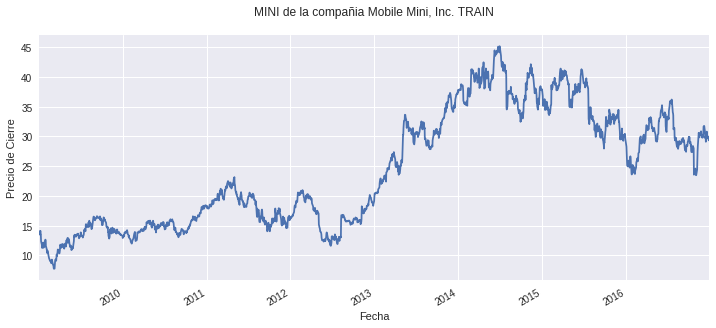

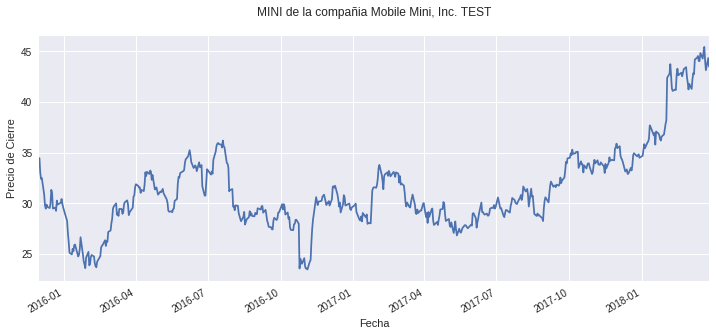

In [11]:
# Grafico un activo aleatorio 
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = random.randint(0,len(tickers)-1)
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

In [13]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

In [15]:
# A parte de la creacion de atributos
index = ran
timeStep = 21 # longitud de secuencias que se hacen en cada iteracion de la red

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers['Symbol'][index]],10,20)
Y = pd.DataFrame(datosClose[tickers['Symbol'][index]].values[21:len(datosClose[tickers['Symbol'][index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers['Symbol'][index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers['Symbol'][index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers['Symbol'][index]].values[21:len(datosClose_test[tickers['Symbol'][index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo {} de la compañia {}".format(ticket_uso,tickers['CompanyName'][index]))

Voy a predecir el activo MINI de la compañia Mobile Mini, Inc.


In [16]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [22]:
modelRNN42 = Sequential()
modelRNN42.add(SimpleRNN(input_shape=(21,3),units=4,activation='relu',return_sequences=True))
modelRNN42.add(SimpleRNN(2,activation="relu"))
modelRNN42.add(Dense(1)) 
modelRNN42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN42.summary()
history_RNN42 = modelRNN42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 21, 4)             32        
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 2)                 14        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 387.6663 - porcentaje_margen: 0.0000e+00 - val_loss: 293.9587 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 1s 663us/step - loss: 128.2871 - porcentaje_margen: 0.0551 - val_loss: 14.9200 - val_porcentaje_margen: 0.3

1314/1314 [==============================] - 1s 519us/step - loss: 3.6428 - porcentaje_margen: 0.5312 - val_loss: 3.7725 - val_porcentaje_margen: 0.5466
Epoch 46/1500
1314/1314 [==============================] - 1s 533us/step - loss: 3.6550 - porcentaje_margen: 0.5387 - val_loss: 3.9488 - val_porcentaje_margen: 0.5332
Epoch 47/1500
1314/1314 [==============================] - 1s 569us/step - loss: 3.6270 - porcentaje_margen: 0.5350 - val_loss: 3.7190 - val_porcentaje_margen: 0.5532
Epoch 48/1500
1314/1314 [==============================] - 1s 536us/step - loss: 3.6355 - porcentaje_margen: 0.5417 - val_loss: 3.6985 - val_porcentaje_margen: 0.5440
Epoch 49/1500
1314/1314 [==============================] - 1s 549us/step - loss: 3.6342 - porcentaje_margen: 0.5350 - val_loss: 4.0987 - val_porcentaje_margen: 0.5240
Epoch 50/1500
1314/1314 [==============================] - 1s 530us/step - loss: 3.6797 - porcentaje_margen: 0.5216 - val_loss: 3.7731 - val_porcentaje_margen: 0.5422
Epoch 51/150

1314/1314 [==============================] - 1s 538us/step - loss: 3.1749 - porcentaje_margen: 0.5521 - val_loss: 3.2462 - val_porcentaje_margen: 0.5708
Epoch 95/1500
1314/1314 [==============================] - 1s 513us/step - loss: 3.3604 - porcentaje_margen: 0.5275 - val_loss: 3.4907 - val_porcentaje_margen: 0.5582
Epoch 96/1500
1314/1314 [==============================] - 1s 562us/step - loss: 3.2652 - porcentaje_margen: 0.5476 - val_loss: 3.2406 - val_porcentaje_margen: 0.5779
Epoch 97/1500
1314/1314 [==============================] - 1s 546us/step - loss: 3.1625 - porcentaje_margen: 0.5551 - val_loss: 3.2559 - val_porcentaje_margen: 0.5630
Epoch 98/1500
1314/1314 [==============================] - 1s 534us/step - loss: 3.2149 - porcentaje_margen: 0.5379 - val_loss: 3.4093 - val_porcentaje_margen: 0.5660
Epoch 99/1500
1314/1314 [==============================] - 1s 542us/step - loss: 3.1723 - porcentaje_margen: 0.5558 - val_loss: 3.2745 - val_porcentaje_margen: 0.5618
Epoch 100/15

Epoch 143/1500
1314/1314 [==============================] - 1s 539us/step - loss: 2.8135 - porcentaje_margen: 0.5945 - val_loss: 2.7968 - val_porcentaje_margen: 0.5964
Epoch 144/1500
1314/1314 [==============================] - 1s 495us/step - loss: 2.8438 - porcentaje_margen: 0.5751 - val_loss: 2.8003 - val_porcentaje_margen: 0.6080
Epoch 145/1500
1314/1314 [==============================] - 1s 511us/step - loss: 2.9066 - porcentaje_margen: 0.5833 - val_loss: 2.8974 - val_porcentaje_margen: 0.5939
Epoch 146/1500
1314/1314 [==============================] - 1s 523us/step - loss: 2.8457 - porcentaje_margen: 0.5729 - val_loss: 2.9330 - val_porcentaje_margen: 0.5928
Epoch 147/1500
1314/1314 [==============================] - 1s 550us/step - loss: 2.7473 - porcentaje_margen: 0.5692 - val_loss: 2.9882 - val_porcentaje_margen: 0.5794
Epoch 148/1500
1314/1314 [==============================] - 1s 527us/step - loss: 2.7969 - porcentaje_margen: 0.5774 - val_loss: 2.7617 - val_porcentaje_margen:

Epoch 192/1500
1314/1314 [==============================] - 1s 540us/step - loss: 2.2254 - porcentaje_margen: 0.6362 - val_loss: 2.3791 - val_porcentaje_margen: 0.6452
Epoch 193/1500
1314/1314 [==============================] - 1s 531us/step - loss: 2.1380 - porcentaje_margen: 0.6719 - val_loss: 2.1206 - val_porcentaje_margen: 0.6597
Epoch 194/1500
1314/1314 [==============================] - 1s 554us/step - loss: 2.0703 - porcentaje_margen: 0.6741 - val_loss: 2.0692 - val_porcentaje_margen: 0.6515
Epoch 195/1500
1314/1314 [==============================] - 1s 540us/step - loss: 2.0851 - porcentaje_margen: 0.6510 - val_loss: 2.1546 - val_porcentaje_margen: 0.6624
Epoch 196/1500
1314/1314 [==============================] - 1s 549us/step - loss: 2.0391 - porcentaje_margen: 0.6622 - val_loss: 2.0616 - val_porcentaje_margen: 0.6586
Epoch 197/1500
1314/1314 [==============================] - 1s 550us/step - loss: 2.1323 - porcentaje_margen: 0.6637 - val_loss: 2.3171 - val_porcentaje_margen:

Epoch 241/1500
1314/1314 [==============================] - 1s 480us/step - loss: 1.1816 - porcentaje_margen: 0.7827 - val_loss: 1.2746 - val_porcentaje_margen: 0.7710
Epoch 242/1500
1314/1314 [==============================] - 1s 569us/step - loss: 1.1541 - porcentaje_margen: 0.7887 - val_loss: 1.2056 - val_porcentaje_margen: 0.7877
Epoch 243/1500
1314/1314 [==============================] - 1s 544us/step - loss: 1.1647 - porcentaje_margen: 0.7798 - val_loss: 1.1731 - val_porcentaje_margen: 0.7981
Epoch 244/1500
1314/1314 [==============================] - 1s 508us/step - loss: 1.1761 - porcentaje_margen: 0.7731 - val_loss: 1.1619 - val_porcentaje_margen: 0.7951
Epoch 245/1500
1314/1314 [==============================] - 1s 523us/step - loss: 1.1475 - porcentaje_margen: 0.7865 - val_loss: 1.2177 - val_porcentaje_margen: 0.7817
Epoch 246/1500
1314/1314 [==============================] - 1s 531us/step - loss: 1.1780 - porcentaje_margen: 0.7805 - val_loss: 1.2715 - val_porcentaje_margen:

Epoch 290/1500
1314/1314 [==============================] - 1s 521us/step - loss: 1.2212 - porcentaje_margen: 0.7738 - val_loss: 1.5528 - val_porcentaje_margen: 0.7201
Epoch 291/1500
1314/1314 [==============================] - 1s 537us/step - loss: 1.1532 - porcentaje_margen: 0.7872 - val_loss: 1.1240 - val_porcentaje_margen: 0.7907
Epoch 292/1500
1314/1314 [==============================] - 1s 490us/step - loss: 1.1075 - porcentaje_margen: 0.7932 - val_loss: 1.2657 - val_porcentaje_margen: 0.7698
Epoch 293/1500
1314/1314 [==============================] - 1s 507us/step - loss: 1.1755 - porcentaje_margen: 0.7448 - val_loss: 1.3581 - val_porcentaje_margen: 0.7386
Epoch 294/1500
1314/1314 [==============================] - 1s 527us/step - loss: 1.1516 - porcentaje_margen: 0.7902 - val_loss: 1.1959 - val_porcentaje_margen: 0.7847
Epoch 295/1500
1314/1314 [==============================] - 1s 525us/step - loss: 1.1379 - porcentaje_margen: 0.7865 - val_loss: 1.1529 - val_porcentaje_margen:

Epoch 339/1500
1314/1314 [==============================] - 1s 525us/step - loss: 1.0715 - porcentaje_margen: 0.8036 - val_loss: 1.4992 - val_porcentaje_margen: 0.7115
Epoch 340/1500
1314/1314 [==============================] - 1s 515us/step - loss: 1.2251 - porcentaje_margen: 0.7619 - val_loss: 1.0986 - val_porcentaje_margen: 0.8011
Epoch 341/1500
1314/1314 [==============================] - 1s 520us/step - loss: 1.0630 - porcentaje_margen: 0.7917 - val_loss: 1.1007 - val_porcentaje_margen: 0.7981
Epoch 342/1500
1314/1314 [==============================] - 1s 489us/step - loss: 1.0722 - porcentaje_margen: 0.7999 - val_loss: 1.1031 - val_porcentaje_margen: 0.7951
Epoch 343/1500
1314/1314 [==============================] - 1s 483us/step - loss: 1.0572 - porcentaje_margen: 0.7932 - val_loss: 1.0963 - val_porcentaje_margen: 0.7937
Epoch 344/1500
1314/1314 [==============================] - 1s 485us/step - loss: 1.0815 - porcentaje_margen: 0.8036 - val_loss: 1.0963 - val_porcentaje_margen:

Epoch 388/1500
1314/1314 [==============================] - 1s 512us/step - loss: 1.0579 - porcentaje_margen: 0.7969 - val_loss: 1.0923 - val_porcentaje_margen: 0.7981
Epoch 389/1500
1314/1314 [==============================] - 1s 490us/step - loss: 1.0790 - porcentaje_margen: 0.8036 - val_loss: 1.1340 - val_porcentaje_margen: 0.7877
Epoch 390/1500
1314/1314 [==============================] - 1s 509us/step - loss: 1.1106 - porcentaje_margen: 0.7768 - val_loss: 1.2464 - val_porcentaje_margen: 0.7799
Epoch 391/1500
1314/1314 [==============================] - 1s 500us/step - loss: 1.0831 - porcentaje_margen: 0.7812 - val_loss: 1.1486 - val_porcentaje_margen: 0.7874
Epoch 392/1500
1314/1314 [==============================] - 1s 512us/step - loss: 1.0385 - porcentaje_margen: 0.8073 - val_loss: 1.2119 - val_porcentaje_margen: 0.7844
Epoch 393/1500
1314/1314 [==============================] - 1s 493us/step - loss: 1.1736 - porcentaje_margen: 0.7641 - val_loss: 1.1137 - val_porcentaje_margen:

Epoch 437/1500
1314/1314 [==============================] - 1s 479us/step - loss: 1.0627 - porcentaje_margen: 0.8058 - val_loss: 1.0860 - val_porcentaje_margen: 0.8026
Epoch 438/1500
1314/1314 [==============================] - 1s 472us/step - loss: 1.0391 - porcentaje_margen: 0.8132 - val_loss: 1.0856 - val_porcentaje_margen: 0.7996
Epoch 439/1500
1314/1314 [==============================] - 1s 498us/step - loss: 1.0483 - porcentaje_margen: 0.8155 - val_loss: 1.1347 - val_porcentaje_margen: 0.7918
Epoch 440/1500
1314/1314 [==============================] - 1s 496us/step - loss: 1.0422 - porcentaje_margen: 0.8051 - val_loss: 1.0822 - val_porcentaje_margen: 0.8041
Epoch 441/1500
1314/1314 [==============================] - 1s 474us/step - loss: 1.1699 - porcentaje_margen: 0.7805 - val_loss: 1.1411 - val_porcentaje_margen: 0.7832
Epoch 442/1500
1314/1314 [==============================] - 1s 498us/step - loss: 1.0693 - porcentaje_margen: 0.7954 - val_loss: 1.2087 - val_porcentaje_margen:

Epoch 486/1500
1314/1314 [==============================] - 1s 491us/step - loss: 1.0478 - porcentaje_margen: 0.8110 - val_loss: 1.1046 - val_porcentaje_margen: 0.7948
Epoch 487/1500
1314/1314 [==============================] - 1s 514us/step - loss: 1.0245 - porcentaje_margen: 0.8103 - val_loss: 1.1003 - val_porcentaje_margen: 0.7933
Epoch 488/1500
1314/1314 [==============================] - 1s 467us/step - loss: 1.0308 - porcentaje_margen: 0.8132 - val_loss: 1.1783 - val_porcentaje_margen: 0.7889
Epoch 489/1500
1314/1314 [==============================] - 1s 492us/step - loss: 1.0638 - porcentaje_margen: 0.8095 - val_loss: 1.1705 - val_porcentaje_margen: 0.7770
Epoch 490/1500
1314/1314 [==============================] - 1s 536us/step - loss: 1.0289 - porcentaje_margen: 0.8051 - val_loss: 1.1617 - val_porcentaje_margen: 0.7829
Epoch 491/1500
1314/1314 [==============================] - 1s 510us/step - loss: 1.2248 - porcentaje_margen: 0.7507 - val_loss: 1.0919 - val_porcentaje_margen:

Epoch 535/1500
1314/1314 [==============================] - 1s 481us/step - loss: 1.0301 - porcentaje_margen: 0.8080 - val_loss: 1.1334 - val_porcentaje_margen: 0.7963
Epoch 536/1500
1314/1314 [==============================] - 1s 467us/step - loss: 1.0831 - porcentaje_margen: 0.8021 - val_loss: 1.1602 - val_porcentaje_margen: 0.7978
Epoch 537/1500
1314/1314 [==============================] - 1s 480us/step - loss: 1.0486 - porcentaje_margen: 0.8013 - val_loss: 1.0714 - val_porcentaje_margen: 0.8056
Epoch 538/1500
1314/1314 [==============================] - 1s 514us/step - loss: 1.0199 - porcentaje_margen: 0.7954 - val_loss: 1.8161 - val_porcentaje_margen: 0.6850
Epoch 539/1500
1314/1314 [==============================] - 1s 539us/step - loss: 1.2710 - porcentaje_margen: 0.7418 - val_loss: 1.1258 - val_porcentaje_margen: 0.7981
Epoch 540/1500
1314/1314 [==============================] - 1s 485us/step - loss: 1.0636 - porcentaje_margen: 0.7954 - val_loss: 1.2870 - val_porcentaje_margen:

Epoch 584/1500
1314/1314 [==============================] - 1s 535us/step - loss: 1.0096 - porcentaje_margen: 0.8162 - val_loss: 1.0705 - val_porcentaje_margen: 0.8008
Epoch 585/1500
1314/1314 [==============================] - 1s 481us/step - loss: 1.0071 - porcentaje_margen: 0.8118 - val_loss: 1.1970 - val_porcentaje_margen: 0.7755
Epoch 586/1500
1314/1314 [==============================] - 1s 486us/step - loss: 1.0035 - porcentaje_margen: 0.8155 - val_loss: 1.0707 - val_porcentaje_margen: 0.8022
Epoch 587/1500
1314/1314 [==============================] - 1s 510us/step - loss: 1.0065 - porcentaje_margen: 0.7976 - val_loss: 1.3716 - val_porcentaje_margen: 0.7386
Epoch 588/1500
1314/1314 [==============================] - 1s 515us/step - loss: 1.1305 - porcentaje_margen: 0.7693 - val_loss: 1.4138 - val_porcentaje_margen: 0.7386
Epoch 589/1500
1314/1314 [==============================] - 1s 477us/step - loss: 1.1819 - porcentaje_margen: 0.7917 - val_loss: 1.0599 - val_porcentaje_margen:

Epoch 633/1500
1314/1314 [==============================] - 1s 507us/step - loss: 1.0072 - porcentaje_margen: 0.7954 - val_loss: 1.0663 - val_porcentaje_margen: 0.8097
Epoch 634/1500
1314/1314 [==============================] - 1s 528us/step - loss: 1.0404 - porcentaje_margen: 0.8132 - val_loss: 1.0478 - val_porcentaje_margen: 0.8070
Epoch 635/1500
1314/1314 [==============================] - 1s 530us/step - loss: 1.0095 - porcentaje_margen: 0.8147 - val_loss: 1.0451 - val_porcentaje_margen: 0.8112
Epoch 636/1500
1314/1314 [==============================] - 1s 507us/step - loss: 1.0092 - porcentaje_margen: 0.8073 - val_loss: 1.0524 - val_porcentaje_margen: 0.8070
Epoch 637/1500
1314/1314 [==============================] - 1s 539us/step - loss: 1.0568 - porcentaje_margen: 0.7835 - val_loss: 1.0419 - val_porcentaje_margen: 0.8112
Epoch 638/1500
1314/1314 [==============================] - 1s 557us/step - loss: 1.0109 - porcentaje_margen: 0.8199 - val_loss: 1.0461 - val_porcentaje_margen:

Epoch 682/1500
1314/1314 [==============================] - 1s 497us/step - loss: 1.0434 - porcentaje_margen: 0.8125 - val_loss: 1.1197 - val_porcentaje_margen: 0.7903
Epoch 683/1500
1314/1314 [==============================] - 1s 476us/step - loss: 1.0380 - porcentaje_margen: 0.7976 - val_loss: 1.1189 - val_porcentaje_margen: 0.7903
Epoch 684/1500
1314/1314 [==============================] - 1s 490us/step - loss: 1.0528 - porcentaje_margen: 0.8065 - val_loss: 1.0969 - val_porcentaje_margen: 0.7978
Epoch 685/1500
1314/1314 [==============================] - 1s 528us/step - loss: 1.0313 - porcentaje_margen: 0.8080 - val_loss: 1.0867 - val_porcentaje_margen: 0.8011
Epoch 686/1500
1314/1314 [==============================] - 1s 483us/step - loss: 1.0356 - porcentaje_margen: 0.7812 - val_loss: 1.1008 - val_porcentaje_margen: 0.7993
Epoch 687/1500
1314/1314 [==============================] - 1s 504us/step - loss: 1.0435 - porcentaje_margen: 0.8065 - val_loss: 1.1032 - val_porcentaje_margen:

Epoch 731/1500
1314/1314 [==============================] - 1s 500us/step - loss: 1.0188 - porcentaje_margen: 0.8155 - val_loss: 1.0821 - val_porcentaje_margen: 0.8008
Epoch 732/1500
1314/1314 [==============================] - 1s 492us/step - loss: 0.9754 - porcentaje_margen: 0.8214 - val_loss: 1.2334 - val_porcentaje_margen: 0.7695
Epoch 733/1500
1314/1314 [==============================] - 1s 525us/step - loss: 1.0041 - porcentaje_margen: 0.8140 - val_loss: 1.0489 - val_porcentaje_margen: 0.8100
Epoch 734/1500
1314/1314 [==============================] - 1s 463us/step - loss: 0.9925 - porcentaje_margen: 0.8118 - val_loss: 1.0372 - val_porcentaje_margen: 0.7993
Epoch 735/1500
1314/1314 [==============================] - 1s 504us/step - loss: 1.0050 - porcentaje_margen: 0.8185 - val_loss: 1.0842 - val_porcentaje_margen: 0.8022
Epoch 736/1500
1314/1314 [==============================] - 1s 482us/step - loss: 1.0210 - porcentaje_margen: 0.8036 - val_loss: 1.0593 - val_porcentaje_margen:

1314/1314 [==============================] - 1s 522us/step - loss: 1.0075 - porcentaje_margen: 0.8155 - val_loss: 1.0813 - val_porcentaje_margen: 0.7903
Epoch 780/1500
1314/1314 [==============================] - 1s 485us/step - loss: 0.9882 - porcentaje_margen: 0.8192 - val_loss: 1.0383 - val_porcentaje_margen: 0.8008
Epoch 781/1500
1314/1314 [==============================] - 1s 537us/step - loss: 0.9997 - porcentaje_margen: 0.7991 - val_loss: 1.4836 - val_porcentaje_margen: 0.7240
Epoch 782/1500
1314/1314 [==============================] - 1s 497us/step - loss: 1.4815 - porcentaje_margen: 0.7024 - val_loss: 1.1026 - val_porcentaje_margen: 0.8082
Epoch 783/1500
1314/1314 [==============================] - 1s 483us/step - loss: 1.0558 - porcentaje_margen: 0.7909 - val_loss: 1.0967 - val_porcentaje_margen: 0.8052
Epoch 784/1500
1314/1314 [==============================] - 1s 498us/step - loss: 1.0356 - porcentaje_margen: 0.8073 - val_loss: 1.0910 - val_porcentaje_margen: 0.8067
Epoch 7

Epoch 828/1500
1314/1314 [==============================] - 1s 477us/step - loss: 1.0180 - porcentaje_margen: 0.8110 - val_loss: 1.0801 - val_porcentaje_margen: 0.8127
Epoch 829/1500
1314/1314 [==============================] - 1s 490us/step - loss: 1.0323 - porcentaje_margen: 0.7954 - val_loss: 1.0990 - val_porcentaje_margen: 0.7963
Epoch 830/1500
1314/1314 [==============================] - 1s 445us/step - loss: 1.0393 - porcentaje_margen: 0.7961 - val_loss: 1.1609 - val_porcentaje_margen: 0.7799
Epoch 831/1500
1314/1314 [==============================] - 1s 506us/step - loss: 1.0548 - porcentaje_margen: 0.8006 - val_loss: 1.0772 - val_porcentaje_margen: 0.8112
Epoch 832/1500
1314/1314 [==============================] - 1s 504us/step - loss: 1.0170 - porcentaje_margen: 0.8170 - val_loss: 1.0813 - val_porcentaje_margen: 0.8067
Epoch 833/1500
1314/1314 [==============================] - 1s 459us/step - loss: 1.0266 - porcentaje_margen: 0.8028 - val_loss: 1.1096 - val_porcentaje_margen:

Epoch 877/1500
1314/1314 [==============================] - 1s 472us/step - loss: 1.0699 - porcentaje_margen: 0.8013 - val_loss: 1.0802 - val_porcentaje_margen: 0.8067
Epoch 878/1500
1314/1314 [==============================] - 1s 503us/step - loss: 1.0298 - porcentaje_margen: 0.8028 - val_loss: 1.0843 - val_porcentaje_margen: 0.8130
Epoch 879/1500
1314/1314 [==============================] - 1s 524us/step - loss: 1.0985 - porcentaje_margen: 0.7939 - val_loss: 1.1765 - val_porcentaje_margen: 0.7799
Epoch 880/1500
1314/1314 [==============================] - 1s 511us/step - loss: 1.0201 - porcentaje_margen: 0.8028 - val_loss: 1.1798 - val_porcentaje_margen: 0.7799
Epoch 881/1500
1314/1314 [==============================] - 1s 487us/step - loss: 1.1519 - porcentaje_margen: 0.7708 - val_loss: 1.0949 - val_porcentaje_margen: 0.8115
Epoch 882/1500
1314/1314 [==============================] - 1s 529us/step - loss: 1.0296 - porcentaje_margen: 0.8065 - val_loss: 1.0751 - val_porcentaje_margen:

Epoch 926/1500
1314/1314 [==============================] - 1s 521us/step - loss: 1.0345 - porcentaje_margen: 0.8080 - val_loss: 1.1410 - val_porcentaje_margen: 0.7874
Epoch 927/1500
1314/1314 [==============================] - 1s 489us/step - loss: 1.0515 - porcentaje_margen: 0.8021 - val_loss: 1.1199 - val_porcentaje_margen: 0.7859
Epoch 928/1500
1314/1314 [==============================] - 1s 509us/step - loss: 1.0047 - porcentaje_margen: 0.8155 - val_loss: 1.1107 - val_porcentaje_margen: 0.7933
Epoch 929/1500
1314/1314 [==============================] - 1s 479us/step - loss: 1.0159 - porcentaje_margen: 0.8170 - val_loss: 1.0768 - val_porcentaje_margen: 0.8112
Epoch 930/1500
1314/1314 [==============================] - 1s 512us/step - loss: 1.0573 - porcentaje_margen: 0.7939 - val_loss: 1.1586 - val_porcentaje_margen: 0.7859
Epoch 931/1500
1314/1314 [==============================] - 1s 482us/step - loss: 1.0376 - porcentaje_margen: 0.8103 - val_loss: 1.0859 - val_porcentaje_margen:

Epoch 975/1500
1314/1314 [==============================] - 1s 502us/step - loss: 1.0104 - porcentaje_margen: 0.7946 - val_loss: 1.0836 - val_porcentaje_margen: 0.8142
Epoch 976/1500
1314/1314 [==============================] - 1s 471us/step - loss: 1.0312 - porcentaje_margen: 0.8110 - val_loss: 1.1017 - val_porcentaje_margen: 0.7933
Epoch 977/1500
1314/1314 [==============================] - 1s 463us/step - loss: 1.0291 - porcentaje_margen: 0.8028 - val_loss: 1.0867 - val_porcentaje_margen: 0.8022
Epoch 978/1500
1314/1314 [==============================] - 1s 497us/step - loss: 1.0954 - porcentaje_margen: 0.7783 - val_loss: 1.1209 - val_porcentaje_margen: 0.8067
Epoch 979/1500
1314/1314 [==============================] - 1s 495us/step - loss: 1.0175 - porcentaje_margen: 0.7969 - val_loss: 1.0818 - val_porcentaje_margen: 0.8067
Epoch 980/1500
1314/1314 [==============================] - 1s 484us/step - loss: 1.0301 - porcentaje_margen: 0.7984 - val_loss: 1.1251 - val_porcentaje_margen:

1314/1314 [==============================] - 1s 467us/step - loss: 1.0151 - porcentaje_margen: 0.7984 - val_loss: 1.0727 - val_porcentaje_margen: 0.8067
Epoch 1024/1500
1314/1314 [==============================] - 1s 507us/step - loss: 1.0044 - porcentaje_margen: 0.8118 - val_loss: 1.0855 - val_porcentaje_margen: 0.8100
Epoch 1025/1500
1314/1314 [==============================] - 1s 498us/step - loss: 1.0397 - porcentaje_margen: 0.7961 - val_loss: 1.0705 - val_porcentaje_margen: 0.8127
Epoch 1026/1500
1314/1314 [==============================] - 1s 471us/step - loss: 1.0299 - porcentaje_margen: 0.8065 - val_loss: 1.1033 - val_porcentaje_margen: 0.8097
Epoch 1027/1500
1314/1314 [==============================] - 1s 470us/step - loss: 1.0015 - porcentaje_margen: 0.8214 - val_loss: 1.0780 - val_porcentaje_margen: 0.8171
Epoch 1028/1500
1314/1314 [==============================] - 1s 496us/step - loss: 1.0228 - porcentaje_margen: 0.8088 - val_loss: 1.3144 - val_porcentaje_margen: 0.7445
Ep

1314/1314 [==============================] - 1s 464us/step - loss: 1.0209 - porcentaje_margen: 0.8073 - val_loss: 1.0756 - val_porcentaje_margen: 0.8026
Epoch 1072/1500
1314/1314 [==============================] - 1s 523us/step - loss: 1.0253 - porcentaje_margen: 0.7939 - val_loss: 1.0912 - val_porcentaje_margen: 0.8008
Epoch 1073/1500
1314/1314 [==============================] - 1s 471us/step - loss: 1.0905 - porcentaje_margen: 0.7820 - val_loss: 1.1047 - val_porcentaje_margen: 0.8041
Epoch 1074/1500
1314/1314 [==============================] - 1s 471us/step - loss: 1.0241 - porcentaje_margen: 0.7991 - val_loss: 1.0744 - val_porcentaje_margen: 0.8022
Epoch 1075/1500
1314/1314 [==============================] - 1s 510us/step - loss: 1.0102 - porcentaje_margen: 0.8065 - val_loss: 1.0800 - val_porcentaje_margen: 0.8085
Epoch 1076/1500
1314/1314 [==============================] - 1s 493us/step - loss: 1.0298 - porcentaje_margen: 0.8073 - val_loss: 1.0866 - val_porcentaje_margen: 0.8022
Ep

1314/1314 [==============================] - 1s 471us/step - loss: 0.9996 - porcentaje_margen: 0.8095 - val_loss: 1.1868 - val_porcentaje_margen: 0.7740
Epoch 1120/1500
1314/1314 [==============================] - 1s 475us/step - loss: 1.0213 - porcentaje_margen: 0.8006 - val_loss: 1.0680 - val_porcentaje_margen: 0.8115
Epoch 1121/1500
1314/1314 [==============================] - 1s 448us/step - loss: 1.0377 - porcentaje_margen: 0.8065 - val_loss: 1.0707 - val_porcentaje_margen: 0.8115
Epoch 1122/1500
1314/1314 [==============================] - 1s 469us/step - loss: 1.0196 - porcentaje_margen: 0.8110 - val_loss: 1.0592 - val_porcentaje_margen: 0.8112
Epoch 1123/1500
1314/1314 [==============================] - 1s 507us/step - loss: 1.0025 - porcentaje_margen: 0.8110 - val_loss: 1.0641 - val_porcentaje_margen: 0.8145
Epoch 1124/1500
1314/1314 [==============================] - 1s 471us/step - loss: 1.0396 - porcentaje_margen: 0.8021 - val_loss: 1.0602 - val_porcentaje_margen: 0.8156
Ep

1314/1314 [==============================] - 1s 463us/step - loss: 1.0050 - porcentaje_margen: 0.8118 - val_loss: 1.1156 - val_porcentaje_margen: 0.8041
Epoch 1168/1500
1314/1314 [==============================] - 1s 459us/step - loss: 1.0169 - porcentaje_margen: 0.7842 - val_loss: 1.0574 - val_porcentaje_margen: 0.8056
Epoch 1169/1500
1314/1314 [==============================] - 1s 461us/step - loss: 1.0206 - porcentaje_margen: 0.8118 - val_loss: 1.1186 - val_porcentaje_margen: 0.7933
Epoch 1170/1500
1314/1314 [==============================] - 1s 451us/step - loss: 1.0314 - porcentaje_margen: 0.8095 - val_loss: 1.0693 - val_porcentaje_margen: 0.8067
Epoch 1171/1500
1314/1314 [==============================] - 1s 464us/step - loss: 1.0164 - porcentaje_margen: 0.8170 - val_loss: 1.0551 - val_porcentaje_margen: 0.8171
Epoch 1172/1500
1314/1314 [==============================] - 1s 486us/step - loss: 1.0025 - porcentaje_margen: 0.7991 - val_loss: 1.0804 - val_porcentaje_margen: 0.8056
Ep

1314/1314 [==============================] - 1s 486us/step - loss: 1.0244 - porcentaje_margen: 0.7932 - val_loss: 1.0774 - val_porcentaje_margen: 0.7978
Epoch 1216/1500
1314/1314 [==============================] - 1s 475us/step - loss: 1.0223 - porcentaje_margen: 0.8006 - val_loss: 1.0548 - val_porcentaje_margen: 0.8070
Epoch 1217/1500
1314/1314 [==============================] - 1s 483us/step - loss: 1.0380 - porcentaje_margen: 0.7969 - val_loss: 1.0523 - val_porcentaje_margen: 0.8175
Epoch 1218/1500
1314/1314 [==============================] - 1s 509us/step - loss: 1.0310 - porcentaje_margen: 0.8147 - val_loss: 1.0717 - val_porcentaje_margen: 0.8115
Epoch 1219/1500
1314/1314 [==============================] - 1s 501us/step - loss: 0.9957 - porcentaje_margen: 0.8147 - val_loss: 1.0885 - val_porcentaje_margen: 0.8085
Epoch 1220/1500
1314/1314 [==============================] - 1s 428us/step - loss: 1.0234 - porcentaje_margen: 0.8065 - val_loss: 1.0989 - val_porcentaje_margen: 0.8011
Ep

1314/1314 [==============================] - 1s 482us/step - loss: 1.0203 - porcentaje_margen: 0.8028 - val_loss: 1.0903 - val_porcentaje_margen: 0.7978
Epoch 1264/1500
1314/1314 [==============================] - 1s 482us/step - loss: 1.0196 - porcentaje_margen: 0.7969 - val_loss: 1.0712 - val_porcentaje_margen: 0.8127
Epoch 1265/1500
1314/1314 [==============================] - 1s 457us/step - loss: 1.0066 - porcentaje_margen: 0.8103 - val_loss: 1.0944 - val_porcentaje_margen: 0.7963
Epoch 1266/1500
1314/1314 [==============================] - 1s 496us/step - loss: 1.0121 - porcentaje_margen: 0.8110 - val_loss: 1.0948 - val_porcentaje_margen: 0.8056
Epoch 1267/1500
1314/1314 [==============================] - 1s 484us/step - loss: 1.0065 - porcentaje_margen: 0.8095 - val_loss: 1.0875 - val_porcentaje_margen: 0.8041
Epoch 1268/1500
1314/1314 [==============================] - 1s 469us/step - loss: 1.0152 - porcentaje_margen: 0.8132 - val_loss: 1.0521 - val_porcentaje_margen: 0.8130
Ep

1314/1314 [==============================] - 1s 477us/step - loss: 1.0285 - porcentaje_margen: 0.7961 - val_loss: 1.0497 - val_porcentaje_margen: 0.8082
Epoch 1312/1500
1314/1314 [==============================] - 1s 470us/step - loss: 0.9966 - porcentaje_margen: 0.8036 - val_loss: 1.0635 - val_porcentaje_margen: 0.8056
Epoch 1313/1500
1314/1314 [==============================] - 1s 491us/step - loss: 0.9966 - porcentaje_margen: 0.8125 - val_loss: 1.0583 - val_porcentaje_margen: 0.8112
Epoch 1314/1500
1314/1314 [==============================] - 1s 466us/step - loss: 0.9923 - porcentaje_margen: 0.8110 - val_loss: 1.0565 - val_porcentaje_margen: 0.8037
Epoch 1315/1500
1314/1314 [==============================] - 1s 468us/step - loss: 1.0122 - porcentaje_margen: 0.7999 - val_loss: 1.1535 - val_porcentaje_margen: 0.7951
Epoch 1316/1500
1314/1314 [==============================] - 1s 477us/step - loss: 1.0573 - porcentaje_margen: 0.8051 - val_loss: 1.1849 - val_porcentaje_margen: 0.7728
Ep

1314/1314 [==============================] - 1s 502us/step - loss: 1.0009 - porcentaje_margen: 0.8065 - val_loss: 1.0661 - val_porcentaje_margen: 0.8022
Epoch 1360/1500
1314/1314 [==============================] - 1s 453us/step - loss: 1.0015 - porcentaje_margen: 0.8036 - val_loss: 1.0981 - val_porcentaje_margen: 0.7978
Epoch 1361/1500
1314/1314 [==============================] - 1s 469us/step - loss: 1.0337 - porcentaje_margen: 0.8125 - val_loss: 1.0898 - val_porcentaje_margen: 0.8052
Epoch 1362/1500
1314/1314 [==============================] - 1s 486us/step - loss: 1.0789 - porcentaje_margen: 0.7887 - val_loss: 1.0413 - val_porcentaje_margen: 0.8100
Epoch 1363/1500
1314/1314 [==============================] - 1s 490us/step - loss: 0.9933 - porcentaje_margen: 0.8021 - val_loss: 1.0429 - val_porcentaje_margen: 0.8100
Epoch 1364/1500
1314/1314 [==============================] - 1s 476us/step - loss: 1.0149 - porcentaje_margen: 0.8103 - val_loss: 1.1169 - val_porcentaje_margen: 0.8022
Ep

1314/1314 [==============================] - 1s 522us/step - loss: 1.0109 - porcentaje_margen: 0.7917 - val_loss: 1.1598 - val_porcentaje_margen: 0.7695
Epoch 1408/1500
1314/1314 [==============================] - 1s 468us/step - loss: 1.0311 - porcentaje_margen: 0.8036 - val_loss: 0.9888 - val_porcentaje_margen: 0.8365
Epoch 1409/1500
1314/1314 [==============================] - 1s 474us/step - loss: 0.9794 - porcentaje_margen: 0.8132 - val_loss: 0.9921 - val_porcentaje_margen: 0.8323
Epoch 1410/1500
1314/1314 [==============================] - 1s 440us/step - loss: 0.9827 - porcentaje_margen: 0.8185 - val_loss: 1.0034 - val_porcentaje_margen: 0.8249
Epoch 1411/1500
1314/1314 [==============================] - 1s 479us/step - loss: 1.0455 - porcentaje_margen: 0.7865 - val_loss: 1.0417 - val_porcentaje_margen: 0.8127
Epoch 1412/1500
1314/1314 [==============================] - 1s 499us/step - loss: 0.9792 - porcentaje_margen: 0.7857 - val_loss: 1.0015 - val_porcentaje_margen: 0.8261
Ep

1314/1314 [==============================] - 1s 507us/step - loss: 0.9679 - porcentaje_margen: 0.7917 - val_loss: 1.1775 - val_porcentaje_margen: 0.7710
Epoch 1456/1500
1314/1314 [==============================] - 1s 490us/step - loss: 1.2101 - porcentaje_margen: 0.7545 - val_loss: 1.0587 - val_porcentaje_margen: 0.8082
Epoch 1457/1500
1314/1314 [==============================] - 1s 484us/step - loss: 1.0326 - porcentaje_margen: 0.8095 - val_loss: 0.9880 - val_porcentaje_margen: 0.8264
Epoch 1458/1500
1314/1314 [==============================] - 1s 491us/step - loss: 0.9642 - porcentaje_margen: 0.8192 - val_loss: 0.9954 - val_porcentaje_margen: 0.8219
Epoch 1459/1500
1314/1314 [==============================] - 1s 438us/step - loss: 0.9907 - porcentaje_margen: 0.8095 - val_loss: 0.9870 - val_porcentaje_margen: 0.8275
Epoch 1460/1500
1314/1314 [==============================] - 1s 511us/step - loss: 0.9997 - porcentaje_margen: 0.8103 - val_loss: 1.1914 - val_porcentaje_margen: 0.7784
Ep

In [23]:
modelRNN84 = Sequential()
modelRNN84.add(SimpleRNN(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelRNN84.add(SimpleRNN(4,activation="relu"))
modelRNN84.add(Dense(1)) 
modelRNN84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN84.summary()
history_RNN84 = modelRNN84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 21, 8)             96        
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 691.3554 - porcentaje_margen: 0.0000e+00 - val_loss: 736.9375 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 1s 619us/step - loss: 675.4291 - porcentaje_margen: 0.0000e+00 - val_loss: 731.0290 - val_porcentaje_marg

1314/1314 [==============================] - 1s 520us/step - loss: 3.4522 - porcentaje_margen: 0.5149 - val_loss: 4.2788 - val_porcentaje_margen: 0.4759
Epoch 46/1500
1314/1314 [==============================] - 1s 549us/step - loss: 3.6130 - porcentaje_margen: 0.5119 - val_loss: 3.3953 - val_porcentaje_margen: 0.5375
Epoch 47/1500
1314/1314 [==============================] - 1s 563us/step - loss: 3.4971 - porcentaje_margen: 0.5231 - val_loss: 3.4205 - val_porcentaje_margen: 0.5298
Epoch 48/1500
1314/1314 [==============================] - 1s 518us/step - loss: 3.2325 - porcentaje_margen: 0.5283 - val_loss: 3.2161 - val_porcentaje_margen: 0.5547
Epoch 49/1500
1314/1314 [==============================] - 1s 527us/step - loss: 3.1607 - porcentaje_margen: 0.5312 - val_loss: 3.2178 - val_porcentaje_margen: 0.5752
Epoch 50/1500
1314/1314 [==============================] - 1s 551us/step - loss: 3.1920 - porcentaje_margen: 0.5208 - val_loss: 4.1121 - val_porcentaje_margen: 0.4919
Epoch 51/150

1314/1314 [==============================] - 1s 521us/step - loss: 2.7313 - porcentaje_margen: 0.5737 - val_loss: 2.6651 - val_porcentaje_margen: 0.6229
Epoch 95/1500
1314/1314 [==============================] - 1s 519us/step - loss: 2.7340 - porcentaje_margen: 0.5662 - val_loss: 3.1017 - val_porcentaje_margen: 0.5646
Epoch 96/1500
1314/1314 [==============================] - 1s 507us/step - loss: 2.9328 - porcentaje_margen: 0.5625 - val_loss: 2.7143 - val_porcentaje_margen: 0.5964
Epoch 97/1500
1314/1314 [==============================] - 1s 522us/step - loss: 2.7550 - porcentaje_margen: 0.5811 - val_loss: 2.6433 - val_porcentaje_margen: 0.6214
Epoch 98/1500
1314/1314 [==============================] - 1s 526us/step - loss: 2.7745 - porcentaje_margen: 0.5729 - val_loss: 3.0437 - val_porcentaje_margen: 0.5691
Epoch 99/1500
1314/1314 [==============================] - 1s 534us/step - loss: 2.8790 - porcentaje_margen: 0.5506 - val_loss: 2.7199 - val_porcentaje_margen: 0.5964
Epoch 100/15

Epoch 143/1500
1314/1314 [==============================] - 1s 500us/step - loss: 2.3313 - porcentaje_margen: 0.6116 - val_loss: 2.7745 - val_porcentaje_margen: 0.5916
Epoch 144/1500
1314/1314 [==============================] - 1s 535us/step - loss: 2.3063 - porcentaje_margen: 0.6310 - val_loss: 2.2059 - val_porcentaje_margen: 0.6645
Epoch 145/1500
1314/1314 [==============================] - 1s 561us/step - loss: 2.3012 - porcentaje_margen: 0.6391 - val_loss: 2.1993 - val_porcentaje_margen: 0.6660
Epoch 146/1500
1314/1314 [==============================] - 1s 518us/step - loss: 2.2903 - porcentaje_margen: 0.6280 - val_loss: 2.3570 - val_porcentaje_margen: 0.6440
Epoch 147/1500
1314/1314 [==============================] - 1s 524us/step - loss: 2.3565 - porcentaje_margen: 0.5923 - val_loss: 2.2932 - val_porcentaje_margen: 0.6460
Epoch 148/1500
1314/1314 [==============================] - 1s 548us/step - loss: 2.4224 - porcentaje_margen: 0.6071 - val_loss: 3.1593 - val_porcentaje_margen:

Epoch 192/1500
1314/1314 [==============================] - 1s 580us/step - loss: 2.7760 - porcentaje_margen: 0.5744 - val_loss: 1.9588 - val_porcentaje_margen: 0.6787
Epoch 193/1500
1314/1314 [==============================] - 1s 521us/step - loss: 2.0668 - porcentaje_margen: 0.6496 - val_loss: 2.4467 - val_porcentaje_margen: 0.6091
Epoch 194/1500
1314/1314 [==============================] - 1s 527us/step - loss: 1.9972 - porcentaje_margen: 0.6473 - val_loss: 2.1864 - val_porcentaje_margen: 0.6579
Epoch 195/1500
1314/1314 [==============================] - 1s 528us/step - loss: 1.8970 - porcentaje_margen: 0.6808 - val_loss: 2.0884 - val_porcentaje_margen: 0.6657
Epoch 196/1500
1314/1314 [==============================] - 1s 586us/step - loss: 1.9308 - porcentaje_margen: 0.6622 - val_loss: 2.3104 - val_porcentaje_margen: 0.6400
Epoch 197/1500
1314/1314 [==============================] - 1s 527us/step - loss: 2.0009 - porcentaje_margen: 0.6562 - val_loss: 2.5303 - val_porcentaje_margen:

1314/1314 [==============================] - 1s 547us/step - loss: 1.6359 - porcentaje_margen: 0.7083 - val_loss: 1.5340 - val_porcentaje_margen: 0.7359
Epoch 241/1500
1314/1314 [==============================] - 1s 542us/step - loss: 1.6143 - porcentaje_margen: 0.7195 - val_loss: 1.5429 - val_porcentaje_margen: 0.7371
Epoch 242/1500
1314/1314 [==============================] - 1s 593us/step - loss: 1.5545 - porcentaje_margen: 0.7106 - val_loss: 1.8467 - val_porcentaje_margen: 0.6948
Epoch 243/1500
1314/1314 [==============================] - 1s 526us/step - loss: 1.6278 - porcentaje_margen: 0.7210 - val_loss: 1.7000 - val_porcentaje_margen: 0.7178
Epoch 244/1500
1314/1314 [==============================] - 1s 541us/step - loss: 1.6379 - porcentaje_margen: 0.7128 - val_loss: 1.6378 - val_porcentaje_margen: 0.7297
Epoch 245/1500
1314/1314 [==============================] - 1s 508us/step - loss: 1.5598 - porcentaje_margen: 0.7135 - val_loss: 1.6727 - val_porcentaje_margen: 0.7216
Epoch 2

Epoch 289/1500
1314/1314 [==============================] - 1s 512us/step - loss: 1.3680 - porcentaje_margen: 0.7515 - val_loss: 1.3517 - val_porcentaje_margen: 0.7624
Epoch 290/1500
1314/1314 [==============================] - 1s 613us/step - loss: 1.4105 - porcentaje_margen: 0.7374 - val_loss: 1.8051 - val_porcentaje_margen: 0.7075
Epoch 291/1500
1314/1314 [==============================] - 1s 582us/step - loss: 1.3642 - porcentaje_margen: 0.7619 - val_loss: 1.3741 - val_porcentaje_margen: 0.7348
Epoch 292/1500
1314/1314 [==============================] - 1s 512us/step - loss: 1.4839 - porcentaje_margen: 0.7314 - val_loss: 1.6319 - val_porcentaje_margen: 0.7358
Epoch 293/1500
1314/1314 [==============================] - 1s 507us/step - loss: 1.4473 - porcentaje_margen: 0.7254 - val_loss: 1.3107 - val_porcentaje_margen: 0.7467
Epoch 294/1500
1314/1314 [==============================] - 1s 544us/step - loss: 1.3556 - porcentaje_margen: 0.7634 - val_loss: 1.4554 - val_porcentaje_margen:

Epoch 338/1500
1314/1314 [==============================] - 1s 544us/step - loss: 1.2726 - porcentaje_margen: 0.7738 - val_loss: 1.1839 - val_porcentaje_margen: 0.7809
Epoch 339/1500
1314/1314 [==============================] - 1s 473us/step - loss: 1.3306 - porcentaje_margen: 0.7433 - val_loss: 1.2350 - val_porcentaje_margen: 0.7859
Epoch 340/1500
1314/1314 [==============================] - 1s 526us/step - loss: 1.4730 - porcentaje_margen: 0.7247 - val_loss: 1.9034 - val_porcentaje_margen: 0.7016
Epoch 341/1500
1314/1314 [==============================] - 1s 500us/step - loss: 1.4051 - porcentaje_margen: 0.7329 - val_loss: 1.2428 - val_porcentaje_margen: 0.7788
Epoch 342/1500
1314/1314 [==============================] - 1s 513us/step - loss: 1.2934 - porcentaje_margen: 0.7522 - val_loss: 1.2071 - val_porcentaje_margen: 0.7779
Epoch 343/1500
1314/1314 [==============================] - 1s 516us/step - loss: 1.2560 - porcentaje_margen: 0.7641 - val_loss: 2.0301 - val_porcentaje_margen:

Epoch 387/1500
1314/1314 [==============================] - 1s 495us/step - loss: 1.3318 - porcentaje_margen: 0.7619 - val_loss: 1.1418 - val_porcentaje_margen: 0.7966
Epoch 388/1500
1314/1314 [==============================] - 1s 522us/step - loss: 1.1905 - porcentaje_margen: 0.7597 - val_loss: 1.1545 - val_porcentaje_margen: 0.7993
Epoch 389/1500
1314/1314 [==============================] - 1s 499us/step - loss: 1.2311 - porcentaje_margen: 0.7775 - val_loss: 1.4768 - val_porcentaje_margen: 0.7555
Epoch 390/1500
1314/1314 [==============================] - 1s 514us/step - loss: 1.2370 - porcentaje_margen: 0.7746 - val_loss: 1.1814 - val_porcentaje_margen: 0.7907
Epoch 391/1500
1314/1314 [==============================] - 1s 522us/step - loss: 1.2323 - porcentaje_margen: 0.7626 - val_loss: 1.1419 - val_porcentaje_margen: 0.7731
Epoch 392/1500
1314/1314 [==============================] - 1s 526us/step - loss: 1.2173 - porcentaje_margen: 0.7768 - val_loss: 1.1240 - val_porcentaje_margen:

Epoch 436/1500
1314/1314 [==============================] - 1s 502us/step - loss: 1.1946 - porcentaje_margen: 0.7909 - val_loss: 1.1066 - val_porcentaje_margen: 0.7865
Epoch 437/1500
1314/1314 [==============================] - 1s 516us/step - loss: 1.2098 - porcentaje_margen: 0.7708 - val_loss: 1.2679 - val_porcentaje_margen: 0.7493
Epoch 438/1500
1314/1314 [==============================] - 1s 488us/step - loss: 1.4796 - porcentaje_margen: 0.7128 - val_loss: 1.4865 - val_porcentaje_margen: 0.7674
Epoch 439/1500
1314/1314 [==============================] - 1s 530us/step - loss: 1.2553 - porcentaje_margen: 0.7515 - val_loss: 1.0829 - val_porcentaje_margen: 0.8008
Epoch 440/1500
1314/1314 [==============================] - 1s 519us/step - loss: 1.1523 - porcentaje_margen: 0.7634 - val_loss: 1.1553 - val_porcentaje_margen: 0.7989
Epoch 441/1500
1314/1314 [==============================] - 1s 533us/step - loss: 1.1690 - porcentaje_margen: 0.7894 - val_loss: 1.1166 - val_porcentaje_margen:

1314/1314 [==============================] - 1s 499us/step - loss: 1.5979 - porcentaje_margen: 0.7076 - val_loss: 1.0896 - val_porcentaje_margen: 0.7948
Epoch 485/1500
1314/1314 [==============================] - 1s 598us/step - loss: 1.1556 - porcentaje_margen: 0.7783 - val_loss: 1.1111 - val_porcentaje_margen: 0.7892
Epoch 486/1500
1314/1314 [==============================] - 1s 511us/step - loss: 1.1687 - porcentaje_margen: 0.7902 - val_loss: 1.0638 - val_porcentaje_margen: 0.8082
Epoch 487/1500
1314/1314 [==============================] - 1s 521us/step - loss: 1.1533 - porcentaje_margen: 0.7805 - val_loss: 1.2017 - val_porcentaje_margen: 0.7705
Epoch 488/1500
1314/1314 [==============================] - 1s 517us/step - loss: 1.4141 - porcentaje_margen: 0.7396 - val_loss: 1.0697 - val_porcentaje_margen: 0.8097
Epoch 489/1500
1314/1314 [==============================] - 1s 523us/step - loss: 1.1268 - porcentaje_margen: 0.7723 - val_loss: 1.0501 - val_porcentaje_margen: 0.8097
Epoch 4

Epoch 533/1500
1314/1314 [==============================] - 1s 513us/step - loss: 1.1470 - porcentaje_margen: 0.7924 - val_loss: 1.0296 - val_porcentaje_margen: 0.8138
Epoch 534/1500
1314/1314 [==============================] - 1s 533us/step - loss: 1.1001 - porcentaje_margen: 0.7976 - val_loss: 1.4725 - val_porcentaje_margen: 0.7409
Epoch 535/1500
1314/1314 [==============================] - 1s 518us/step - loss: 1.1951 - porcentaje_margen: 0.7798 - val_loss: 1.0681 - val_porcentaje_margen: 0.7966
Epoch 536/1500
1314/1314 [==============================] - 1s 531us/step - loss: 1.2256 - porcentaje_margen: 0.7582 - val_loss: 1.1811 - val_porcentaje_margen: 0.7975
Epoch 537/1500
1314/1314 [==============================] - 1s 552us/step - loss: 1.2768 - porcentaje_margen: 0.7493 - val_loss: 1.1110 - val_porcentaje_margen: 0.7907
Epoch 538/1500
1314/1314 [==============================] - 1s 518us/step - loss: 1.1055 - porcentaje_margen: 0.7760 - val_loss: 1.0838 - val_porcentaje_margen:

Epoch 582/1500
1314/1314 [==============================] - 1s 521us/step - loss: 1.0879 - porcentaje_margen: 0.8051 - val_loss: 1.1272 - val_porcentaje_margen: 0.7989
Epoch 583/1500
1314/1314 [==============================] - 1s 521us/step - loss: 1.1312 - porcentaje_margen: 0.7768 - val_loss: 1.0255 - val_porcentaje_margen: 0.8213
Epoch 584/1500
1314/1314 [==============================] - 1s 536us/step - loss: 1.0847 - porcentaje_margen: 0.7902 - val_loss: 1.5001 - val_porcentaje_margen: 0.7050
Epoch 585/1500
1314/1314 [==============================] - 1s 503us/step - loss: 1.3399 - porcentaje_margen: 0.7530 - val_loss: 1.1970 - val_porcentaje_margen: 0.8004
Epoch 586/1500
1314/1314 [==============================] - 1s 500us/step - loss: 1.1298 - porcentaje_margen: 0.7760 - val_loss: 1.0096 - val_porcentaje_margen: 0.8022
Epoch 587/1500
1314/1314 [==============================] - 1s 519us/step - loss: 1.1472 - porcentaje_margen: 0.7902 - val_loss: 1.0306 - val_porcentaje_margen:

Epoch 631/1500
1314/1314 [==============================] - 1s 541us/step - loss: 1.0521 - porcentaje_margen: 0.8103 - val_loss: 1.0420 - val_porcentaje_margen: 0.8153
Epoch 632/1500
1314/1314 [==============================] - 1s 518us/step - loss: 1.0615 - porcentaje_margen: 0.7872 - val_loss: 1.0745 - val_porcentaje_margen: 0.7895
Epoch 633/1500
1314/1314 [==============================] - 1s 485us/step - loss: 1.1227 - porcentaje_margen: 0.7835 - val_loss: 1.0736 - val_porcentaje_margen: 0.8094
Epoch 634/1500
1314/1314 [==============================] - 1s 541us/step - loss: 1.1086 - porcentaje_margen: 0.7991 - val_loss: 0.9966 - val_porcentaje_margen: 0.8085
Epoch 635/1500
1314/1314 [==============================] - 1s 526us/step - loss: 1.1341 - porcentaje_margen: 0.7768 - val_loss: 1.7285 - val_porcentaje_margen: 0.6992
Epoch 636/1500
1314/1314 [==============================] - 1s 492us/step - loss: 1.1614 - porcentaje_margen: 0.7835 - val_loss: 1.0821 - val_porcentaje_margen:

Epoch 680/1500
1314/1314 [==============================] - 1s 534us/step - loss: 1.0898 - porcentaje_margen: 0.7932 - val_loss: 1.0156 - val_porcentaje_margen: 0.8008
Epoch 681/1500
1314/1314 [==============================] - 1s 493us/step - loss: 1.0541 - porcentaje_margen: 0.8013 - val_loss: 0.9856 - val_porcentaje_margen: 0.8085
Epoch 682/1500
1314/1314 [==============================] - 1s 489us/step - loss: 1.0771 - porcentaje_margen: 0.7999 - val_loss: 0.9703 - val_porcentaje_margen: 0.8287
Epoch 683/1500
1314/1314 [==============================] - 1s 536us/step - loss: 1.0640 - porcentaje_margen: 0.8058 - val_loss: 1.0179 - val_porcentaje_margen: 0.7993
Epoch 684/1500
1314/1314 [==============================] - 1s 495us/step - loss: 1.1014 - porcentaje_margen: 0.7850 - val_loss: 0.9677 - val_porcentaje_margen: 0.8287
Epoch 685/1500
1314/1314 [==============================] - 1s 504us/step - loss: 1.0499 - porcentaje_margen: 0.8013 - val_loss: 1.0227 - val_porcentaje_margen:

Epoch 729/1500
1314/1314 [==============================] - 1s 500us/step - loss: 1.0358 - porcentaje_margen: 0.7991 - val_loss: 1.2161 - val_porcentaje_margen: 0.7467
Epoch 730/1500
1314/1314 [==============================] - 1s 515us/step - loss: 1.1073 - porcentaje_margen: 0.7917 - val_loss: 0.9768 - val_porcentaje_margen: 0.8257
Epoch 731/1500
1314/1314 [==============================] - 1s 517us/step - loss: 1.0066 - porcentaje_margen: 0.8140 - val_loss: 0.9656 - val_porcentaje_margen: 0.8168
Epoch 732/1500
1314/1314 [==============================] - 1s 527us/step - loss: 1.0585 - porcentaje_margen: 0.7954 - val_loss: 1.0432 - val_porcentaje_margen: 0.8213
Epoch 733/1500
1314/1314 [==============================] - 1s 504us/step - loss: 1.0780 - porcentaje_margen: 0.7976 - val_loss: 1.0038 - val_porcentaje_margen: 0.8287
Epoch 734/1500
1314/1314 [==============================] - 1s 506us/step - loss: 1.0660 - porcentaje_margen: 0.7872 - val_loss: 1.3043 - val_porcentaje_margen:

Epoch 778/1500
1314/1314 [==============================] - 1s 508us/step - loss: 1.0661 - porcentaje_margen: 0.8021 - val_loss: 0.9614 - val_porcentaje_margen: 0.8100
Epoch 779/1500
1314/1314 [==============================] - 1s 527us/step - loss: 1.0190 - porcentaje_margen: 0.8051 - val_loss: 0.9912 - val_porcentaje_margen: 0.8242
Epoch 780/1500
1314/1314 [==============================] - 1s 478us/step - loss: 1.0031 - porcentaje_margen: 0.8125 - val_loss: 0.9483 - val_porcentaje_margen: 0.8160
Epoch 781/1500
1314/1314 [==============================] - 1s 525us/step - loss: 1.0569 - porcentaje_margen: 0.7879 - val_loss: 1.0437 - val_porcentaje_margen: 0.7836
Epoch 782/1500
1314/1314 [==============================] - 1s 539us/step - loss: 1.0070 - porcentaje_margen: 0.8088 - val_loss: 1.1102 - val_porcentaje_margen: 0.7746
Epoch 783/1500
1314/1314 [==============================] - 1s 527us/step - loss: 1.0243 - porcentaje_margen: 0.7812 - val_loss: 0.9727 - val_porcentaje_margen:

Epoch 827/1500
1314/1314 [==============================] - 1s 533us/step - loss: 1.0540 - porcentaje_margen: 0.7902 - val_loss: 0.9542 - val_porcentaje_margen: 0.8287
Epoch 828/1500
1314/1314 [==============================] - 1s 495us/step - loss: 1.0026 - porcentaje_margen: 0.8073 - val_loss: 0.9894 - val_porcentaje_margen: 0.8302
Epoch 829/1500
1314/1314 [==============================] - 1s 495us/step - loss: 1.0306 - porcentaje_margen: 0.7961 - val_loss: 1.0555 - val_porcentaje_margen: 0.8082
Epoch 830/1500
1314/1314 [==============================] - 1s 553us/step - loss: 1.0025 - porcentaje_margen: 0.7984 - val_loss: 1.1012 - val_porcentaje_margen: 0.8008
Epoch 831/1500
1314/1314 [==============================] - 1s 529us/step - loss: 1.0271 - porcentaje_margen: 0.8021 - val_loss: 0.9581 - val_porcentaje_margen: 0.8261
Epoch 832/1500
1314/1314 [==============================] - 1s 499us/step - loss: 1.0129 - porcentaje_margen: 0.8028 - val_loss: 0.9610 - val_porcentaje_margen:

Epoch 876/1500
1314/1314 [==============================] - 1s 517us/step - loss: 0.9863 - porcentaje_margen: 0.8043 - val_loss: 1.0084 - val_porcentaje_margen: 0.7907
Epoch 877/1500
1314/1314 [==============================] - 1s 536us/step - loss: 0.9956 - porcentaje_margen: 0.8162 - val_loss: 0.9752 - val_porcentaje_margen: 0.8332
Epoch 878/1500
1314/1314 [==============================] - 1s 542us/step - loss: 1.0147 - porcentaje_margen: 0.7961 - val_loss: 0.9334 - val_porcentaje_margen: 0.8204
Epoch 879/1500
1314/1314 [==============================] - 1s 514us/step - loss: 1.0369 - porcentaje_margen: 0.8073 - val_loss: 0.9344 - val_porcentaje_margen: 0.8234
Epoch 880/1500
1314/1314 [==============================] - 1s 520us/step - loss: 1.0038 - porcentaje_margen: 0.7999 - val_loss: 1.0439 - val_porcentaje_margen: 0.7746
Epoch 881/1500
1314/1314 [==============================] - 1s 546us/step - loss: 1.0805 - porcentaje_margen: 0.7954 - val_loss: 0.9375 - val_porcentaje_margen:

Epoch 925/1500
1314/1314 [==============================] - 1s 551us/step - loss: 0.9952 - porcentaje_margen: 0.8147 - val_loss: 1.0995 - val_porcentaje_margen: 0.7975
Epoch 926/1500
1314/1314 [==============================] - 1s 504us/step - loss: 0.9551 - porcentaje_margen: 0.8088 - val_loss: 0.9235 - val_porcentaje_margen: 0.8290
Epoch 927/1500
1314/1314 [==============================] - 1s 539us/step - loss: 0.9921 - porcentaje_margen: 0.8080 - val_loss: 1.2308 - val_porcentaje_margen: 0.7915
Epoch 928/1500
1314/1314 [==============================] - 1s 524us/step - loss: 1.0287 - porcentaje_margen: 0.7946 - val_loss: 1.3795 - val_porcentaje_margen: 0.7867
Epoch 929/1500
1314/1314 [==============================] - 1s 496us/step - loss: 1.0541 - porcentaje_margen: 0.8088 - val_loss: 0.9958 - val_porcentaje_margen: 0.7877
Epoch 930/1500
1314/1314 [==============================] - 1s 546us/step - loss: 1.0974 - porcentaje_margen: 0.7909 - val_loss: 0.9224 - val_porcentaje_margen:

Epoch 974/1500
1314/1314 [==============================] - 1s 501us/step - loss: 0.9533 - porcentaje_margen: 0.8140 - val_loss: 0.9159 - val_porcentaje_margen: 0.8317
Epoch 975/1500
1314/1314 [==============================] - 1s 507us/step - loss: 0.9570 - porcentaje_margen: 0.8125 - val_loss: 0.9142 - val_porcentaje_margen: 0.8317
Epoch 976/1500
1314/1314 [==============================] - 1s 555us/step - loss: 0.9889 - porcentaje_margen: 0.8192 - val_loss: 0.9371 - val_porcentaje_margen: 0.8302
Epoch 977/1500
1314/1314 [==============================] - 1s 502us/step - loss: 0.9792 - porcentaje_margen: 0.8125 - val_loss: 1.0791 - val_porcentaje_margen: 0.7884
Epoch 978/1500
1314/1314 [==============================] - 1s 509us/step - loss: 1.0115 - porcentaje_margen: 0.7946 - val_loss: 0.9261 - val_porcentaje_margen: 0.8347
Epoch 979/1500
1314/1314 [==============================] - 1s 509us/step - loss: 0.9986 - porcentaje_margen: 0.8132 - val_loss: 0.9059 - val_porcentaje_margen:

1314/1314 [==============================] - 1s 492us/step - loss: 1.0016 - porcentaje_margen: 0.8021 - val_loss: 0.9879 - val_porcentaje_margen: 0.8257
Epoch 1023/1500
1314/1314 [==============================] - 1s 530us/step - loss: 1.0784 - porcentaje_margen: 0.7850 - val_loss: 0.9732 - val_porcentaje_margen: 0.8317
Epoch 1024/1500
1314/1314 [==============================] - 1s 504us/step - loss: 0.9796 - porcentaje_margen: 0.7991 - val_loss: 0.9531 - val_porcentaje_margen: 0.8142
Epoch 1025/1500
1314/1314 [==============================] - 1s 510us/step - loss: 1.0726 - porcentaje_margen: 0.7850 - val_loss: 0.9843 - val_porcentaje_margen: 0.8257
Epoch 1026/1500
1314/1314 [==============================] - 1s 497us/step - loss: 0.9667 - porcentaje_margen: 0.8095 - val_loss: 1.0005 - val_porcentaje_margen: 0.8257
Epoch 1027/1500
1314/1314 [==============================] - 1s 547us/step - loss: 1.0727 - porcentaje_margen: 0.7969 - val_loss: 0.9229 - val_porcentaje_margen: 0.8261
Ep

1314/1314 [==============================] - 1s 530us/step - loss: 0.9576 - porcentaje_margen: 0.8155 - val_loss: 0.9343 - val_porcentaje_margen: 0.8287
Epoch 1071/1500
1314/1314 [==============================] - 1s 522us/step - loss: 0.9192 - porcentaje_margen: 0.8274 - val_loss: 1.0309 - val_porcentaje_margen: 0.7966
Epoch 1072/1500
1314/1314 [==============================] - 1s 526us/step - loss: 0.9740 - porcentaje_margen: 0.8013 - val_loss: 0.8953 - val_porcentaje_margen: 0.8406
Epoch 1073/1500
1314/1314 [==============================] - 1s 488us/step - loss: 0.9273 - porcentaje_margen: 0.8274 - val_loss: 0.8975 - val_porcentaje_margen: 0.8421
Epoch 1074/1500
1314/1314 [==============================] - 1s 532us/step - loss: 0.9306 - porcentaje_margen: 0.8296 - val_loss: 0.8950 - val_porcentaje_margen: 0.8347
Epoch 1075/1500
1314/1314 [==============================] - 1s 517us/step - loss: 0.9842 - porcentaje_margen: 0.8177 - val_loss: 0.9539 - val_porcentaje_margen: 0.8302
Ep

1314/1314 [==============================] - 1s 508us/step - loss: 0.9986 - porcentaje_margen: 0.8140 - val_loss: 0.8995 - val_porcentaje_margen: 0.8317
Epoch 1119/1500
1314/1314 [==============================] - 1s 521us/step - loss: 1.0178 - porcentaje_margen: 0.8147 - val_loss: 0.8948 - val_porcentaje_margen: 0.8361
Epoch 1120/1500
1314/1314 [==============================] - 1s 492us/step - loss: 0.9340 - porcentaje_margen: 0.8385 - val_loss: 0.9038 - val_porcentaje_margen: 0.8436
Epoch 1121/1500
1314/1314 [==============================] - 1s 503us/step - loss: 0.9462 - porcentaje_margen: 0.8259 - val_loss: 1.0696 - val_porcentaje_margen: 0.8064
Epoch 1122/1500
1314/1314 [==============================] - 1s 514us/step - loss: 0.9340 - porcentaje_margen: 0.8088 - val_loss: 0.9152 - val_porcentaje_margen: 0.8391
Epoch 1123/1500
1314/1314 [==============================] - 1s 488us/step - loss: 1.0143 - porcentaje_margen: 0.8132 - val_loss: 0.8989 - val_porcentaje_margen: 0.8347
Ep

1314/1314 [==============================] - 1s 511us/step - loss: 0.9288 - porcentaje_margen: 0.8356 - val_loss: 0.9286 - val_porcentaje_margen: 0.8332
Epoch 1167/1500
1314/1314 [==============================] - 1s 499us/step - loss: 0.9260 - porcentaje_margen: 0.8244 - val_loss: 1.1799 - val_porcentaje_margen: 0.7989
Epoch 1168/1500
1314/1314 [==============================] - 1s 549us/step - loss: 1.1447 - porcentaje_margen: 0.7812 - val_loss: 1.2189 - val_porcentaje_margen: 0.7855
Epoch 1169/1500
1314/1314 [==============================] - 1s 556us/step - loss: 0.9571 - porcentaje_margen: 0.8170 - val_loss: 0.9422 - val_porcentaje_margen: 0.8302
Epoch 1170/1500
1314/1314 [==============================] - 1s 489us/step - loss: 0.9195 - porcentaje_margen: 0.8304 - val_loss: 0.8986 - val_porcentaje_margen: 0.8376
Epoch 1171/1500
1314/1314 [==============================] - 1s 509us/step - loss: 0.9435 - porcentaje_margen: 0.8341 - val_loss: 1.0922 - val_porcentaje_margen: 0.8108
Ep

1314/1314 [==============================] - 1s 541us/step - loss: 1.0670 - porcentaje_margen: 0.8006 - val_loss: 1.4486 - val_porcentaje_margen: 0.7569
Epoch 1215/1500
1314/1314 [==============================] - 1s 509us/step - loss: 1.0186 - porcentaje_margen: 0.8051 - val_loss: 1.0203 - val_porcentaje_margen: 0.8198
Epoch 1216/1500
1314/1314 [==============================] - 1s 555us/step - loss: 1.0045 - porcentaje_margen: 0.8103 - val_loss: 0.9018 - val_porcentaje_margen: 0.8391
Epoch 1217/1500
1314/1314 [==============================] - 1s 527us/step - loss: 0.9283 - porcentaje_margen: 0.8095 - val_loss: 0.8923 - val_porcentaje_margen: 0.8451
Epoch 1218/1500
1314/1314 [==============================] - 1s 532us/step - loss: 0.9810 - porcentaje_margen: 0.8170 - val_loss: 0.9079 - val_porcentaje_margen: 0.8421
Epoch 1219/1500
1314/1314 [==============================] - 1s 506us/step - loss: 0.9610 - porcentaje_margen: 0.8207 - val_loss: 0.9330 - val_porcentaje_margen: 0.8261
Ep

1314/1314 [==============================] - 1s 487us/step - loss: 0.9646 - porcentaje_margen: 0.8266 - val_loss: 1.1515 - val_porcentaje_margen: 0.7933
Epoch 1263/1500
1314/1314 [==============================] - 1s 499us/step - loss: 1.0121 - porcentaje_margen: 0.7991 - val_loss: 0.8986 - val_porcentaje_margen: 0.8347
Epoch 1264/1500
1314/1314 [==============================] - 1s 534us/step - loss: 0.9191 - porcentaje_margen: 0.8378 - val_loss: 0.9119 - val_porcentaje_margen: 0.8421
Epoch 1265/1500
1314/1314 [==============================] - 1s 506us/step - loss: 0.9711 - porcentaje_margen: 0.8028 - val_loss: 0.9016 - val_porcentaje_margen: 0.8347
Epoch 1266/1500
1314/1314 [==============================] - 1s 532us/step - loss: 1.0495 - porcentaje_margen: 0.7894 - val_loss: 0.9814 - val_porcentaje_margen: 0.8198
Epoch 1267/1500
1314/1314 [==============================] - 1s 572us/step - loss: 0.9587 - porcentaje_margen: 0.8118 - val_loss: 0.9094 - val_porcentaje_margen: 0.8347
Ep

1314/1314 [==============================] - 1s 501us/step - loss: 0.9782 - porcentaje_margen: 0.7976 - val_loss: 1.7325 - val_porcentaje_margen: 0.7197
Epoch 1311/1500
1314/1314 [==============================] - 1s 523us/step - loss: 1.4002 - porcentaje_margen: 0.7269 - val_loss: 0.9097 - val_porcentaje_margen: 0.8436
Epoch 1312/1500
1314/1314 [==============================] - 1s 502us/step - loss: 0.9240 - porcentaje_margen: 0.8266 - val_loss: 0.9430 - val_porcentaje_margen: 0.8332
Epoch 1313/1500
1314/1314 [==============================] - 1s 501us/step - loss: 0.9289 - porcentaje_margen: 0.8311 - val_loss: 0.9027 - val_porcentaje_margen: 0.8332
Epoch 1314/1500
1314/1314 [==============================] - 1s 514us/step - loss: 0.9870 - porcentaje_margen: 0.8155 - val_loss: 0.9704 - val_porcentaje_margen: 0.8272
Epoch 1315/1500
1314/1314 [==============================] - 1s 505us/step - loss: 0.9206 - porcentaje_margen: 0.8311 - val_loss: 1.0702 - val_porcentaje_margen: 0.8213
Ep

1314/1314 [==============================] - 1s 494us/step - loss: 0.9453 - porcentaje_margen: 0.8214 - val_loss: 0.9780 - val_porcentaje_margen: 0.8287
Epoch 1359/1500
1314/1314 [==============================] - 1s 527us/step - loss: 0.9369 - porcentaje_margen: 0.8348 - val_loss: 0.8912 - val_porcentaje_margen: 0.8361
Epoch 1360/1500
1314/1314 [==============================] - 1s 524us/step - loss: 0.8971 - porcentaje_margen: 0.8266 - val_loss: 1.1116 - val_porcentaje_margen: 0.8064
Epoch 1361/1500
1314/1314 [==============================] - 1s 483us/step - loss: 0.9362 - porcentaje_margen: 0.8430 - val_loss: 0.8935 - val_porcentaje_margen: 0.8302
Epoch 1362/1500
1314/1314 [==============================] - 1s 506us/step - loss: 0.9284 - porcentaje_margen: 0.8214 - val_loss: 0.9024 - val_porcentaje_margen: 0.8436
Epoch 1363/1500
1314/1314 [==============================] - 1s 518us/step - loss: 0.9155 - porcentaje_margen: 0.8259 - val_loss: 0.9186 - val_porcentaje_margen: 0.8332
Ep

1314/1314 [==============================] - 1s 499us/step - loss: 0.9357 - porcentaje_margen: 0.8222 - val_loss: 1.0358 - val_porcentaje_margen: 0.8272
Epoch 1407/1500
1314/1314 [==============================] - 1s 501us/step - loss: 0.9020 - porcentaje_margen: 0.8415 - val_loss: 0.9297 - val_porcentaje_margen: 0.8421
Epoch 1408/1500
1314/1314 [==============================] - 1s 482us/step - loss: 0.9808 - porcentaje_margen: 0.8170 - val_loss: 0.9225 - val_porcentaje_margen: 0.8156
Epoch 1409/1500
1314/1314 [==============================] - 1s 563us/step - loss: 0.9727 - porcentaje_margen: 0.8118 - val_loss: 1.1303 - val_porcentaje_margen: 0.7903
Epoch 1410/1500
1314/1314 [==============================] - 1s 502us/step - loss: 0.9693 - porcentaje_margen: 0.8147 - val_loss: 1.1478 - val_porcentaje_margen: 0.7885
Epoch 1411/1500
1314/1314 [==============================] - 1s 457us/step - loss: 0.9904 - porcentaje_margen: 0.8110 - val_loss: 1.1334 - val_porcentaje_margen: 0.8183
Ep

1314/1314 [==============================] - 1s 490us/step - loss: 0.8953 - porcentaje_margen: 0.8371 - val_loss: 0.9076 - val_porcentaje_margen: 0.8376
Epoch 1455/1500
1314/1314 [==============================] - 1s 496us/step - loss: 0.8996 - porcentaje_margen: 0.8371 - val_loss: 0.8992 - val_porcentaje_margen: 0.8332
Epoch 1456/1500
1314/1314 [==============================] - 1s 499us/step - loss: 0.8975 - porcentaje_margen: 0.8363 - val_loss: 0.9620 - val_porcentaje_margen: 0.8228
Epoch 1457/1500
1314/1314 [==============================] - 1s 507us/step - loss: 1.0032 - porcentaje_margen: 0.8125 - val_loss: 0.9625 - val_porcentaje_margen: 0.8228
Epoch 1458/1500
1314/1314 [==============================] - 1s 502us/step - loss: 0.9189 - porcentaje_margen: 0.8162 - val_loss: 0.9067 - val_porcentaje_margen: 0.8421
Epoch 1459/1500
1314/1314 [==============================] - 1s 497us/step - loss: 0.9959 - porcentaje_margen: 0.8028 - val_loss: 0.8953 - val_porcentaje_margen: 0.8347
Ep

In [46]:
modelGRU42 = Sequential()
modelGRU42.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU42.add(SimpleRNN(8,activation="relu"))
modelGRU42.add(Dense(1)) 
modelGRU42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU42.summary()
history_GRU42 = modelGRU42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 21, 16)            320       
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 8)                 200       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 306.0638 - porcentaje_margen: 0.0491 - val_loss: 28.5379 - val_porcentaje_margen: 0.0503
Epoch 2/1500
1314/1314 [==============================] - 1s 687us/step - loss: 8.2703 - porcentaje_margen: 0.3683 - val_loss: 5.2560 - val_porcentaje_margen: 0.4613
Epoch

1314/1314 [==============================] - 1s 624us/step - loss: 2.9706 - porcentaje_margen: 0.5320 - val_loss: 3.7790 - val_porcentaje_margen: 0.5129
Epoch 46/1500
1314/1314 [==============================] - 1s 607us/step - loss: 2.7826 - porcentaje_margen: 0.5677 - val_loss: 3.7137 - val_porcentaje_margen: 0.5144
Epoch 47/1500
1314/1314 [==============================] - 1s 594us/step - loss: 2.8515 - porcentaje_margen: 0.5722 - val_loss: 3.6135 - val_porcentaje_margen: 0.5129
Epoch 48/1500
1314/1314 [==============================] - 1s 585us/step - loss: 2.5346 - porcentaje_margen: 0.5915 - val_loss: 2.6094 - val_porcentaje_margen: 0.5934
Epoch 49/1500
1314/1314 [==============================] - 1s 800us/step - loss: 2.8233 - porcentaje_margen: 0.5699 - val_loss: 2.2932 - val_porcentaje_margen: 0.6443
Epoch 50/1500
1314/1314 [==============================] - 1s 637us/step - loss: 2.5813 - porcentaje_margen: 0.5908 - val_loss: 2.2350 - val_porcentaje_margen: 0.6396
Epoch 51/150

1314/1314 [==============================] - 1s 579us/step - loss: 1.9276 - porcentaje_margen: 0.6436 - val_loss: 4.5714 - val_porcentaje_margen: 0.3996
Epoch 95/1500
1314/1314 [==============================] - 1s 604us/step - loss: 2.3372 - porcentaje_margen: 0.5893 - val_loss: 1.5933 - val_porcentaje_margen: 0.7211
Epoch 96/1500
1314/1314 [==============================] - 1s 581us/step - loss: 1.7656 - porcentaje_margen: 0.6704 - val_loss: 3.3052 - val_porcentaje_margen: 0.5207
Epoch 97/1500
1314/1314 [==============================] - 1s 573us/step - loss: 2.2310 - porcentaje_margen: 0.6124 - val_loss: 2.1250 - val_porcentaje_margen: 0.6635
Epoch 98/1500
1314/1314 [==============================] - 1s 587us/step - loss: 1.7049 - porcentaje_margen: 0.6808 - val_loss: 2.0323 - val_porcentaje_margen: 0.6754
Epoch 99/1500
1314/1314 [==============================] - 1s 584us/step - loss: 1.7665 - porcentaje_margen: 0.6801 - val_loss: 1.6285 - val_porcentaje_margen: 0.7050
Epoch 100/15

Epoch 143/1500
1314/1314 [==============================] - 1s 683us/step - loss: 1.5732 - porcentaje_margen: 0.7195 - val_loss: 1.5720 - val_porcentaje_margen: 0.7174
Epoch 144/1500
1314/1314 [==============================] - 1s 619us/step - loss: 1.7656 - porcentaje_margen: 0.6629 - val_loss: 1.5245 - val_porcentaje_margen: 0.7083
Epoch 145/1500
1314/1314 [==============================] - 1s 569us/step - loss: 1.4471 - porcentaje_margen: 0.7135 - val_loss: 1.9189 - val_porcentaje_margen: 0.6888
Epoch 146/1500
1314/1314 [==============================] - 1s 603us/step - loss: 1.5112 - porcentaje_margen: 0.7143 - val_loss: 1.7317 - val_porcentaje_margen: 0.7097
Epoch 147/1500
1314/1314 [==============================] - 1s 591us/step - loss: 1.4084 - porcentaje_margen: 0.7307 - val_loss: 1.8841 - val_porcentaje_margen: 0.6372
Epoch 148/1500
1314/1314 [==============================] - 1s 575us/step - loss: 1.6454 - porcentaje_margen: 0.6949 - val_loss: 1.4174 - val_porcentaje_margen:

Epoch 192/1500
1314/1314 [==============================] - 1s 590us/step - loss: 1.3955 - porcentaje_margen: 0.7195 - val_loss: 1.3787 - val_porcentaje_margen: 0.7632
Epoch 193/1500
1314/1314 [==============================] - 1s 547us/step - loss: 1.4597 - porcentaje_margen: 0.7277 - val_loss: 2.3544 - val_porcentaje_margen: 0.5427
Epoch 194/1500
1314/1314 [==============================] - 1s 588us/step - loss: 1.4397 - porcentaje_margen: 0.7217 - val_loss: 1.6914 - val_porcentaje_margen: 0.7209
Epoch 195/1500
1314/1314 [==============================] - 1s 569us/step - loss: 1.4706 - porcentaje_margen: 0.7336 - val_loss: 2.0342 - val_porcentaje_margen: 0.6763
Epoch 196/1500
1314/1314 [==============================] - 1s 570us/step - loss: 1.4277 - porcentaje_margen: 0.7284 - val_loss: 1.2223 - val_porcentaje_margen: 0.7736
Epoch 197/1500
1314/1314 [==============================] - 1s 569us/step - loss: 1.4556 - porcentaje_margen: 0.7418 - val_loss: 1.2294 - val_porcentaje_margen:

Epoch 241/1500
1314/1314 [==============================] - 1s 618us/step - loss: 1.5682 - porcentaje_margen: 0.7210 - val_loss: 1.2658 - val_porcentaje_margen: 0.7889
Epoch 242/1500
1314/1314 [==============================] - 1s 577us/step - loss: 1.5815 - porcentaje_margen: 0.6890 - val_loss: 1.2087 - val_porcentaje_margen: 0.8022
Epoch 243/1500
1314/1314 [==============================] - 1s 566us/step - loss: 1.3515 - porcentaje_margen: 0.7507 - val_loss: 1.3654 - val_porcentaje_margen: 0.7748
Epoch 244/1500
1314/1314 [==============================] - 1s 599us/step - loss: 1.2722 - porcentaje_margen: 0.7552 - val_loss: 1.3656 - val_porcentaje_margen: 0.7688
Epoch 245/1500
1314/1314 [==============================] - 1s 593us/step - loss: 1.2834 - porcentaje_margen: 0.7463 - val_loss: 1.1376 - val_porcentaje_margen: 0.8052
Epoch 246/1500
1314/1314 [==============================] - 1s 597us/step - loss: 1.3883 - porcentaje_margen: 0.7388 - val_loss: 1.2149 - val_porcentaje_margen:

Epoch 290/1500
1314/1314 [==============================] - 1s 597us/step - loss: 1.1957 - porcentaje_margen: 0.7522 - val_loss: 2.1616 - val_porcentaje_margen: 0.6400
Epoch 291/1500
1314/1314 [==============================] - 1s 573us/step - loss: 1.2532 - porcentaje_margen: 0.7597 - val_loss: 2.8299 - val_porcentaje_margen: 0.4831
Epoch 292/1500
1314/1314 [==============================] - 1s 582us/step - loss: 1.4283 - porcentaje_margen: 0.7158 - val_loss: 1.0939 - val_porcentaje_margen: 0.8008
Epoch 293/1500
1314/1314 [==============================] - 1s 547us/step - loss: 1.3255 - porcentaje_margen: 0.7478 - val_loss: 1.4971 - val_porcentaje_margen: 0.7603
Epoch 294/1500
1314/1314 [==============================] - 1s 519us/step - loss: 1.2041 - porcentaje_margen: 0.7679 - val_loss: 1.0778 - val_porcentaje_margen: 0.8138
Epoch 295/1500
1314/1314 [==============================] - 1s 532us/step - loss: 1.1840 - porcentaje_margen: 0.7775 - val_loss: 1.3418 - val_porcentaje_margen:

Epoch 339/1500
1314/1314 [==============================] - 1s 538us/step - loss: 1.2271 - porcentaje_margen: 0.7582 - val_loss: 2.0242 - val_porcentaje_margen: 0.6668
Epoch 340/1500
1314/1314 [==============================] - 1s 574us/step - loss: 1.2234 - porcentaje_margen: 0.7545 - val_loss: 1.0127 - val_porcentaje_margen: 0.8317
Epoch 341/1500
1314/1314 [==============================] - 1s 579us/step - loss: 1.3283 - porcentaje_margen: 0.7478 - val_loss: 1.0795 - val_porcentaje_margen: 0.8272
Epoch 342/1500
1314/1314 [==============================] - 1s 587us/step - loss: 1.0736 - porcentaje_margen: 0.7946 - val_loss: 1.1063 - val_porcentaje_margen: 0.7698
Epoch 343/1500
1314/1314 [==============================] - 1s 600us/step - loss: 1.4573 - porcentaje_margen: 0.7254 - val_loss: 1.0262 - val_porcentaje_margen: 0.8079
Epoch 344/1500
1314/1314 [==============================] - 1s 552us/step - loss: 1.1443 - porcentaje_margen: 0.7567 - val_loss: 3.7275 - val_porcentaje_margen:

Epoch 388/1500
1314/1314 [==============================] - 1s 602us/step - loss: 1.1574 - porcentaje_margen: 0.7693 - val_loss: 1.6364 - val_porcentaje_margen: 0.7350
Epoch 389/1500
1314/1314 [==============================] - 1s 589us/step - loss: 1.0805 - porcentaje_margen: 0.7932 - val_loss: 1.2682 - val_porcentaje_margen: 0.7303
Epoch 390/1500
1314/1314 [==============================] - 1s 541us/step - loss: 1.2597 - porcentaje_margen: 0.7545 - val_loss: 1.2438 - val_porcentaje_margen: 0.7922
Epoch 391/1500
1314/1314 [==============================] - 1s 539us/step - loss: 1.1988 - porcentaje_margen: 0.7574 - val_loss: 1.7380 - val_porcentaje_margen: 0.7219
Epoch 392/1500
1314/1314 [==============================] - 1s 571us/step - loss: 1.1173 - porcentaje_margen: 0.7842 - val_loss: 0.9643 - val_porcentaje_margen: 0.8272
Epoch 393/1500
1314/1314 [==============================] - 1s 551us/step - loss: 1.0298 - porcentaje_margen: 0.7954 - val_loss: 0.9534 - val_porcentaje_margen:

Epoch 437/1500
1314/1314 [==============================] - 1s 577us/step - loss: 1.0799 - porcentaje_margen: 0.7865 - val_loss: 1.0816 - val_porcentaje_margen: 0.7963
Epoch 438/1500
1314/1314 [==============================] - 1s 558us/step - loss: 1.0562 - porcentaje_margen: 0.7865 - val_loss: 0.9556 - val_porcentaje_margen: 0.8332
Epoch 439/1500
1314/1314 [==============================] - 1s 593us/step - loss: 1.1541 - porcentaje_margen: 0.7827 - val_loss: 0.9413 - val_porcentaje_margen: 0.8391
Epoch 440/1500
1314/1314 [==============================] - 1s 572us/step - loss: 1.0355 - porcentaje_margen: 0.7879 - val_loss: 0.9315 - val_porcentaje_margen: 0.8347
Epoch 441/1500
1314/1314 [==============================] - 1s 548us/step - loss: 0.9359 - porcentaje_margen: 0.8140 - val_loss: 1.9580 - val_porcentaje_margen: 0.6195
Epoch 442/1500
1314/1314 [==============================] - 1s 573us/step - loss: 1.0843 - porcentaje_margen: 0.8058 - val_loss: 1.3953 - val_porcentaje_margen:

Epoch 486/1500
1314/1314 [==============================] - 1s 556us/step - loss: 1.0061 - porcentaje_margen: 0.7999 - val_loss: 0.9499 - val_porcentaje_margen: 0.8186
Epoch 487/1500
1314/1314 [==============================] - 1s 569us/step - loss: 1.0049 - porcentaje_margen: 0.8125 - val_loss: 1.5911 - val_porcentaje_margen: 0.7490
Epoch 488/1500
1314/1314 [==============================] - 1s 561us/step - loss: 1.1161 - porcentaje_margen: 0.7984 - val_loss: 2.1465 - val_porcentaje_margen: 0.6068
Epoch 489/1500
1314/1314 [==============================] - 1s 595us/step - loss: 1.1147 - porcentaje_margen: 0.7790 - val_loss: 1.6940 - val_porcentaje_margen: 0.7237
Epoch 490/1500
1314/1314 [==============================] - 1s 561us/step - loss: 1.0727 - porcentaje_margen: 0.7902 - val_loss: 0.9378 - val_porcentaje_margen: 0.8395
Epoch 491/1500
1314/1314 [==============================] - 1s 557us/step - loss: 1.1853 - porcentaje_margen: 0.7760 - val_loss: 2.0006 - val_porcentaje_margen:

Epoch 535/1500
1314/1314 [==============================] - 1s 620us/step - loss: 0.9451 - porcentaje_margen: 0.8162 - val_loss: 0.9077 - val_porcentaje_margen: 0.8451
Epoch 536/1500
1314/1314 [==============================] - 1s 588us/step - loss: 0.9707 - porcentaje_margen: 0.8266 - val_loss: 0.9102 - val_porcentaje_margen: 0.8332
Epoch 537/1500
1314/1314 [==============================] - 1s 601us/step - loss: 0.9173 - porcentaje_margen: 0.8304 - val_loss: 1.7206 - val_porcentaje_margen: 0.6787
Epoch 538/1500
1314/1314 [==============================] - 1s 582us/step - loss: 0.9858 - porcentaje_margen: 0.8065 - val_loss: 0.8750 - val_porcentaje_margen: 0.8495
Epoch 539/1500
1314/1314 [==============================] - 1s 585us/step - loss: 0.8731 - porcentaje_margen: 0.8318 - val_loss: 0.8791 - val_porcentaje_margen: 0.8287
Epoch 540/1500
1314/1314 [==============================] - 1s 560us/step - loss: 0.9155 - porcentaje_margen: 0.8103 - val_loss: 1.2338 - val_porcentaje_margen:

Epoch 584/1500
1314/1314 [==============================] - 1s 645us/step - loss: 1.1401 - porcentaje_margen: 0.7865 - val_loss: 0.8794 - val_porcentaje_margen: 0.8436
Epoch 585/1500
1314/1314 [==============================] - 1s 604us/step - loss: 0.9654 - porcentaje_margen: 0.8147 - val_loss: 0.8747 - val_porcentaje_margen: 0.8451
Epoch 586/1500
1314/1314 [==============================] - 1s 625us/step - loss: 0.8696 - porcentaje_margen: 0.8296 - val_loss: 0.9430 - val_porcentaje_margen: 0.8406
Epoch 587/1500
1314/1314 [==============================] - 1s 614us/step - loss: 1.0361 - porcentaje_margen: 0.8051 - val_loss: 0.9567 - val_porcentaje_margen: 0.8186
Epoch 588/1500
1314/1314 [==============================] - 1s 605us/step - loss: 0.8373 - porcentaje_margen: 0.8415 - val_loss: 1.1022 - val_porcentaje_margen: 0.8213
Epoch 589/1500
1314/1314 [==============================] - 1s 581us/step - loss: 0.9556 - porcentaje_margen: 0.8266 - val_loss: 1.1543 - val_porcentaje_margen:

Epoch 633/1500
1314/1314 [==============================] - 1s 748us/step - loss: 0.8491 - porcentaje_margen: 0.8318 - val_loss: 1.0638 - val_porcentaje_margen: 0.8142
Epoch 634/1500
1314/1314 [==============================] - 1s 728us/step - loss: 0.8665 - porcentaje_margen: 0.8378 - val_loss: 0.8579 - val_porcentaje_margen: 0.8510
Epoch 635/1500
1314/1314 [==============================] - 1s 692us/step - loss: 0.8840 - porcentaje_margen: 0.8490 - val_loss: 0.8503 - val_porcentaje_margen: 0.8514
Epoch 636/1500
1314/1314 [==============================] - 1s 801us/step - loss: 0.8472 - porcentaje_margen: 0.8475 - val_loss: 0.9574 - val_porcentaje_margen: 0.8499
Epoch 637/1500
1314/1314 [==============================] - 1s 703us/step - loss: 0.9469 - porcentaje_margen: 0.8207 - val_loss: 0.8789 - val_porcentaje_margen: 0.8495
Epoch 638/1500
1314/1314 [==============================] - 1s 705us/step - loss: 0.8419 - porcentaje_margen: 0.8490 - val_loss: 0.8567 - val_porcentaje_margen:

Epoch 682/1500
1314/1314 [==============================] - 1s 554us/step - loss: 0.9239 - porcentaje_margen: 0.8192 - val_loss: 1.0097 - val_porcentaje_margen: 0.8014
Epoch 683/1500
1314/1314 [==============================] - 1s 563us/step - loss: 1.0222 - porcentaje_margen: 0.8207 - val_loss: 0.8691 - val_porcentaje_margen: 0.8525
Epoch 684/1500
1314/1314 [==============================] - 1s 580us/step - loss: 0.8580 - porcentaje_margen: 0.8281 - val_loss: 0.8679 - val_porcentaje_margen: 0.8395
Epoch 685/1500
1314/1314 [==============================] - 1s 553us/step - loss: 1.0105 - porcentaje_margen: 0.7932 - val_loss: 1.3545 - val_porcentaje_margen: 0.7636
Epoch 686/1500
1314/1314 [==============================] - 1s 542us/step - loss: 0.9099 - porcentaje_margen: 0.8371 - val_loss: 0.9647 - val_porcentaje_margen: 0.8142
Epoch 687/1500
1314/1314 [==============================] - 1s 586us/step - loss: 0.8600 - porcentaje_margen: 0.8333 - val_loss: 0.9824 - val_porcentaje_margen:

1314/1314 [==============================] - 1s 560us/step - loss: 0.8251 - porcentaje_margen: 0.8326 - val_loss: 1.1051 - val_porcentaje_margen: 0.7821
Epoch 731/1500
1314/1314 [==============================] - 1s 571us/step - loss: 0.9628 - porcentaje_margen: 0.8289 - val_loss: 0.8794 - val_porcentaje_margen: 0.8409
Epoch 732/1500
1314/1314 [==============================] - 1s 565us/step - loss: 0.8201 - porcentaje_margen: 0.8631 - val_loss: 0.8822 - val_porcentaje_margen: 0.8495
Epoch 733/1500
1314/1314 [==============================] - 1s 559us/step - loss: 0.7957 - porcentaje_margen: 0.8311 - val_loss: 1.1989 - val_porcentaje_margen: 0.8067
Epoch 734/1500
1314/1314 [==============================] - 1s 531us/step - loss: 0.8668 - porcentaje_margen: 0.8371 - val_loss: 1.1254 - val_porcentaje_margen: 0.8022
Epoch 735/1500
1314/1314 [==============================] - 1s 547us/step - loss: 0.8248 - porcentaje_margen: 0.8549 - val_loss: 0.8610 - val_porcentaje_margen: 0.8514
Epoch 7

Epoch 779/1500
1314/1314 [==============================] - 1s 654us/step - loss: 0.8097 - porcentaje_margen: 0.8363 - val_loss: 0.9639 - val_porcentaje_margen: 0.8350
Epoch 780/1500
1314/1314 [==============================] - 1s 753us/step - loss: 0.8971 - porcentaje_margen: 0.8333 - val_loss: 1.1038 - val_porcentaje_margen: 0.8231
Epoch 781/1500
1314/1314 [==============================] - 1s 678us/step - loss: 0.7868 - porcentaje_margen: 0.8475 - val_loss: 1.1253 - val_porcentaje_margen: 0.7612
Epoch 782/1500
1314/1314 [==============================] - 1s 676us/step - loss: 0.8323 - porcentaje_margen: 0.8504 - val_loss: 1.0769 - val_porcentaje_margen: 0.8231
Epoch 783/1500
1314/1314 [==============================] - 1s 681us/step - loss: 0.8970 - porcentaje_margen: 0.8341 - val_loss: 0.9952 - val_porcentaje_margen: 0.8290
Epoch 784/1500
1314/1314 [==============================] - 1s 686us/step - loss: 0.9917 - porcentaje_margen: 0.7932 - val_loss: 0.8889 - val_porcentaje_margen:

Epoch 828/1500
1314/1314 [==============================] - 1s 639us/step - loss: 1.0789 - porcentaje_margen: 0.7939 - val_loss: 0.8543 - val_porcentaje_margen: 0.8469
Epoch 829/1500
1314/1314 [==============================] - 1s 601us/step - loss: 0.8431 - porcentaje_margen: 0.8519 - val_loss: 1.5681 - val_porcentaje_margen: 0.6820
Epoch 830/1500
1314/1314 [==============================] - 1s 664us/step - loss: 0.9089 - porcentaje_margen: 0.8296 - val_loss: 1.1158 - val_porcentaje_margen: 0.7631
Epoch 831/1500
1314/1314 [==============================] - 1s 616us/step - loss: 0.9109 - porcentaje_margen: 0.8356 - val_loss: 1.0627 - val_porcentaje_margen: 0.8275
Epoch 832/1500
1314/1314 [==============================] - 1s 624us/step - loss: 0.8448 - porcentaje_margen: 0.8408 - val_loss: 0.9133 - val_porcentaje_margen: 0.8439
Epoch 833/1500
1314/1314 [==============================] - 1s 631us/step - loss: 0.8312 - porcentaje_margen: 0.8512 - val_loss: 0.8555 - val_porcentaje_margen:

Epoch 877/1500
1314/1314 [==============================] - 1s 710us/step - loss: 0.7845 - porcentaje_margen: 0.8631 - val_loss: 0.9722 - val_porcentaje_margen: 0.8365
Epoch 878/1500
1314/1314 [==============================] - 1s 693us/step - loss: 0.8940 - porcentaje_margen: 0.8229 - val_loss: 0.8747 - val_porcentaje_margen: 0.8424
Epoch 879/1500
1314/1314 [==============================] - 1s 709us/step - loss: 0.8089 - porcentaje_margen: 0.8594 - val_loss: 0.8632 - val_porcentaje_margen: 0.8528
Epoch 880/1500
1314/1314 [==============================] - 1s 710us/step - loss: 0.7609 - porcentaje_margen: 0.8661 - val_loss: 1.0975 - val_porcentaje_margen: 0.7847
Epoch 881/1500
1314/1314 [==============================] - 1s 685us/step - loss: 0.9398 - porcentaje_margen: 0.8304 - val_loss: 0.8321 - val_porcentaje_margen: 0.8517
Epoch 882/1500
1314/1314 [==============================] - 1s 690us/step - loss: 0.7914 - porcentaje_margen: 0.8363 - val_loss: 0.8612 - val_porcentaje_margen:

1314/1314 [==============================] - 1s 782us/step - loss: 0.8925 - porcentaje_margen: 0.8051 - val_loss: 0.8419 - val_porcentaje_margen: 0.8442
Epoch 926/1500
1314/1314 [==============================] - 1s 706us/step - loss: 0.8635 - porcentaje_margen: 0.8296 - val_loss: 1.0749 - val_porcentaje_margen: 0.7966
Epoch 927/1500
1314/1314 [==============================] - 1s 751us/step - loss: 0.7595 - porcentaje_margen: 0.8616 - val_loss: 0.8666 - val_porcentaje_margen: 0.8490
Epoch 928/1500
1314/1314 [==============================] - 1s 695us/step - loss: 0.7406 - porcentaje_margen: 0.8713 - val_loss: 0.8245 - val_porcentaje_margen: 0.8532
Epoch 929/1500
1314/1314 [==============================] - 1s 649us/step - loss: 0.7754 - porcentaje_margen: 0.8631 - val_loss: 0.8319 - val_porcentaje_margen: 0.8487
Epoch 930/1500
1314/1314 [==============================] - 1s 681us/step - loss: 0.7510 - porcentaje_margen: 0.8757 - val_loss: 0.8220 - val_porcentaje_margen: 0.8469
Epoch 9

Epoch 974/1500
1314/1314 [==============================] - 1s 672us/step - loss: 0.7264 - porcentaje_margen: 0.8765 - val_loss: 0.8371 - val_porcentaje_margen: 0.8323
Epoch 975/1500
1314/1314 [==============================] - 1s 750us/step - loss: 0.7176 - porcentaje_margen: 0.8661 - val_loss: 1.0467 - val_porcentaje_margen: 0.7869
Epoch 976/1500
1314/1314 [==============================] - 1s 685us/step - loss: 0.7444 - porcentaje_margen: 0.8735 - val_loss: 0.8896 - val_porcentaje_margen: 0.8395
Epoch 977/1500
1314/1314 [==============================] - 1s 650us/step - loss: 0.7139 - porcentaje_margen: 0.8750 - val_loss: 0.8502 - val_porcentaje_margen: 0.8472
Epoch 978/1500
1314/1314 [==============================] - 1s 704us/step - loss: 0.7749 - porcentaje_margen: 0.8616 - val_loss: 1.1058 - val_porcentaje_margen: 0.7803
Epoch 979/1500
1314/1314 [==============================] - 1s 786us/step - loss: 1.0807 - porcentaje_margen: 0.7954 - val_loss: 1.6277 - val_porcentaje_margen:

1314/1314 [==============================] - 1s 725us/step - loss: 0.7629 - porcentaje_margen: 0.8512 - val_loss: 1.0189 - val_porcentaje_margen: 0.8320
Epoch 1023/1500
1314/1314 [==============================] - 1s 703us/step - loss: 1.0545 - porcentaje_margen: 0.7820 - val_loss: 1.5349 - val_porcentaje_margen: 0.7591
Epoch 1024/1500
1314/1314 [==============================] - 1s 696us/step - loss: 0.8090 - porcentaje_margen: 0.8631 - val_loss: 0.8452 - val_porcentaje_margen: 0.8371
Epoch 1025/1500
1314/1314 [==============================] - 1s 743us/step - loss: 0.7441 - porcentaje_margen: 0.8705 - val_loss: 1.1127 - val_porcentaje_margen: 0.8168
Epoch 1026/1500
1314/1314 [==============================] - 1s 784us/step - loss: 0.7714 - porcentaje_margen: 0.8594 - val_loss: 0.8666 - val_porcentaje_margen: 0.8517
Epoch 1027/1500
1314/1314 [==============================] - 1s 705us/step - loss: 0.7297 - porcentaje_margen: 0.8750 - val_loss: 1.0999 - val_porcentaje_margen: 0.8168
Ep

1314/1314 [==============================] - 1s 780us/step - loss: 0.8246 - porcentaje_margen: 0.8512 - val_loss: 0.8622 - val_porcentaje_margen: 0.8398
Epoch 1071/1500
1314/1314 [==============================] - 1s 784us/step - loss: 0.8050 - porcentaje_margen: 0.8482 - val_loss: 0.8295 - val_porcentaje_margen: 0.8681
Epoch 1072/1500
1314/1314 [==============================] - 1s 743us/step - loss: 0.7545 - porcentaje_margen: 0.8661 - val_loss: 1.0286 - val_porcentaje_margen: 0.8183
Epoch 1073/1500
1314/1314 [==============================] - 1s 751us/step - loss: 0.7856 - porcentaje_margen: 0.8586 - val_loss: 0.8197 - val_porcentaje_margen: 0.8606
Epoch 1074/1500
1314/1314 [==============================] - 1s 712us/step - loss: 0.8057 - porcentaje_margen: 0.8542 - val_loss: 0.9181 - val_porcentaje_margen: 0.8338
Epoch 1075/1500
1314/1314 [==============================] - 1s 766us/step - loss: 0.7057 - porcentaje_margen: 0.8787 - val_loss: 0.8880 - val_porcentaje_margen: 0.8386
Ep

1314/1314 [==============================] - 1s 678us/step - loss: 0.7991 - porcentaje_margen: 0.8452 - val_loss: 0.8164 - val_porcentaje_margen: 0.8651
Epoch 1119/1500
1314/1314 [==============================] - 1s 629us/step - loss: 0.8193 - porcentaje_margen: 0.8408 - val_loss: 0.8717 - val_porcentaje_margen: 0.8547
Epoch 1120/1500
1314/1314 [==============================] - 1s 730us/step - loss: 0.7356 - porcentaje_margen: 0.8594 - val_loss: 0.8408 - val_porcentaje_margen: 0.8431
Epoch 1121/1500
1314/1314 [==============================] - 1s 778us/step - loss: 0.7638 - porcentaje_margen: 0.8549 - val_loss: 1.2453 - val_porcentaje_margen: 0.8004
Epoch 1122/1500
1314/1314 [==============================] - 1s 772us/step - loss: 0.7654 - porcentaje_margen: 0.8542 - val_loss: 0.8908 - val_porcentaje_margen: 0.8395
Epoch 1123/1500
1314/1314 [==============================] - 1s 754us/step - loss: 0.8455 - porcentaje_margen: 0.8594 - val_loss: 0.8607 - val_porcentaje_margen: 0.8419
Ep

1314/1314 [==============================] - 1s 823us/step - loss: 0.6998 - porcentaje_margen: 0.8817 - val_loss: 1.4224 - val_porcentaje_margen: 0.7240
Epoch 1167/1500
1314/1314 [==============================] - 1s 848us/step - loss: 0.7511 - porcentaje_margen: 0.8690 - val_loss: 2.2376 - val_porcentaje_margen: 0.6169
Epoch 1168/1500
1314/1314 [==============================] - 1s 835us/step - loss: 0.9890 - porcentaje_margen: 0.8088 - val_loss: 0.8670 - val_porcentaje_margen: 0.8368
Epoch 1169/1500
1314/1314 [==============================] - 1s 742us/step - loss: 0.7672 - porcentaje_margen: 0.8698 - val_loss: 0.8557 - val_porcentaje_margen: 0.8532
Epoch 1170/1500
1314/1314 [==============================] - 1s 886us/step - loss: 0.7680 - porcentaje_margen: 0.8616 - val_loss: 1.3087 - val_porcentaje_margen: 0.7930
Epoch 1171/1500
1314/1314 [==============================] - 1s 804us/step - loss: 0.7487 - porcentaje_margen: 0.8661 - val_loss: 0.9350 - val_porcentaje_margen: 0.8454
Ep

1314/1314 [==============================] - 1s 720us/step - loss: 1.0484 - porcentaje_margen: 0.8103 - val_loss: 1.1027 - val_porcentaje_margen: 0.8022
Epoch 1215/1500
1314/1314 [==============================] - 1s 763us/step - loss: 0.7002 - porcentaje_margen: 0.8735 - val_loss: 0.8446 - val_porcentaje_margen: 0.8323
Epoch 1216/1500
1314/1314 [==============================] - 1s 750us/step - loss: 0.7184 - porcentaje_margen: 0.8824 - val_loss: 0.9738 - val_porcentaje_margen: 0.8439
Epoch 1217/1500
1314/1314 [==============================] - 1s 743us/step - loss: 0.7551 - porcentaje_margen: 0.8638 - val_loss: 1.2306 - val_porcentaje_margen: 0.7624
Epoch 1218/1500
1314/1314 [==============================] - 1s 677us/step - loss: 0.9078 - porcentaje_margen: 0.8222 - val_loss: 1.0597 - val_porcentaje_margen: 0.8097
Epoch 1219/1500
1314/1314 [==============================] - 1s 732us/step - loss: 0.9485 - porcentaje_margen: 0.8281 - val_loss: 0.9791 - val_porcentaje_margen: 0.8153
Ep

1314/1314 [==============================] - 1s 751us/step - loss: 0.7323 - porcentaje_margen: 0.8564 - val_loss: 2.3444 - val_porcentaje_margen: 0.6300
Epoch 1263/1500
1314/1314 [==============================] - 1s 744us/step - loss: 1.4645 - porcentaje_margen: 0.7388 - val_loss: 0.9964 - val_porcentaje_margen: 0.8302
Epoch 1264/1500
1314/1314 [==============================] - 1s 751us/step - loss: 0.8803 - porcentaje_margen: 0.8341 - val_loss: 1.0739 - val_porcentaje_margen: 0.8246
Epoch 1265/1500
1314/1314 [==============================] - 1s 790us/step - loss: 0.8738 - porcentaje_margen: 0.8393 - val_loss: 0.9528 - val_porcentaje_margen: 0.8365
Epoch 1266/1500
1314/1314 [==============================] - 1s 719us/step - loss: 0.7520 - porcentaje_margen: 0.8832 - val_loss: 0.8764 - val_porcentaje_margen: 0.8487
Epoch 1267/1500
1314/1314 [==============================] - 1s 767us/step - loss: 0.7563 - porcentaje_margen: 0.8795 - val_loss: 0.9720 - val_porcentaje_margen: 0.8246
Ep

1314/1314 [==============================] - 1s 796us/step - loss: 0.7727 - porcentaje_margen: 0.8490 - val_loss: 0.8305 - val_porcentaje_margen: 0.8424
Epoch 1311/1500
1314/1314 [==============================] - 1s 739us/step - loss: 0.6859 - porcentaje_margen: 0.8720 - val_loss: 0.8131 - val_porcentaje_margen: 0.8487
Epoch 1312/1500
1314/1314 [==============================] - 1s 791us/step - loss: 0.7563 - porcentaje_margen: 0.8780 - val_loss: 0.8398 - val_porcentaje_margen: 0.8442
Epoch 1313/1500
1314/1314 [==============================] - 1s 721us/step - loss: 0.6917 - porcentaje_margen: 0.8832 - val_loss: 0.9125 - val_porcentaje_margen: 0.8480
Epoch 1314/1500
1314/1314 [==============================] - 1s 812us/step - loss: 0.7816 - porcentaje_margen: 0.8705 - val_loss: 0.8248 - val_porcentaje_margen: 0.8636
Epoch 1315/1500
1314/1314 [==============================] - 1s 920us/step - loss: 0.7045 - porcentaje_margen: 0.8720 - val_loss: 0.9486 - val_porcentaje_margen: 0.8264
Ep

1314/1314 [==============================] - 1s 748us/step - loss: 0.7798 - porcentaje_margen: 0.8638 - val_loss: 0.9438 - val_porcentaje_margen: 0.8347
Epoch 1359/1500
1314/1314 [==============================] - 1s 762us/step - loss: 0.7872 - porcentaje_margen: 0.8438 - val_loss: 1.0995 - val_porcentaje_margen: 0.7758
Epoch 1360/1500
1314/1314 [==============================] - 1s 751us/step - loss: 0.8100 - porcentaje_margen: 0.8676 - val_loss: 1.2639 - val_porcentaje_margen: 0.7975
Epoch 1361/1500
1314/1314 [==============================] - 1s 786us/step - loss: 0.7624 - porcentaje_margen: 0.8720 - val_loss: 0.8039 - val_porcentaje_margen: 0.8603
Epoch 1362/1500
1314/1314 [==============================] - 1s 774us/step - loss: 0.6746 - porcentaje_margen: 0.8914 - val_loss: 0.8215 - val_porcentaje_margen: 0.8502
Epoch 1363/1500
1314/1314 [==============================] - 1s 754us/step - loss: 0.7252 - porcentaje_margen: 0.8787 - val_loss: 0.9062 - val_porcentaje_margen: 0.8421
Ep

1314/1314 [==============================] - 1s 778us/step - loss: 0.6840 - porcentaje_margen: 0.8847 - val_loss: 0.8022 - val_porcentaje_margen: 0.8633
Epoch 1407/1500
1314/1314 [==============================] - 1s 765us/step - loss: 0.6910 - porcentaje_margen: 0.8780 - val_loss: 0.8303 - val_porcentaje_margen: 0.8618
Epoch 1408/1500
1314/1314 [==============================] - 1s 785us/step - loss: 0.7538 - porcentaje_margen: 0.8616 - val_loss: 0.8968 - val_porcentaje_margen: 0.8380
Epoch 1409/1500
1314/1314 [==============================] - 1s 895us/step - loss: 0.7809 - porcentaje_margen: 0.8609 - val_loss: 0.8993 - val_porcentaje_margen: 0.8413
Epoch 1410/1500
1314/1314 [==============================] - 1s 799us/step - loss: 0.7308 - porcentaje_margen: 0.8698 - val_loss: 1.0501 - val_porcentaje_margen: 0.8041
Epoch 1411/1500
1314/1314 [==============================] - 1s 809us/step - loss: 0.8687 - porcentaje_margen: 0.8549 - val_loss: 0.9205 - val_porcentaje_margen: 0.8454
Ep

1314/1314 [==============================] - 1s 843us/step - loss: 0.7578 - porcentaje_margen: 0.8527 - val_loss: 1.0337 - val_porcentaje_margen: 0.7907
Epoch 1455/1500
1314/1314 [==============================] - 1s 821us/step - loss: 0.8557 - porcentaje_margen: 0.8504 - val_loss: 0.8317 - val_porcentaje_margen: 0.8618
Epoch 1456/1500
1314/1314 [==============================] - 1s 871us/step - loss: 0.7451 - porcentaje_margen: 0.8743 - val_loss: 1.0473 - val_porcentaje_margen: 0.7877
Epoch 1457/1500
1314/1314 [==============================] - 1s 876us/step - loss: 0.9091 - porcentaje_margen: 0.8497 - val_loss: 0.8588 - val_porcentaje_margen: 0.8421
Epoch 1458/1500
1314/1314 [==============================] - 1s 796us/step - loss: 0.7206 - porcentaje_margen: 0.8780 - val_loss: 0.9140 - val_porcentaje_margen: 0.8514
Epoch 1459/1500
1314/1314 [==============================] - 1s 813us/step - loss: 0.6887 - porcentaje_margen: 0.8891 - val_loss: 0.9192 - val_porcentaje_margen: 0.8514
Ep

In [25]:
modelGRU84 = Sequential()
modelGRU84.add(SimpleRNN(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelGRU84.add(SimpleRNN(4,activation="relu"))
modelGRU84.add(Dense(1)) 
modelGRU84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU84.summary()
history_GRU84 = modelGRU84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 21, 8)             96        
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 669.7401 - porcentaje_margen: 0.0000e+00 - val_loss: 685.8546 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 1s 584us/step - loss: 357.1667 - porcentaje_margen: 0.0365 - val_loss: 12.1977 - val_porcentaje_margen: 0

1314/1314 [==============================] - 1s 531us/step - loss: 4.0983 - porcentaje_margen: 0.4933 - val_loss: 4.6838 - val_porcentaje_margen: 0.4792
Epoch 46/1500
1314/1314 [==============================] - 1s 526us/step - loss: 4.4320 - porcentaje_margen: 0.4777 - val_loss: 4.2875 - val_porcentaje_margen: 0.5078
Epoch 47/1500
1314/1314 [==============================] - 1s 565us/step - loss: 4.2443 - porcentaje_margen: 0.4874 - val_loss: 4.4235 - val_porcentaje_margen: 0.4863
Epoch 48/1500
1314/1314 [==============================] - 1s 499us/step - loss: 4.2003 - porcentaje_margen: 0.4985 - val_loss: 4.2324 - val_porcentaje_margen: 0.5116
Epoch 49/1500
1314/1314 [==============================] - 1s 516us/step - loss: 4.0333 - porcentaje_margen: 0.5015 - val_loss: 4.3624 - val_porcentaje_margen: 0.4967
Epoch 50/1500
1314/1314 [==============================] - 1s 503us/step - loss: 4.0638 - porcentaje_margen: 0.5074 - val_loss: 4.2907 - val_porcentaje_margen: 0.4985
Epoch 51/150

1314/1314 [==============================] - 1s 564us/step - loss: 3.0215 - porcentaje_margen: 0.5871 - val_loss: 3.5685 - val_porcentaje_margen: 0.5360
Epoch 95/1500
1314/1314 [==============================] - 1s 540us/step - loss: 3.2800 - porcentaje_margen: 0.5476 - val_loss: 4.2815 - val_porcentaje_margen: 0.4960
Epoch 96/1500
1314/1314 [==============================] - 1s 531us/step - loss: 2.9665 - porcentaje_margen: 0.5818 - val_loss: 2.9247 - val_porcentaje_margen: 0.5812
Epoch 97/1500
1314/1314 [==============================] - 1s 504us/step - loss: 2.9087 - porcentaje_margen: 0.5655 - val_loss: 4.0137 - val_porcentaje_margen: 0.4979
Epoch 98/1500
1314/1314 [==============================] - 1s 495us/step - loss: 2.9125 - porcentaje_margen: 0.5707 - val_loss: 3.8442 - val_porcentaje_margen: 0.5141
Epoch 99/1500
1314/1314 [==============================] - 1s 575us/step - loss: 3.1293 - porcentaje_margen: 0.5528 - val_loss: 5.0296 - val_porcentaje_margen: 0.4535
Epoch 100/15

Epoch 143/1500
1314/1314 [==============================] - 1s 536us/step - loss: 2.1710 - porcentaje_margen: 0.6458 - val_loss: 2.1644 - val_porcentaje_margen: 0.6455
Epoch 144/1500
1314/1314 [==============================] - 1s 509us/step - loss: 2.2974 - porcentaje_margen: 0.6079 - val_loss: 2.2080 - val_porcentaje_margen: 0.6425
Epoch 145/1500
1314/1314 [==============================] - 1s 503us/step - loss: 2.4758 - porcentaje_margen: 0.5848 - val_loss: 2.0000 - val_porcentaje_margen: 0.6761
Epoch 146/1500
1314/1314 [==============================] - 1s 518us/step - loss: 2.0465 - porcentaje_margen: 0.6496 - val_loss: 1.9985 - val_porcentaje_margen: 0.6701
Epoch 147/1500
1314/1314 [==============================] - 1s 492us/step - loss: 2.1056 - porcentaje_margen: 0.6436 - val_loss: 2.9827 - val_porcentaje_margen: 0.5645
Epoch 148/1500
1314/1314 [==============================] - 1s 528us/step - loss: 2.5272 - porcentaje_margen: 0.5766 - val_loss: 2.0608 - val_porcentaje_margen:

Epoch 192/1500
1314/1314 [==============================] - 1s 544us/step - loss: 1.7146 - porcentaje_margen: 0.6912 - val_loss: 1.6547 - val_porcentaje_margen: 0.7121
Epoch 193/1500
1314/1314 [==============================] - 1s 517us/step - loss: 1.7430 - porcentaje_margen: 0.6830 - val_loss: 1.9276 - val_porcentaje_margen: 0.6556
Epoch 194/1500
1314/1314 [==============================] - 1s 527us/step - loss: 1.7334 - porcentaje_margen: 0.6927 - val_loss: 1.6462 - val_porcentaje_margen: 0.7136
Epoch 195/1500
1314/1314 [==============================] - 1s 532us/step - loss: 1.7225 - porcentaje_margen: 0.6637 - val_loss: 2.2968 - val_porcentaje_margen: 0.6014
Epoch 196/1500
1314/1314 [==============================] - 1s 535us/step - loss: 1.8490 - porcentaje_margen: 0.6853 - val_loss: 1.8037 - val_porcentaje_margen: 0.6708
Epoch 197/1500
1314/1314 [==============================] - 1s 499us/step - loss: 1.8934 - porcentaje_margen: 0.6562 - val_loss: 2.5427 - val_porcentaje_margen:

Epoch 241/1500
1314/1314 [==============================] - 1s 520us/step - loss: 1.4627 - porcentaje_margen: 0.7307 - val_loss: 1.4293 - val_porcentaje_margen: 0.7371
Epoch 242/1500
1314/1314 [==============================] - 1s 495us/step - loss: 1.5321 - porcentaje_margen: 0.6957 - val_loss: 1.3952 - val_porcentaje_margen: 0.7434
Epoch 243/1500
1314/1314 [==============================] - 1s 538us/step - loss: 1.5445 - porcentaje_margen: 0.7232 - val_loss: 2.4175 - val_porcentaje_margen: 0.5794
Epoch 244/1500
1314/1314 [==============================] - 1s 544us/step - loss: 1.6703 - porcentaje_margen: 0.6868 - val_loss: 1.5661 - val_porcentaje_margen: 0.7088
Epoch 245/1500
1314/1314 [==============================] - 1s 501us/step - loss: 1.4696 - porcentaje_margen: 0.7307 - val_loss: 1.3831 - val_porcentaje_margen: 0.7550
Epoch 246/1500
1314/1314 [==============================] - 1s 541us/step - loss: 1.5333 - porcentaje_margen: 0.7165 - val_loss: 1.6821 - val_porcentaje_margen:

Epoch 290/1500
1314/1314 [==============================] - 1s 557us/step - loss: 1.5142 - porcentaje_margen: 0.7217 - val_loss: 1.4107 - val_porcentaje_margen: 0.7472
Epoch 291/1500
1314/1314 [==============================] - 1s 536us/step - loss: 1.3153 - porcentaje_margen: 0.7515 - val_loss: 1.3597 - val_porcentaje_margen: 0.7517
Epoch 292/1500
1314/1314 [==============================] - 1s 507us/step - loss: 1.2869 - porcentaje_margen: 0.7649 - val_loss: 1.4454 - val_porcentaje_margen: 0.7199
Epoch 293/1500
1314/1314 [==============================] - 1s 521us/step - loss: 1.3073 - porcentaje_margen: 0.7612 - val_loss: 1.2529 - val_porcentaje_margen: 0.7713
Epoch 294/1500
1314/1314 [==============================] - 1s 568us/step - loss: 1.2837 - porcentaje_margen: 0.7537 - val_loss: 1.3741 - val_porcentaje_margen: 0.7502
Epoch 295/1500
1314/1314 [==============================] - 1s 516us/step - loss: 1.3481 - porcentaje_margen: 0.7247 - val_loss: 1.2718 - val_porcentaje_margen:

Epoch 339/1500
1314/1314 [==============================] - 1s 487us/step - loss: 1.2880 - porcentaje_margen: 0.7478 - val_loss: 1.1506 - val_porcentaje_margen: 0.7933
Epoch 340/1500
1314/1314 [==============================] - 1s 476us/step - loss: 1.1885 - porcentaje_margen: 0.7798 - val_loss: 1.2362 - val_porcentaje_margen: 0.7740
Epoch 341/1500
1314/1314 [==============================] - 1s 527us/step - loss: 1.2750 - porcentaje_margen: 0.7418 - val_loss: 1.5717 - val_porcentaje_margen: 0.7002
Epoch 342/1500
1314/1314 [==============================] - 1s 525us/step - loss: 1.2383 - porcentaje_margen: 0.7664 - val_loss: 1.1710 - val_porcentaje_margen: 0.7877
Epoch 343/1500
1314/1314 [==============================] - 1s 505us/step - loss: 1.2248 - porcentaje_margen: 0.7708 - val_loss: 1.1434 - val_porcentaje_margen: 0.7892
Epoch 344/1500
1314/1314 [==============================] - 1s 498us/step - loss: 1.1714 - porcentaje_margen: 0.7805 - val_loss: 1.1407 - val_porcentaje_margen:

Epoch 388/1500
1314/1314 [==============================] - 1s 520us/step - loss: 1.1528 - porcentaje_margen: 0.7716 - val_loss: 1.0791 - val_porcentaje_margen: 0.8008
Epoch 389/1500
1314/1314 [==============================] - 1s 545us/step - loss: 1.1750 - porcentaje_margen: 0.7775 - val_loss: 1.1167 - val_porcentaje_margen: 0.7966
Epoch 390/1500
1314/1314 [==============================] - 1s 510us/step - loss: 1.1963 - porcentaje_margen: 0.7805 - val_loss: 1.1776 - val_porcentaje_margen: 0.7903
Epoch 391/1500
1314/1314 [==============================] - 1s 505us/step - loss: 1.1340 - porcentaje_margen: 0.7731 - val_loss: 1.6308 - val_porcentaje_margen: 0.6801
Epoch 392/1500
1314/1314 [==============================] - 1s 555us/step - loss: 1.4312 - porcentaje_margen: 0.7336 - val_loss: 1.0872 - val_porcentaje_margen: 0.8037
Epoch 393/1500
1314/1314 [==============================] - 1s 538us/step - loss: 1.1734 - porcentaje_margen: 0.7783 - val_loss: 1.1663 - val_porcentaje_margen:

Epoch 437/1500
1314/1314 [==============================] - 1s 540us/step - loss: 1.0593 - porcentaje_margen: 0.7887 - val_loss: 1.2904 - val_porcentaje_margen: 0.7624
Epoch 438/1500
1314/1314 [==============================] - 1s 547us/step - loss: 1.2937 - porcentaje_margen: 0.7530 - val_loss: 1.3725 - val_porcentaje_margen: 0.7546
Epoch 439/1500
1314/1314 [==============================] - 1s 514us/step - loss: 1.1504 - porcentaje_margen: 0.7626 - val_loss: 1.0336 - val_porcentaje_margen: 0.8127
Epoch 440/1500
1314/1314 [==============================] - 1s 519us/step - loss: 1.0838 - porcentaje_margen: 0.7961 - val_loss: 1.0546 - val_porcentaje_margen: 0.8052
Epoch 441/1500
1314/1314 [==============================] - 1s 513us/step - loss: 1.1438 - porcentaje_margen: 0.7723 - val_loss: 1.5553 - val_porcentaje_margen: 0.7230
Epoch 442/1500
1314/1314 [==============================] - 1s 533us/step - loss: 1.0895 - porcentaje_margen: 0.7790 - val_loss: 1.0397 - val_porcentaje_margen:

Epoch 486/1500
1314/1314 [==============================] - 1s 500us/step - loss: 1.0179 - porcentaje_margen: 0.7805 - val_loss: 1.0512 - val_porcentaje_margen: 0.8112
Epoch 487/1500
1314/1314 [==============================] - 1s 558us/step - loss: 1.0667 - porcentaje_margen: 0.7894 - val_loss: 1.2313 - val_porcentaje_margen: 0.7523
Epoch 488/1500
1314/1314 [==============================] - 1s 468us/step - loss: 1.1068 - porcentaje_margen: 0.7798 - val_loss: 1.3555 - val_porcentaje_margen: 0.7404
Epoch 489/1500
1314/1314 [==============================] - 1s 522us/step - loss: 1.1514 - porcentaje_margen: 0.7775 - val_loss: 1.4722 - val_porcentaje_margen: 0.7573
Epoch 490/1500
1314/1314 [==============================] - 1s 518us/step - loss: 1.1035 - porcentaje_margen: 0.7842 - val_loss: 1.0330 - val_porcentaje_margen: 0.8097
Epoch 491/1500
1314/1314 [==============================] - 1s 501us/step - loss: 1.1507 - porcentaje_margen: 0.7597 - val_loss: 1.0034 - val_porcentaje_margen:

Epoch 535/1500
1314/1314 [==============================] - 1s 584us/step - loss: 1.0068 - porcentaje_margen: 0.7909 - val_loss: 1.0090 - val_porcentaje_margen: 0.8142
Epoch 536/1500
1314/1314 [==============================] - 1s 528us/step - loss: 0.9981 - porcentaje_margen: 0.8073 - val_loss: 1.0256 - val_porcentaje_margen: 0.8213
Epoch 537/1500
1314/1314 [==============================] - 1s 544us/step - loss: 1.0297 - porcentaje_margen: 0.8073 - val_loss: 0.9862 - val_porcentaje_margen: 0.8261
Epoch 538/1500
1314/1314 [==============================] - 1s 536us/step - loss: 1.0798 - porcentaje_margen: 0.7924 - val_loss: 1.9575 - val_porcentaje_margen: 0.5959
Epoch 539/1500
1314/1314 [==============================] - 1s 530us/step - loss: 1.1250 - porcentaje_margen: 0.7723 - val_loss: 1.1793 - val_porcentaje_margen: 0.7826
Epoch 540/1500
1314/1314 [==============================] - 1s 543us/step - loss: 1.1531 - porcentaje_margen: 0.7716 - val_loss: 1.1038 - val_porcentaje_margen:

Epoch 584/1500
1314/1314 [==============================] - 1s 552us/step - loss: 1.2465 - porcentaje_margen: 0.7701 - val_loss: 1.0202 - val_porcentaje_margen: 0.8079
Epoch 585/1500
1314/1314 [==============================] - 1s 509us/step - loss: 1.0479 - porcentaje_margen: 0.7984 - val_loss: 0.9790 - val_porcentaje_margen: 0.8213
Epoch 586/1500
1314/1314 [==============================] - 1s 515us/step - loss: 0.9895 - porcentaje_margen: 0.7924 - val_loss: 1.2222 - val_porcentaje_margen: 0.7870
Epoch 587/1500
1314/1314 [==============================] - 1s 531us/step - loss: 1.2642 - porcentaje_margen: 0.7597 - val_loss: 0.9701 - val_porcentaje_margen: 0.8242
Epoch 588/1500
1314/1314 [==============================] - 1s 558us/step - loss: 0.9610 - porcentaje_margen: 0.8140 - val_loss: 0.9762 - val_porcentaje_margen: 0.8287
Epoch 589/1500
1314/1314 [==============================] - 1s 511us/step - loss: 1.0437 - porcentaje_margen: 0.7835 - val_loss: 1.0559 - val_porcentaje_margen:

Epoch 633/1500
1314/1314 [==============================] - 1s 484us/step - loss: 1.0723 - porcentaje_margen: 0.7909 - val_loss: 0.9872 - val_porcentaje_margen: 0.8198
Epoch 634/1500
1314/1314 [==============================] - 1s 515us/step - loss: 0.9620 - porcentaje_margen: 0.8118 - val_loss: 0.9533 - val_porcentaje_margen: 0.8347
Epoch 635/1500
1314/1314 [==============================] - 1s 522us/step - loss: 0.9704 - porcentaje_margen: 0.7939 - val_loss: 1.1119 - val_porcentaje_margen: 0.8019
Epoch 636/1500
1314/1314 [==============================] - 1s 549us/step - loss: 1.1288 - porcentaje_margen: 0.7932 - val_loss: 1.5347 - val_porcentaje_margen: 0.6961
Epoch 637/1500
1314/1314 [==============================] - 1s 539us/step - loss: 1.1222 - porcentaje_margen: 0.7820 - val_loss: 0.9615 - val_porcentaje_margen: 0.8242
Epoch 638/1500
1314/1314 [==============================] - 1s 519us/step - loss: 0.9866 - porcentaje_margen: 0.7976 - val_loss: 1.0699 - val_porcentaje_margen:

Epoch 682/1500
1314/1314 [==============================] - 1s 513us/step - loss: 1.1548 - porcentaje_margen: 0.7865 - val_loss: 2.1658 - val_porcentaje_margen: 0.6124
Epoch 683/1500
1314/1314 [==============================] - 1s 514us/step - loss: 1.1421 - porcentaje_margen: 0.7664 - val_loss: 1.1171 - val_porcentaje_margen: 0.7975
Epoch 684/1500
1314/1314 [==============================] - 1s 508us/step - loss: 0.9700 - porcentaje_margen: 0.8118 - val_loss: 1.5178 - val_porcentaje_margen: 0.6898
Epoch 685/1500
1314/1314 [==============================] - 1s 497us/step - loss: 1.0905 - porcentaje_margen: 0.7917 - val_loss: 0.9435 - val_porcentaje_margen: 0.8257
Epoch 686/1500
1314/1314 [==============================] - 1s 512us/step - loss: 0.9484 - porcentaje_margen: 0.8140 - val_loss: 1.0803 - val_porcentaje_margen: 0.8034
Epoch 687/1500
1314/1314 [==============================] - 1s 515us/step - loss: 0.9808 - porcentaje_margen: 0.8110 - val_loss: 0.9450 - val_porcentaje_margen:

Epoch 731/1500
1314/1314 [==============================] - 1s 547us/step - loss: 0.9852 - porcentaje_margen: 0.8147 - val_loss: 1.0619 - val_porcentaje_margen: 0.8094
Epoch 732/1500
1314/1314 [==============================] - 1s 512us/step - loss: 1.0435 - porcentaje_margen: 0.7917 - val_loss: 0.9427 - val_porcentaje_margen: 0.8287
Epoch 733/1500
1314/1314 [==============================] - 1s 495us/step - loss: 0.9534 - porcentaje_margen: 0.8222 - val_loss: 1.1535 - val_porcentaje_margen: 0.7900
Epoch 734/1500
1314/1314 [==============================] - 1s 509us/step - loss: 0.9610 - porcentaje_margen: 0.8080 - val_loss: 1.1216 - val_porcentaje_margen: 0.7945
Epoch 735/1500
1314/1314 [==============================] - 1s 513us/step - loss: 1.0263 - porcentaje_margen: 0.8051 - val_loss: 0.9455 - val_porcentaje_margen: 0.8332
Epoch 736/1500
1314/1314 [==============================] - 1s 545us/step - loss: 0.9368 - porcentaje_margen: 0.8110 - val_loss: 0.9452 - val_porcentaje_margen:

Epoch 780/1500
1314/1314 [==============================] - 1s 506us/step - loss: 1.4109 - porcentaje_margen: 0.7113 - val_loss: 1.0713 - val_porcentaje_margen: 0.8019
Epoch 781/1500
1314/1314 [==============================] - 1s 543us/step - loss: 0.9807 - porcentaje_margen: 0.8095 - val_loss: 0.9573 - val_porcentaje_margen: 0.8335
Epoch 782/1500
1314/1314 [==============================] - 1s 519us/step - loss: 0.9628 - porcentaje_margen: 0.8080 - val_loss: 0.9701 - val_porcentaje_margen: 0.8350
Epoch 783/1500
1314/1314 [==============================] - 1s 532us/step - loss: 0.9845 - porcentaje_margen: 0.8147 - val_loss: 0.9702 - val_porcentaje_margen: 0.8272
Epoch 784/1500
1314/1314 [==============================] - 1s 503us/step - loss: 0.9391 - porcentaje_margen: 0.8214 - val_loss: 0.9831 - val_porcentaje_margen: 0.8261
Epoch 785/1500
1314/1314 [==============================] - 1s 501us/step - loss: 0.9550 - porcentaje_margen: 0.8140 - val_loss: 1.0543 - val_porcentaje_margen:

Epoch 829/1500
1314/1314 [==============================] - 1s 500us/step - loss: 0.9737 - porcentaje_margen: 0.8073 - val_loss: 1.0694 - val_porcentaje_margen: 0.8034
Epoch 830/1500
1314/1314 [==============================] - 1s 538us/step - loss: 0.9503 - porcentaje_margen: 0.8199 - val_loss: 1.0034 - val_porcentaje_margen: 0.8067
Epoch 831/1500
1314/1314 [==============================] - 1s 554us/step - loss: 0.9581 - porcentaje_margen: 0.8207 - val_loss: 1.0889 - val_porcentaje_margen: 0.7817
Epoch 832/1500
1314/1314 [==============================] - 1s 505us/step - loss: 0.9917 - porcentaje_margen: 0.8021 - val_loss: 0.9563 - val_porcentaje_margen: 0.8347
Epoch 833/1500
1314/1314 [==============================] - 1s 514us/step - loss: 0.9956 - porcentaje_margen: 0.8043 - val_loss: 0.9568 - val_porcentaje_margen: 0.8287
Epoch 834/1500
1314/1314 [==============================] - 1s 548us/step - loss: 0.9498 - porcentaje_margen: 0.8028 - val_loss: 1.0139 - val_porcentaje_margen:

Epoch 878/1500
1314/1314 [==============================] - 1s 559us/step - loss: 0.9793 - porcentaje_margen: 0.8192 - val_loss: 0.9617 - val_porcentaje_margen: 0.8302
Epoch 879/1500
1314/1314 [==============================] - 1s 525us/step - loss: 0.9858 - porcentaje_margen: 0.8013 - val_loss: 1.5402 - val_porcentaje_margen: 0.6827
Epoch 880/1500
1314/1314 [==============================] - 1s 530us/step - loss: 1.0160 - porcentaje_margen: 0.7991 - val_loss: 1.1544 - val_porcentaje_margen: 0.7728
Epoch 881/1500
1314/1314 [==============================] - 1s 523us/step - loss: 0.9751 - porcentaje_margen: 0.8058 - val_loss: 1.3379 - val_porcentaje_margen: 0.7707
Epoch 882/1500
1314/1314 [==============================] - 1s 518us/step - loss: 1.0790 - porcentaje_margen: 0.7902 - val_loss: 0.9875 - val_porcentaje_margen: 0.8186
Epoch 883/1500
1314/1314 [==============================] - 1s 545us/step - loss: 0.9348 - porcentaje_margen: 0.8170 - val_loss: 1.0988 - val_porcentaje_margen:

Epoch 927/1500
1314/1314 [==============================] - 1s 514us/step - loss: 0.9335 - porcentaje_margen: 0.8229 - val_loss: 0.9958 - val_porcentaje_margen: 0.8127
Epoch 928/1500
1314/1314 [==============================] - 1s 503us/step - loss: 0.9517 - porcentaje_margen: 0.8199 - val_loss: 0.9517 - val_porcentaje_margen: 0.8332
Epoch 929/1500
1314/1314 [==============================] - 1s 514us/step - loss: 0.9416 - porcentaje_margen: 0.8214 - val_loss: 1.0096 - val_porcentaje_margen: 0.8138
Epoch 930/1500
1314/1314 [==============================] - 1s 533us/step - loss: 0.9401 - porcentaje_margen: 0.8118 - val_loss: 0.9426 - val_porcentaje_margen: 0.8361
Epoch 931/1500
1314/1314 [==============================] - 1s 506us/step - loss: 0.9258 - porcentaje_margen: 0.8199 - val_loss: 0.9588 - val_porcentaje_margen: 0.8302
Epoch 932/1500
1314/1314 [==============================] - 1s 575us/step - loss: 1.0340 - porcentaje_margen: 0.8006 - val_loss: 1.2329 - val_porcentaje_margen:

Epoch 976/1500
1314/1314 [==============================] - 1s 575us/step - loss: 0.9803 - porcentaje_margen: 0.7999 - val_loss: 1.0178 - val_porcentaje_margen: 0.8183
Epoch 977/1500
1314/1314 [==============================] - 1s 526us/step - loss: 0.9320 - porcentaje_margen: 0.8051 - val_loss: 0.9622 - val_porcentaje_margen: 0.8302
Epoch 978/1500
1314/1314 [==============================] - 1s 530us/step - loss: 0.9187 - porcentaje_margen: 0.8222 - val_loss: 0.9539 - val_porcentaje_margen: 0.8317
Epoch 979/1500
1314/1314 [==============================] - 1s 520us/step - loss: 0.9877 - porcentaje_margen: 0.8125 - val_loss: 0.9723 - val_porcentaje_margen: 0.8213
Epoch 980/1500
1314/1314 [==============================] - 1s 622us/step - loss: 1.0182 - porcentaje_margen: 0.8006 - val_loss: 0.9469 - val_porcentaje_margen: 0.8347
Epoch 981/1500
1314/1314 [==============================] - 1s 556us/step - loss: 0.9395 - porcentaje_margen: 0.8229 - val_loss: 0.9731 - val_porcentaje_margen:

1314/1314 [==============================] - 1s 511us/step - loss: 0.9919 - porcentaje_margen: 0.7984 - val_loss: 0.9771 - val_porcentaje_margen: 0.8302
Epoch 1025/1500
1314/1314 [==============================] - 1s 505us/step - loss: 1.0095 - porcentaje_margen: 0.8088 - val_loss: 0.9496 - val_porcentaje_margen: 0.8335
Epoch 1026/1500
1314/1314 [==============================] - 1s 548us/step - loss: 0.9368 - porcentaje_margen: 0.8080 - val_loss: 0.9439 - val_porcentaje_margen: 0.8347
Epoch 1027/1500
1314/1314 [==============================] - 1s 559us/step - loss: 0.9370 - porcentaje_margen: 0.8229 - val_loss: 1.3943 - val_porcentaje_margen: 0.7677
Epoch 1028/1500
1314/1314 [==============================] - 1s 505us/step - loss: 1.0226 - porcentaje_margen: 0.7924 - val_loss: 1.1205 - val_porcentaje_margen: 0.7960
Epoch 1029/1500
1314/1314 [==============================] - 1s 579us/step - loss: 0.9515 - porcentaje_margen: 0.8125 - val_loss: 0.9573 - val_porcentaje_margen: 0.8317
Ep

1314/1314 [==============================] - 1s 529us/step - loss: 0.9845 - porcentaje_margen: 0.8192 - val_loss: 1.0327 - val_porcentaje_margen: 0.8052
Epoch 1073/1500
1314/1314 [==============================] - 1s 537us/step - loss: 0.9737 - porcentaje_margen: 0.8222 - val_loss: 0.9504 - val_porcentaje_margen: 0.8317
Epoch 1074/1500
1314/1314 [==============================] - 1s 584us/step - loss: 0.9409 - porcentaje_margen: 0.8244 - val_loss: 1.0885 - val_porcentaje_margen: 0.7859
Epoch 1075/1500
1314/1314 [==============================] - 1s 517us/step - loss: 0.9610 - porcentaje_margen: 0.8051 - val_loss: 1.4016 - val_porcentaje_margen: 0.7662
Epoch 1076/1500
1314/1314 [==============================] - 1s 492us/step - loss: 0.9546 - porcentaje_margen: 0.8140 - val_loss: 0.9825 - val_porcentaje_margen: 0.8242
Epoch 1077/1500
1314/1314 [==============================] - 1s 509us/step - loss: 0.9461 - porcentaje_margen: 0.8125 - val_loss: 1.0454 - val_porcentaje_margen: 0.8108
Ep

1314/1314 [==============================] - 1s 535us/step - loss: 0.9582 - porcentaje_margen: 0.7879 - val_loss: 0.9603 - val_porcentaje_margen: 0.8246
Epoch 1121/1500
1314/1314 [==============================] - 1s 495us/step - loss: 1.0360 - porcentaje_margen: 0.7842 - val_loss: 0.9964 - val_porcentaje_margen: 0.8198
Epoch 1122/1500
1314/1314 [==============================] - 1s 538us/step - loss: 0.9482 - porcentaje_margen: 0.8281 - val_loss: 0.9679 - val_porcentaje_margen: 0.8246
Epoch 1123/1500
1314/1314 [==============================] - 1s 498us/step - loss: 0.9909 - porcentaje_margen: 0.7969 - val_loss: 1.0113 - val_porcentaje_margen: 0.8123
Epoch 1124/1500
1314/1314 [==============================] - 1s 510us/step - loss: 1.0110 - porcentaje_margen: 0.8140 - val_loss: 1.0004 - val_porcentaje_margen: 0.8138
Epoch 1125/1500
1314/1314 [==============================] - 1s 499us/step - loss: 0.9842 - porcentaje_margen: 0.8199 - val_loss: 0.9683 - val_porcentaje_margen: 0.8246
Ep

1314/1314 [==============================] - 1s 542us/step - loss: 1.0030 - porcentaje_margen: 0.8065 - val_loss: 0.9581 - val_porcentaje_margen: 0.8261
Epoch 1169/1500
1314/1314 [==============================] - 1s 494us/step - loss: 0.9219 - porcentaje_margen: 0.8170 - val_loss: 1.0681 - val_porcentaje_margen: 0.7948
Epoch 1170/1500
1314/1314 [==============================] - 1s 505us/step - loss: 1.0331 - porcentaje_margen: 0.8080 - val_loss: 1.1262 - val_porcentaje_margen: 0.7989
Epoch 1171/1500
1314/1314 [==============================] - 1s 521us/step - loss: 0.9927 - porcentaje_margen: 0.8110 - val_loss: 1.0161 - val_porcentaje_margen: 0.8123
Epoch 1172/1500
1314/1314 [==============================] - 1s 543us/step - loss: 0.9273 - porcentaje_margen: 0.8177 - val_loss: 0.9682 - val_porcentaje_margen: 0.8201
Epoch 1173/1500
1314/1314 [==============================] - 1s 533us/step - loss: 0.9432 - porcentaje_margen: 0.8162 - val_loss: 0.9557 - val_porcentaje_margen: 0.8272
Ep

1314/1314 [==============================] - 1s 517us/step - loss: 0.9490 - porcentaje_margen: 0.8065 - val_loss: 0.9497 - val_porcentaje_margen: 0.8272
Epoch 1217/1500
1314/1314 [==============================] - 1s 500us/step - loss: 0.9727 - porcentaje_margen: 0.8155 - val_loss: 0.9523 - val_porcentaje_margen: 0.8376
Epoch 1218/1500
1314/1314 [==============================] - 1s 537us/step - loss: 0.9820 - porcentaje_margen: 0.8132 - val_loss: 0.9447 - val_porcentaje_margen: 0.8406
Epoch 1219/1500
1314/1314 [==============================] - 1s 529us/step - loss: 0.9199 - porcentaje_margen: 0.8192 - val_loss: 1.1221 - val_porcentaje_margen: 0.7799
Epoch 1220/1500
1314/1314 [==============================] - 1s 500us/step - loss: 0.9573 - porcentaje_margen: 0.8058 - val_loss: 1.3838 - val_porcentaje_margen: 0.7662
Epoch 1221/1500
1314/1314 [==============================] - 1s 522us/step - loss: 1.1262 - porcentaje_margen: 0.7753 - val_loss: 0.9922 - val_porcentaje_margen: 0.8228
Ep

1314/1314 [==============================] - 1s 480us/step - loss: 0.9672 - porcentaje_margen: 0.8118 - val_loss: 0.9544 - val_porcentaje_margen: 0.8302
Epoch 1265/1500
1314/1314 [==============================] - 1s 521us/step - loss: 0.9283 - porcentaje_margen: 0.8125 - val_loss: 1.0543 - val_porcentaje_margen: 0.8079
Epoch 1266/1500
1314/1314 [==============================] - 1s 543us/step - loss: 0.9475 - porcentaje_margen: 0.8229 - val_loss: 0.9448 - val_porcentaje_margen: 0.8361
Epoch 1267/1500
1314/1314 [==============================] - 1s 509us/step - loss: 0.9432 - porcentaje_margen: 0.8229 - val_loss: 0.9787 - val_porcentaje_margen: 0.8242
Epoch 1268/1500
1314/1314 [==============================] - 1s 523us/step - loss: 0.9326 - porcentaje_margen: 0.8222 - val_loss: 0.9475 - val_porcentaje_margen: 0.8317
Epoch 1269/1500
1314/1314 [==============================] - 1s 563us/step - loss: 0.9325 - porcentaje_margen: 0.8207 - val_loss: 0.9479 - val_porcentaje_margen: 0.8361
Ep

1314/1314 [==============================] - 1s 505us/step - loss: 0.9299 - porcentaje_margen: 0.8229 - val_loss: 0.9519 - val_porcentaje_margen: 0.8317
Epoch 1313/1500
1314/1314 [==============================] - 1s 534us/step - loss: 0.9293 - porcentaje_margen: 0.8311 - val_loss: 0.9611 - val_porcentaje_margen: 0.8272
Epoch 1314/1500
1314/1314 [==============================] - 1s 517us/step - loss: 0.9303 - porcentaje_margen: 0.8207 - val_loss: 1.0799 - val_porcentaje_margen: 0.7963
Epoch 1315/1500
1314/1314 [==============================] - 1s 518us/step - loss: 0.9609 - porcentaje_margen: 0.8028 - val_loss: 1.1004 - val_porcentaje_margen: 0.7859
Epoch 1316/1500
1314/1314 [==============================] - 1s 525us/step - loss: 1.0070 - porcentaje_margen: 0.7969 - val_loss: 1.1634 - val_porcentaje_margen: 0.7755
Epoch 1317/1500
1314/1314 [==============================] - 1s 505us/step - loss: 0.9733 - porcentaje_margen: 0.8080 - val_loss: 0.9668 - val_porcentaje_margen: 0.8216
Ep

1314/1314 [==============================] - 1s 521us/step - loss: 0.9348 - porcentaje_margen: 0.8222 - val_loss: 0.9473 - val_porcentaje_margen: 0.8376
Epoch 1361/1500
1314/1314 [==============================] - 1s 512us/step - loss: 0.9569 - porcentaje_margen: 0.8132 - val_loss: 0.9714 - val_porcentaje_margen: 0.8305
Epoch 1362/1500
1314/1314 [==============================] - 1s 566us/step - loss: 0.9619 - porcentaje_margen: 0.8222 - val_loss: 0.9551 - val_porcentaje_margen: 0.8317
Epoch 1363/1500
1314/1314 [==============================] - 1s 525us/step - loss: 0.9310 - porcentaje_margen: 0.8170 - val_loss: 1.3955 - val_porcentaje_margen: 0.7270
Epoch 1364/1500
1314/1314 [==============================] - 1s 520us/step - loss: 1.0756 - porcentaje_margen: 0.7746 - val_loss: 0.9484 - val_porcentaje_margen: 0.8421
Epoch 1365/1500
1314/1314 [==============================] - 1s 529us/step - loss: 0.9536 - porcentaje_margen: 0.8177 - val_loss: 0.9710 - val_porcentaje_margen: 0.8332
Ep

1314/1314 [==============================] - 1s 547us/step - loss: 0.9687 - porcentaje_margen: 0.8192 - val_loss: 0.9720 - val_porcentaje_margen: 0.8290
Epoch 1409/1500
1314/1314 [==============================] - 1s 588us/step - loss: 0.9529 - porcentaje_margen: 0.8028 - val_loss: 0.9778 - val_porcentaje_margen: 0.8213
Epoch 1410/1500
1314/1314 [==============================] - 1s 564us/step - loss: 0.9868 - porcentaje_margen: 0.7969 - val_loss: 0.9488 - val_porcentaje_margen: 0.8332
Epoch 1411/1500
1314/1314 [==============================] - 1s 634us/step - loss: 0.9657 - porcentaje_margen: 0.8132 - val_loss: 0.9445 - val_porcentaje_margen: 0.8361
Epoch 1412/1500
1314/1314 [==============================] - 1s 560us/step - loss: 0.9388 - porcentaje_margen: 0.8110 - val_loss: 0.9500 - val_porcentaje_margen: 0.8409
Epoch 1413/1500
1314/1314 [==============================] - 1s 561us/step - loss: 0.9302 - porcentaje_margen: 0.8237 - val_loss: 0.9663 - val_porcentaje_margen: 0.8376
Ep

1314/1314 [==============================] - 1s 484us/step - loss: 0.9444 - porcentaje_margen: 0.8103 - val_loss: 1.0761 - val_porcentaje_margen: 0.7847
Epoch 1457/1500
1314/1314 [==============================] - 1s 538us/step - loss: 0.9315 - porcentaje_margen: 0.8244 - val_loss: 0.9589 - val_porcentaje_margen: 0.8317
Epoch 1458/1500
1314/1314 [==============================] - 1s 506us/step - loss: 0.9579 - porcentaje_margen: 0.8251 - val_loss: 0.9525 - val_porcentaje_margen: 0.8287
Epoch 1459/1500
1314/1314 [==============================] - 1s 522us/step - loss: 0.9536 - porcentaje_margen: 0.8095 - val_loss: 1.5594 - val_porcentaje_margen: 0.6943
Epoch 1460/1500
1314/1314 [==============================] - 1s 519us/step - loss: 1.1293 - porcentaje_margen: 0.7723 - val_loss: 1.0395 - val_porcentaje_margen: 0.8094
Epoch 1461/1500
1314/1314 [==============================] - 1s 503us/step - loss: 0.9597 - porcentaje_margen: 0.8051 - val_loss: 1.0438 - val_porcentaje_margen: 0.8108
Ep

In [26]:
# Creacion de la red neural LSTM

modelLSTM42 = Sequential()
modelLSTM42.add(LSTM(4, input_shape=(21,3),return_sequences=True))
modelLSTM42.add(LSTM(units = 2,return_sequences = False))
modelLSTM42.add(Dense(1)) 
modelLSTM42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM42.summary()
history_LSTM42 = modelLSTM42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 21, 4)             128       
_________________________________________________________________
lstm_2 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 676.8516 - porcentaje_margen: 0.0000e+00 - val_loss: 727.9183 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 1s 937us/step - loss: 663.0203 - porcentaje_margen: 0.0000e+00 - val_loss: 715.3811 - val_porcentaje_marg

1314/1314 [==============================] - 1s 789us/step - loss: 432.9867 - porcentaje_margen: 0.0000e+00 - val_loss: 476.7503 - val_porcentaje_margen: 0.0000e+00
Epoch 43/1500
1314/1314 [==============================] - 1s 775us/step - loss: 428.6709 - porcentaje_margen: 0.0000e+00 - val_loss: 472.1850 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
1314/1314 [==============================] - 1s 788us/step - loss: 424.4344 - porcentaje_margen: 0.0000e+00 - val_loss: 467.7309 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
1314/1314 [==============================] - 1s 794us/step - loss: 420.2703 - porcentaje_margen: 0.0000e+00 - val_loss: 463.2684 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
1314/1314 [==============================] - 1s 776us/step - loss: 416.1129 - porcentaje_margen: 0.0000e+00 - val_loss: 458.8517 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
1314/1314 [==============================] - 1s 762us/step - loss: 411.9766 - porcentaje_margen: 0.0000e+

1314/1314 [==============================] - 1s 802us/step - loss: 267.9876 - porcentaje_margen: 0.0149 - val_loss: 300.5142 - val_porcentaje_margen: 0.0089
Epoch 90/1500
1314/1314 [==============================] - 1s 834us/step - loss: 265.1760 - porcentaje_margen: 0.0164 - val_loss: 297.4513 - val_porcentaje_margen: 0.0104
Epoch 91/1500
1314/1314 [==============================] - 1s 855us/step - loss: 262.4043 - porcentaje_margen: 0.0186 - val_loss: 294.4636 - val_porcentaje_margen: 0.0160
Epoch 92/1500
1314/1314 [==============================] - 1s 831us/step - loss: 259.6928 - porcentaje_margen: 0.0216 - val_loss: 291.5470 - val_porcentaje_margen: 0.0190
Epoch 93/1500
1314/1314 [==============================] - 1s 791us/step - loss: 257.0290 - porcentaje_margen: 0.0208 - val_loss: 288.6329 - val_porcentaje_margen: 0.0220
Epoch 94/1500
1314/1314 [==============================] - 1s 769us/step - loss: 254.3410 - porcentaje_margen: 0.0216 - val_loss: 285.7007 - val_porcentaje_mar

Epoch 137/1500
1314/1314 [==============================] - 1s 782us/step - loss: 163.0170 - porcentaje_margen: 0.1280 - val_loss: 184.9601 - val_porcentaje_margen: 0.1181
Epoch 138/1500
1314/1314 [==============================] - 1s 754us/step - loss: 161.3907 - porcentaje_margen: 0.1190 - val_loss: 183.1386 - val_porcentaje_margen: 0.1181
Epoch 139/1500
1314/1314 [==============================] - 1s 772us/step - loss: 159.8187 - porcentaje_margen: 0.1146 - val_loss: 181.3660 - val_porcentaje_margen: 0.1136
Epoch 140/1500
1314/1314 [==============================] - 1s 750us/step - loss: 158.2634 - porcentaje_margen: 0.1116 - val_loss: 179.5503 - val_porcentaje_margen: 0.1106
Epoch 141/1500
1314/1314 [==============================] - 1s 763us/step - loss: 156.7170 - porcentaje_margen: 0.1190 - val_loss: 177.8529 - val_porcentaje_margen: 0.1091
Epoch 142/1500
1314/1314 [==============================] - 1s 748us/step - loss: 155.2074 - porcentaje_margen: 0.1057 - val_loss: 176.1230 

1314/1314 [==============================] - 1s 784us/step - loss: 110.4829 - porcentaje_margen: 0.0781 - val_loss: 123.4276 - val_porcentaje_margen: 0.0693
Epoch 185/1500
1314/1314 [==============================] - 1s 802us/step - loss: 109.7988 - porcentaje_margen: 0.0759 - val_loss: 122.5543 - val_porcentaje_margen: 0.0663
Epoch 186/1500
1314/1314 [==============================] - 1s 781us/step - loss: 109.1559 - porcentaje_margen: 0.0707 - val_loss: 121.7520 - val_porcentaje_margen: 0.0678
Epoch 187/1500
1314/1314 [==============================] - 1s 774us/step - loss: 108.5049 - porcentaje_margen: 0.0685 - val_loss: 120.9378 - val_porcentaje_margen: 0.0633
Epoch 188/1500
1314/1314 [==============================] - 1s 733us/step - loss: 107.8804 - porcentaje_margen: 0.0640 - val_loss: 120.1364 - val_porcentaje_margen: 0.0604
Epoch 189/1500
1314/1314 [==============================] - 1s 774us/step - loss: 107.2651 - porcentaje_margen: 0.0618 - val_loss: 119.3187 - val_porcentaj

Epoch 232/1500
1314/1314 [==============================] - 1s 745us/step - loss: 93.3801 - porcentaje_margen: 0.0312 - val_loss: 99.6237 - val_porcentaje_margen: 0.0238
Epoch 233/1500
1314/1314 [==============================] - 1s 723us/step - loss: 93.2707 - porcentaje_margen: 0.0327 - val_loss: 99.4339 - val_porcentaje_margen: 0.0223
Epoch 234/1500
1314/1314 [==============================] - 1s 779us/step - loss: 93.1621 - porcentaje_margen: 0.0312 - val_loss: 99.1863 - val_porcentaje_margen: 0.0223
Epoch 235/1500
1314/1314 [==============================] - 1s 759us/step - loss: 93.0492 - porcentaje_margen: 0.0320 - val_loss: 98.9903 - val_porcentaje_margen: 0.0238
Epoch 236/1500
1314/1314 [==============================] - 1s 757us/step - loss: 92.9723 - porcentaje_margen: 0.0312 - val_loss: 98.8602 - val_porcentaje_margen: 0.0223
Epoch 237/1500
1314/1314 [==============================] - 1s 758us/step - loss: 92.8849 - porcentaje_margen: 0.0298 - val_loss: 98.6823 - val_porcen

1314/1314 [==============================] - 1s 740us/step - loss: 26.9709 - porcentaje_margen: 0.3869 - val_loss: 30.9371 - val_porcentaje_margen: 0.4087
Epoch 281/1500
1314/1314 [==============================] - 1s 762us/step - loss: 26.4434 - porcentaje_margen: 0.4062 - val_loss: 30.4333 - val_porcentaje_margen: 0.3638
Epoch 282/1500
1314/1314 [==============================] - 1s 760us/step - loss: 25.9382 - porcentaje_margen: 0.4062 - val_loss: 29.7174 - val_porcentaje_margen: 0.4099
Epoch 283/1500
1314/1314 [==============================] - 1s 751us/step - loss: 25.4373 - porcentaje_margen: 0.4271 - val_loss: 29.1849 - val_porcentaje_margen: 0.3953
Epoch 284/1500
1314/1314 [==============================] - 1s 793us/step - loss: 25.0232 - porcentaje_margen: 0.3914 - val_loss: 28.6151 - val_porcentaje_margen: 0.4221
Epoch 285/1500
1314/1314 [==============================] - 1s 772us/step - loss: 24.4867 - porcentaje_margen: 0.4122 - val_loss: 28.0417 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 1s 745us/step - loss: 10.2839 - porcentaje_margen: 0.5469 - val_loss: 11.9603 - val_porcentaje_margen: 0.5238
Epoch 329/1500
1314/1314 [==============================] - 1s 773us/step - loss: 10.0646 - porcentaje_margen: 0.5499 - val_loss: 11.6864 - val_porcentaje_margen: 0.5316
Epoch 330/1500
1314/1314 [==============================] - 1s 751us/step - loss: 9.8789 - porcentaje_margen: 0.5469 - val_loss: 11.4216 - val_porcentaje_margen: 0.5539
Epoch 331/1500
1314/1314 [==============================] - 1s 749us/step - loss: 9.6594 - porcentaje_margen: 0.5580 - val_loss: 11.2382 - val_porcentaje_margen: 0.5200
Epoch 332/1500
1314/1314 [==============================] - 1s 760us/step - loss: 9.4761 - porcentaje_margen: 0.5417 - val_loss: 11.0173 - val_porcentaje_margen: 0.5420
Epoch 333/1500
1314/1314 [==============================] - 1s 760us/step - loss: 9.2778 - porcentaje_margen: 0.5670 - val_loss: 10.7122 - val_porcentaje_margen: 0.5569

Epoch 377/1500
1314/1314 [==============================] - 1s 765us/step - loss: 3.8418 - porcentaje_margen: 0.6726 - val_loss: 4.3983 - val_porcentaje_margen: 0.6448
Epoch 378/1500
1314/1314 [==============================] - 1s 759us/step - loss: 3.7942 - porcentaje_margen: 0.6414 - val_loss: 4.3573 - val_porcentaje_margen: 0.6296
Epoch 379/1500
1314/1314 [==============================] - 1s 761us/step - loss: 3.7505 - porcentaje_margen: 0.6436 - val_loss: 4.2365 - val_porcentaje_margen: 0.6389
Epoch 380/1500
1314/1314 [==============================] - 1s 767us/step - loss: 3.6794 - porcentaje_margen: 0.6406 - val_loss: 4.2687 - val_porcentaje_margen: 0.6053
Epoch 381/1500
1314/1314 [==============================] - 1s 802us/step - loss: 3.6346 - porcentaje_margen: 0.6354 - val_loss: 4.0818 - val_porcentaje_margen: 0.6463
Epoch 382/1500
1314/1314 [==============================] - 1s 765us/step - loss: 3.5373 - porcentaje_margen: 0.6488 - val_loss: 4.1756 - val_porcentaje_margen:

Epoch 426/1500
1314/1314 [==============================] - 1s 770us/step - loss: 2.0364 - porcentaje_margen: 0.7061 - val_loss: 2.2374 - val_porcentaje_margen: 0.7192
Epoch 427/1500
1314/1314 [==============================] - 1s 784us/step - loss: 2.0773 - porcentaje_margen: 0.6927 - val_loss: 2.2142 - val_porcentaje_margen: 0.7136
Epoch 428/1500
1314/1314 [==============================] - 1s 757us/step - loss: 2.0204 - porcentaje_margen: 0.7195 - val_loss: 2.1965 - val_porcentaje_margen: 0.7192
Epoch 429/1500
1314/1314 [==============================] - 1s 739us/step - loss: 2.0237 - porcentaje_margen: 0.7135 - val_loss: 2.1754 - val_porcentaje_margen: 0.7163
Epoch 430/1500
1314/1314 [==============================] - 1s 741us/step - loss: 1.9714 - porcentaje_margen: 0.7240 - val_loss: 2.1770 - val_porcentaje_margen: 0.7178
Epoch 431/1500
1314/1314 [==============================] - 1s 779us/step - loss: 1.9903 - porcentaje_margen: 0.7091 - val_loss: 2.2138 - val_porcentaje_margen:

Epoch 475/1500
1314/1314 [==============================] - 1s 828us/step - loss: 1.4133 - porcentaje_margen: 0.7411 - val_loss: 1.4695 - val_porcentaje_margen: 0.7814
Epoch 476/1500
1314/1314 [==============================] - 1s 755us/step - loss: 1.4387 - porcentaje_margen: 0.7440 - val_loss: 1.7282 - val_porcentaje_margen: 0.7197
Epoch 477/1500
1314/1314 [==============================] - 1s 785us/step - loss: 1.4481 - porcentaje_margen: 0.7426 - val_loss: 1.4757 - val_porcentaje_margen: 0.7725
Epoch 478/1500
1314/1314 [==============================] - 1s 769us/step - loss: 1.4495 - porcentaje_margen: 0.7493 - val_loss: 1.5286 - val_porcentaje_margen: 0.7345
Epoch 479/1500
1314/1314 [==============================] - 1s 763us/step - loss: 1.3991 - porcentaje_margen: 0.7507 - val_loss: 1.4447 - val_porcentaje_margen: 0.7814
Epoch 480/1500
1314/1314 [==============================] - 1s 758us/step - loss: 1.3653 - porcentaje_margen: 0.7738 - val_loss: 1.4399 - val_porcentaje_margen:

Epoch 524/1500
1314/1314 [==============================] - 1s 811us/step - loss: 1.2275 - porcentaje_margen: 0.7760 - val_loss: 1.2087 - val_porcentaje_margen: 0.7963
Epoch 525/1500
1314/1314 [==============================] - 1s 778us/step - loss: 1.1332 - porcentaje_margen: 0.7805 - val_loss: 1.2413 - val_porcentaje_margen: 0.7963
Epoch 526/1500
1314/1314 [==============================] - 1s 734us/step - loss: 1.1757 - porcentaje_margen: 0.7850 - val_loss: 1.1795 - val_porcentaje_margen: 0.8049
Epoch 527/1500
1314/1314 [==============================] - 1s 780us/step - loss: 1.1438 - porcentaje_margen: 0.7872 - val_loss: 1.1886 - val_porcentaje_margen: 0.7915
Epoch 528/1500
1314/1314 [==============================] - 1s 752us/step - loss: 1.1745 - porcentaje_margen: 0.7842 - val_loss: 1.1809 - val_porcentaje_margen: 0.8067
Epoch 529/1500
1314/1314 [==============================] - 1s 736us/step - loss: 1.1286 - porcentaje_margen: 0.7879 - val_loss: 1.2524 - val_porcentaje_margen:

Epoch 573/1500
1314/1314 [==============================] - 1s 827us/step - loss: 1.0772 - porcentaje_margen: 0.7879 - val_loss: 1.1320 - val_porcentaje_margen: 0.7900
Epoch 574/1500
1314/1314 [==============================] - 1s 773us/step - loss: 1.0539 - porcentaje_margen: 0.8043 - val_loss: 1.0880 - val_porcentaje_margen: 0.8094
Epoch 575/1500
1314/1314 [==============================] - 1s 781us/step - loss: 1.0448 - porcentaje_margen: 0.8013 - val_loss: 1.1239 - val_porcentaje_margen: 0.7713
Epoch 576/1500
1314/1314 [==============================] - 1s 771us/step - loss: 1.0395 - porcentaje_margen: 0.7842 - val_loss: 1.0909 - val_porcentaje_margen: 0.8183
Epoch 577/1500
1314/1314 [==============================] - 1s 744us/step - loss: 1.0532 - porcentaje_margen: 0.7909 - val_loss: 1.2299 - val_porcentaje_margen: 0.7781
Epoch 578/1500
1314/1314 [==============================] - 1s 729us/step - loss: 1.1037 - porcentaje_margen: 0.7924 - val_loss: 1.0688 - val_porcentaje_margen:

Epoch 622/1500
1314/1314 [==============================] - 1s 782us/step - loss: 1.0359 - porcentaje_margen: 0.7865 - val_loss: 1.0109 - val_porcentaje_margen: 0.8216
Epoch 623/1500
1314/1314 [==============================] - 1s 741us/step - loss: 0.9984 - porcentaje_margen: 0.7842 - val_loss: 1.0951 - val_porcentaje_margen: 0.8112
Epoch 624/1500
1314/1314 [==============================] - 1s 774us/step - loss: 1.0222 - porcentaje_margen: 0.7991 - val_loss: 1.0249 - val_porcentaje_margen: 0.8168
Epoch 625/1500
1314/1314 [==============================] - 1s 766us/step - loss: 0.9966 - porcentaje_margen: 0.8028 - val_loss: 1.0312 - val_porcentaje_margen: 0.8123
Epoch 626/1500
1314/1314 [==============================] - 1s 817us/step - loss: 0.9939 - porcentaje_margen: 0.8065 - val_loss: 1.0463 - val_porcentaje_margen: 0.8022
Epoch 627/1500
1314/1314 [==============================] - 1s 776us/step - loss: 1.0199 - porcentaje_margen: 0.7999 - val_loss: 1.3476 - val_porcentaje_margen:

Epoch 671/1500
1314/1314 [==============================] - 1s 793us/step - loss: 0.9791 - porcentaje_margen: 0.8110 - val_loss: 0.9643 - val_porcentaje_margen: 0.8275
Epoch 672/1500
1314/1314 [==============================] - 1s 783us/step - loss: 0.9713 - porcentaje_margen: 0.8140 - val_loss: 1.0793 - val_porcentaje_margen: 0.8034
Epoch 673/1500
1314/1314 [==============================] - 1s 781us/step - loss: 1.0079 - porcentaje_margen: 0.7879 - val_loss: 0.9794 - val_porcentaje_margen: 0.8391
Epoch 674/1500
1314/1314 [==============================] - 1s 723us/step - loss: 1.0008 - porcentaje_margen: 0.7790 - val_loss: 1.0965 - val_porcentaje_margen: 0.7841
Epoch 675/1500
1314/1314 [==============================] - 1s 755us/step - loss: 0.9756 - porcentaje_margen: 0.8162 - val_loss: 1.0218 - val_porcentaje_margen: 0.7892
Epoch 676/1500
1314/1314 [==============================] - 1s 748us/step - loss: 0.9449 - porcentaje_margen: 0.7991 - val_loss: 0.9697 - val_porcentaje_margen:

Epoch 720/1500
1314/1314 [==============================] - 1s 769us/step - loss: 0.9397 - porcentaje_margen: 0.8110 - val_loss: 0.9893 - val_porcentaje_margen: 0.8138
Epoch 721/1500
1314/1314 [==============================] - 1s 751us/step - loss: 0.9556 - porcentaje_margen: 0.8132 - val_loss: 0.9695 - val_porcentaje_margen: 0.8302
Epoch 722/1500
1314/1314 [==============================] - 1s 760us/step - loss: 0.9746 - porcentaje_margen: 0.8036 - val_loss: 1.0702 - val_porcentaje_margen: 0.7761
Epoch 723/1500
1314/1314 [==============================] - 1s 782us/step - loss: 0.9848 - porcentaje_margen: 0.7917 - val_loss: 0.9835 - val_porcentaje_margen: 0.8183
Epoch 724/1500
1314/1314 [==============================] - 1s 730us/step - loss: 0.9230 - porcentaje_margen: 0.8274 - val_loss: 1.0388 - val_porcentaje_margen: 0.8201
Epoch 725/1500
1314/1314 [==============================] - 1s 759us/step - loss: 0.9670 - porcentaje_margen: 0.8147 - val_loss: 1.0218 - val_porcentaje_margen:

Epoch 769/1500
1314/1314 [==============================] - 1s 787us/step - loss: 0.9540 - porcentaje_margen: 0.8155 - val_loss: 1.0055 - val_porcentaje_margen: 0.7821
Epoch 770/1500
1314/1314 [==============================] - 1s 768us/step - loss: 0.9104 - porcentaje_margen: 0.8311 - val_loss: 0.9937 - val_porcentaje_margen: 0.7937
Epoch 771/1500
1314/1314 [==============================] - 1s 756us/step - loss: 0.9537 - porcentaje_margen: 0.8214 - val_loss: 0.9762 - val_porcentaje_margen: 0.8138
Epoch 772/1500
1314/1314 [==============================] - 1s 775us/step - loss: 0.9390 - porcentaje_margen: 0.8036 - val_loss: 0.9144 - val_porcentaje_margen: 0.8447
Epoch 773/1500
1314/1314 [==============================] - 1s 739us/step - loss: 0.9066 - porcentaje_margen: 0.8311 - val_loss: 1.0387 - val_porcentaje_margen: 0.7925
Epoch 774/1500
1314/1314 [==============================] - 1s 806us/step - loss: 0.9238 - porcentaje_margen: 0.8162 - val_loss: 0.9596 - val_porcentaje_margen:

Epoch 818/1500
1314/1314 [==============================] - 1s 769us/step - loss: 0.8976 - porcentaje_margen: 0.8385 - val_loss: 0.9704 - val_porcentaje_margen: 0.7955
Epoch 819/1500
1314/1314 [==============================] - 1s 778us/step - loss: 0.9308 - porcentaje_margen: 0.8304 - val_loss: 0.9281 - val_porcentaje_margen: 0.8361
Epoch 820/1500
1314/1314 [==============================] - 1s 771us/step - loss: 0.8985 - porcentaje_margen: 0.8274 - val_loss: 1.1238 - val_porcentaje_margen: 0.7930
Epoch 821/1500
1314/1314 [==============================] - 1s 784us/step - loss: 0.9090 - porcentaje_margen: 0.8266 - val_loss: 0.9378 - val_porcentaje_margen: 0.8302
Epoch 822/1500
1314/1314 [==============================] - 1s 748us/step - loss: 0.9119 - porcentaje_margen: 0.8274 - val_loss: 0.9017 - val_porcentaje_margen: 0.8391
Epoch 823/1500
1314/1314 [==============================] - 1s 766us/step - loss: 0.8930 - porcentaje_margen: 0.8318 - val_loss: 0.9070 - val_porcentaje_margen:

Epoch 867/1500
1314/1314 [==============================] - 1s 800us/step - loss: 0.9266 - porcentaje_margen: 0.8155 - val_loss: 0.8923 - val_porcentaje_margen: 0.8421
Epoch 868/1500
1314/1314 [==============================] - 1s 777us/step - loss: 0.8892 - porcentaje_margen: 0.8348 - val_loss: 0.8844 - val_porcentaje_margen: 0.8433
Epoch 869/1500
1314/1314 [==============================] - 1s 796us/step - loss: 0.8910 - porcentaje_margen: 0.8400 - val_loss: 0.9354 - val_porcentaje_margen: 0.8275
Epoch 870/1500
1314/1314 [==============================] - 1s 749us/step - loss: 0.9402 - porcentaje_margen: 0.8043 - val_loss: 0.9352 - val_porcentaje_margen: 0.8317
Epoch 871/1500
1314/1314 [==============================] - 1s 755us/step - loss: 0.9238 - porcentaje_margen: 0.8207 - val_loss: 0.9333 - val_porcentaje_margen: 0.8287
Epoch 872/1500
1314/1314 [==============================] - 1s 765us/step - loss: 0.9006 - porcentaje_margen: 0.8170 - val_loss: 0.9784 - val_porcentaje_margen:

Epoch 916/1500
1314/1314 [==============================] - 1s 770us/step - loss: 0.9215 - porcentaje_margen: 0.8140 - val_loss: 1.7137 - val_porcentaje_margen: 0.6576
Epoch 917/1500
1314/1314 [==============================] - 1s 770us/step - loss: 1.0210 - porcentaje_margen: 0.7969 - val_loss: 0.9207 - val_porcentaje_margen: 0.8365
Epoch 918/1500
1314/1314 [==============================] - 1s 795us/step - loss: 0.8777 - porcentaje_margen: 0.8356 - val_loss: 0.9238 - val_porcentaje_margen: 0.8287
Epoch 919/1500
1314/1314 [==============================] - 1s 773us/step - loss: 0.9122 - porcentaje_margen: 0.8251 - val_loss: 0.8870 - val_porcentaje_margen: 0.8395
Epoch 920/1500
1314/1314 [==============================] - 1s 744us/step - loss: 0.8752 - porcentaje_margen: 0.8304 - val_loss: 0.8869 - val_porcentaje_margen: 0.8447
Epoch 921/1500
1314/1314 [==============================] - 1s 739us/step - loss: 0.8700 - porcentaje_margen: 0.8237 - val_loss: 1.0644 - val_porcentaje_margen:

Epoch 965/1500
1314/1314 [==============================] - 1s 737us/step - loss: 0.8835 - porcentaje_margen: 0.8266 - val_loss: 0.8660 - val_porcentaje_margen: 0.8433
Epoch 966/1500
1314/1314 [==============================] - 1s 745us/step - loss: 0.8843 - porcentaje_margen: 0.8274 - val_loss: 1.0947 - val_porcentaje_margen: 0.8239
Epoch 967/1500
1314/1314 [==============================] - 1s 734us/step - loss: 0.9087 - porcentaje_margen: 0.8274 - val_loss: 0.8719 - val_porcentaje_margen: 0.8418
Epoch 968/1500
1314/1314 [==============================] - 1s 761us/step - loss: 0.9059 - porcentaje_margen: 0.8140 - val_loss: 1.0926 - val_porcentaje_margen: 0.7841
Epoch 969/1500
1314/1314 [==============================] - 1s 770us/step - loss: 0.9567 - porcentaje_margen: 0.8155 - val_loss: 0.9315 - val_porcentaje_margen: 0.8189
Epoch 970/1500
1314/1314 [==============================] - 1s 774us/step - loss: 0.8862 - porcentaje_margen: 0.8222 - val_loss: 0.9024 - val_porcentaje_margen:

Epoch 1014/1500
1314/1314 [==============================] - 1s 739us/step - loss: 0.8742 - porcentaje_margen: 0.8333 - val_loss: 0.8553 - val_porcentaje_margen: 0.8495
Epoch 1015/1500
1314/1314 [==============================] - 1s 754us/step - loss: 0.8406 - porcentaje_margen: 0.8430 - val_loss: 0.8658 - val_porcentaje_margen: 0.8447
Epoch 1016/1500
1314/1314 [==============================] - 1s 782us/step - loss: 0.8580 - porcentaje_margen: 0.8475 - val_loss: 1.0432 - val_porcentaje_margen: 0.7512
Epoch 1017/1500
1314/1314 [==============================] - 1s 762us/step - loss: 0.8819 - porcentaje_margen: 0.8088 - val_loss: 0.8633 - val_porcentaje_margen: 0.8507
Epoch 1018/1500
1314/1314 [==============================] - 1s 765us/step - loss: 0.8575 - porcentaje_margen: 0.8296 - val_loss: 0.9592 - val_porcentaje_margen: 0.8332
Epoch 1019/1500
1314/1314 [==============================] - 1s 761us/step - loss: 0.8866 - porcentaje_margen: 0.8207 - val_loss: 1.0477 - val_porcentaje_m

1314/1314 [==============================] - 1s 758us/step - loss: 0.8546 - porcentaje_margen: 0.8482 - val_loss: 0.8648 - val_porcentaje_margen: 0.8510
Epoch 1063/1500
1314/1314 [==============================] - 1s 750us/step - loss: 0.8428 - porcentaje_margen: 0.8378 - val_loss: 0.8598 - val_porcentaje_margen: 0.8462
Epoch 1064/1500
1314/1314 [==============================] - 1s 773us/step - loss: 0.8816 - porcentaje_margen: 0.8348 - val_loss: 0.9988 - val_porcentaje_margen: 0.8049
Epoch 1065/1500
1314/1314 [==============================] - 1s 733us/step - loss: 0.9362 - porcentaje_margen: 0.7999 - val_loss: 1.0442 - val_porcentaje_margen: 0.8165
Epoch 1066/1500
1314/1314 [==============================] - 1s 805us/step - loss: 0.9450 - porcentaje_margen: 0.8155 - val_loss: 0.9337 - val_porcentaje_margen: 0.8391
Epoch 1067/1500
1314/1314 [==============================] - 1s 754us/step - loss: 0.8371 - porcentaje_margen: 0.8527 - val_loss: 0.8689 - val_porcentaje_margen: 0.8451
Ep

1314/1314 [==============================] - 1s 780us/step - loss: 0.8324 - porcentaje_margen: 0.8527 - val_loss: 0.9173 - val_porcentaje_margen: 0.8332
Epoch 1111/1500
1314/1314 [==============================] - 1s 786us/step - loss: 0.8361 - porcentaje_margen: 0.8162 - val_loss: 1.1106 - val_porcentaje_margen: 0.8031
Epoch 1112/1500
1314/1314 [==============================] - 1s 862us/step - loss: 1.0202 - porcentaje_margen: 0.7827 - val_loss: 0.8347 - val_porcentaje_margen: 0.8525
Epoch 1113/1500
1314/1314 [==============================] - 1s 805us/step - loss: 0.8480 - porcentaje_margen: 0.8423 - val_loss: 0.8610 - val_porcentaje_margen: 0.8436
Epoch 1114/1500
1314/1314 [==============================] - 1s 775us/step - loss: 0.8567 - porcentaje_margen: 0.8371 - val_loss: 0.8477 - val_porcentaje_margen: 0.8436
Epoch 1115/1500
1314/1314 [==============================] - 1s 751us/step - loss: 0.8251 - porcentaje_margen: 0.8281 - val_loss: 0.8557 - val_porcentaje_margen: 0.8421
Ep

1314/1314 [==============================] - 1s 797us/step - loss: 0.8433 - porcentaje_margen: 0.8393 - val_loss: 0.8360 - val_porcentaje_margen: 0.8525
Epoch 1159/1500
1314/1314 [==============================] - 1s 790us/step - loss: 0.8379 - porcentaje_margen: 0.8326 - val_loss: 0.8829 - val_porcentaje_margen: 0.8510
Epoch 1160/1500
1314/1314 [==============================] - 1s 786us/step - loss: 0.9246 - porcentaje_margen: 0.8147 - val_loss: 0.8302 - val_porcentaje_margen: 0.8462
Epoch 1161/1500
1314/1314 [==============================] - 1s 790us/step - loss: 0.8436 - porcentaje_margen: 0.8438 - val_loss: 0.8795 - val_porcentaje_margen: 0.8376
Epoch 1162/1500
1314/1314 [==============================] - 1s 752us/step - loss: 0.8282 - porcentaje_margen: 0.8408 - val_loss: 0.9261 - val_porcentaje_margen: 0.8347
Epoch 1163/1500
1314/1314 [==============================] - 1s 749us/step - loss: 0.8665 - porcentaje_margen: 0.8348 - val_loss: 0.8386 - val_porcentaje_margen: 0.8421
Ep

1314/1314 [==============================] - 1s 755us/step - loss: 0.8321 - porcentaje_margen: 0.8333 - val_loss: 0.8286 - val_porcentaje_margen: 0.8540
Epoch 1207/1500
1314/1314 [==============================] - 1s 761us/step - loss: 0.8272 - porcentaje_margen: 0.8326 - val_loss: 0.8290 - val_porcentaje_margen: 0.8552
Epoch 1208/1500
1314/1314 [==============================] - 1s 751us/step - loss: 0.8415 - porcentaje_margen: 0.8348 - val_loss: 0.9069 - val_porcentaje_margen: 0.8361
Epoch 1209/1500
1314/1314 [==============================] - 1s 788us/step - loss: 0.9036 - porcentaje_margen: 0.8251 - val_loss: 0.9102 - val_porcentaje_margen: 0.8323
Epoch 1210/1500
1314/1314 [==============================] - 1s 786us/step - loss: 0.8604 - porcentaje_margen: 0.8333 - val_loss: 0.9412 - val_porcentaje_margen: 0.8391
Epoch 1211/1500
1314/1314 [==============================] - 1s 754us/step - loss: 0.8507 - porcentaje_margen: 0.8423 - val_loss: 0.9275 - val_porcentaje_margen: 0.8317
Ep

1314/1314 [==============================] - 1s 791us/step - loss: 0.8136 - porcentaje_margen: 0.8512 - val_loss: 0.8310 - val_porcentaje_margen: 0.8406
Epoch 1255/1500
1314/1314 [==============================] - 1s 769us/step - loss: 0.8089 - porcentaje_margen: 0.8445 - val_loss: 0.9298 - val_porcentaje_margen: 0.8272
Epoch 1256/1500
1314/1314 [==============================] - 1s 754us/step - loss: 0.8125 - porcentaje_margen: 0.8452 - val_loss: 0.8402 - val_porcentaje_margen: 0.8391
Epoch 1257/1500
1314/1314 [==============================] - 1s 767us/step - loss: 0.8168 - porcentaje_margen: 0.8482 - val_loss: 0.8463 - val_porcentaje_margen: 0.8436
Epoch 1258/1500
1314/1314 [==============================] - 1s 757us/step - loss: 0.8311 - porcentaje_margen: 0.8378 - val_loss: 0.8540 - val_porcentaje_margen: 0.8466
Epoch 1259/1500
1314/1314 [==============================] - 1s 797us/step - loss: 0.8718 - porcentaje_margen: 0.8304 - val_loss: 0.9470 - val_porcentaje_margen: 0.8079
Ep

1314/1314 [==============================] - 1s 780us/step - loss: 0.8366 - porcentaje_margen: 0.8363 - val_loss: 0.9651 - val_porcentaje_margen: 0.8138
Epoch 1303/1500
1314/1314 [==============================] - 1s 775us/step - loss: 0.8477 - porcentaje_margen: 0.8371 - val_loss: 0.8571 - val_porcentaje_margen: 0.8555
Epoch 1304/1500
1314/1314 [==============================] - 1s 747us/step - loss: 0.8116 - porcentaje_margen: 0.8579 - val_loss: 0.8813 - val_porcentaje_margen: 0.8391
Epoch 1305/1500
1314/1314 [==============================] - 1s 773us/step - loss: 0.8512 - porcentaje_margen: 0.8400 - val_loss: 0.8532 - val_porcentaje_margen: 0.8391
Epoch 1306/1500
1314/1314 [==============================] - 1s 775us/step - loss: 0.8064 - porcentaje_margen: 0.8542 - val_loss: 0.8292 - val_porcentaje_margen: 0.8570
Epoch 1307/1500
1314/1314 [==============================] - 1s 769us/step - loss: 0.8019 - porcentaje_margen: 0.8400 - val_loss: 0.8387 - val_porcentaje_margen: 0.8525
Ep

1314/1314 [==============================] - 1s 795us/step - loss: 0.8528 - porcentaje_margen: 0.8460 - val_loss: 0.8173 - val_porcentaje_margen: 0.8555
Epoch 1351/1500
1314/1314 [==============================] - 1s 733us/step - loss: 0.8062 - porcentaje_margen: 0.8519 - val_loss: 0.8204 - val_porcentaje_margen: 0.8552
Epoch 1352/1500
1314/1314 [==============================] - 1s 759us/step - loss: 0.8010 - porcentaje_margen: 0.8586 - val_loss: 0.8474 - val_porcentaje_margen: 0.8436
Epoch 1353/1500
1314/1314 [==============================] - 1s 803us/step - loss: 0.7999 - porcentaje_margen: 0.8490 - val_loss: 0.8285 - val_porcentaje_margen: 0.8525
Epoch 1354/1500
1314/1314 [==============================] - 1s 778us/step - loss: 0.7953 - porcentaje_margen: 0.8542 - val_loss: 0.8951 - val_porcentaje_margen: 0.8347
Epoch 1355/1500
1314/1314 [==============================] - 1s 729us/step - loss: 0.8078 - porcentaje_margen: 0.8445 - val_loss: 0.8786 - val_porcentaje_margen: 0.8433
Ep

1314/1314 [==============================] - 1s 782us/step - loss: 0.8259 - porcentaje_margen: 0.8467 - val_loss: 0.8676 - val_porcentaje_margen: 0.8186
Epoch 1399/1500
1314/1314 [==============================] - 1s 793us/step - loss: 0.8067 - porcentaje_margen: 0.8512 - val_loss: 0.8503 - val_porcentaje_margen: 0.8451
Epoch 1400/1500
1314/1314 [==============================] - 1s 794us/step - loss: 0.8106 - porcentaje_margen: 0.8497 - val_loss: 0.8307 - val_porcentaje_margen: 0.8462
Epoch 1401/1500
1314/1314 [==============================] - 1s 843us/step - loss: 0.7931 - porcentaje_margen: 0.8579 - val_loss: 0.8268 - val_porcentaje_margen: 0.8641
Epoch 1402/1500
1314/1314 [==============================] - 1s 792us/step - loss: 0.8325 - porcentaje_margen: 0.8557 - val_loss: 0.8455 - val_porcentaje_margen: 0.8376
Epoch 1403/1500
1314/1314 [==============================] - 1s 785us/step - loss: 0.8094 - porcentaje_margen: 0.8557 - val_loss: 0.8295 - val_porcentaje_margen: 0.8552
Ep

1314/1314 [==============================] - 1s 762us/step - loss: 0.7977 - porcentaje_margen: 0.8549 - val_loss: 0.9023 - val_porcentaje_margen: 0.8406
Epoch 1447/1500
1314/1314 [==============================] - 1s 745us/step - loss: 0.8172 - porcentaje_margen: 0.8519 - val_loss: 0.8865 - val_porcentaje_margen: 0.8510
Epoch 1448/1500
1314/1314 [==============================] - 1s 779us/step - loss: 0.7899 - porcentaje_margen: 0.8601 - val_loss: 0.8125 - val_porcentaje_margen: 0.8671
Epoch 1449/1500
1314/1314 [==============================] - 1s 736us/step - loss: 0.8044 - porcentaje_margen: 0.8534 - val_loss: 0.8165 - val_porcentaje_margen: 0.8600
Epoch 1450/1500
1314/1314 [==============================] - 1s 740us/step - loss: 0.8257 - porcentaje_margen: 0.8356 - val_loss: 0.8183 - val_porcentaje_margen: 0.8436
Epoch 1451/1500
1314/1314 [==============================] - 1s 774us/step - loss: 0.8019 - porcentaje_margen: 0.8460 - val_loss: 0.8417 - val_porcentaje_margen: 0.8480
Ep

1314/1314 [==============================] - 1s 729us/step - loss: 0.7964 - porcentaje_margen: 0.8571 - val_loss: 0.8884 - val_porcentaje_margen: 0.8320
Epoch 1495/1500
1314/1314 [==============================] - 1s 795us/step - loss: 0.8165 - porcentaje_margen: 0.8594 - val_loss: 0.9025 - val_porcentaje_margen: 0.8525
Epoch 1496/1500
1314/1314 [==============================] - 1s 814us/step - loss: 0.8040 - porcentaje_margen: 0.8594 - val_loss: 0.8324 - val_porcentaje_margen: 0.8525
Epoch 1497/1500
1314/1314 [==============================] - 1s 752us/step - loss: 0.8133 - porcentaje_margen: 0.8616 - val_loss: 0.8670 - val_porcentaje_margen: 0.8305
Epoch 1498/1500
1314/1314 [==============================] - 1s 761us/step - loss: 0.8298 - porcentaje_margen: 0.8423 - val_loss: 0.8223 - val_porcentaje_margen: 0.8555
Epoch 1499/1500
1314/1314 [==============================] - 1s 811us/step - loss: 0.7970 - porcentaje_margen: 0.8519 - val_loss: 0.8338 - val_porcentaje_margen: 0.8614
Ep

In [27]:
# Creacion de la red neural LSTM

modelLSTM84 = Sequential()
modelLSTM84.add(LSTM(8, input_shape=(21,3),return_sequences=True))
modelLSTM84.add(LSTM(units = 4,return_sequences = False))
modelLSTM84.add(Dense(1)) 
modelLSTM84.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM84.summary()
history_LSTM84 = modelLSTM84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 21, 8)             384       
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 2s 2ms/step - loss: 657.5139 - porcentaje_margen: 0.0000e+00 - val_loss: 698.5738 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 1s 951us/step - loss: 622.3372 - porcentaje_margen: 0.0000e+00 - val_loss: 660.5755 - val_porcentaje_mar

1314/1314 [==============================] - 1s 853us/step - loss: 269.7861 - porcentaje_margen: 0.0126 - val_loss: 301.4260 - val_porcentaje_margen: 0.0074
Epoch 44/1500
1314/1314 [==============================] - 1s 920us/step - loss: 265.1831 - porcentaje_margen: 0.0156 - val_loss: 296.4687 - val_porcentaje_margen: 0.0146
Epoch 45/1500
1314/1314 [==============================] - 1s 919us/step - loss: 260.7257 - porcentaje_margen: 0.0193 - val_loss: 291.6083 - val_porcentaje_margen: 0.0190
Epoch 46/1500
1314/1314 [==============================] - 1s 890us/step - loss: 256.2575 - porcentaje_margen: 0.0201 - val_loss: 286.7864 - val_porcentaje_margen: 0.0220
Epoch 47/1500
1314/1314 [==============================] - 1s 965us/step - loss: 251.8404 - porcentaje_margen: 0.0342 - val_loss: 282.0674 - val_porcentaje_margen: 0.0250
Epoch 48/1500
1314/1314 [==============================] - 1s 933us/step - loss: 247.6449 - porcentaje_margen: 0.0268 - val_loss: 277.4625 - val_porcentaje_mar

Epoch 91/1500
1314/1314 [==============================] - 1s 888us/step - loss: 128.1657 - porcentaje_margen: 0.0610 - val_loss: 144.5212 - val_porcentaje_margen: 0.0666
Epoch 92/1500
1314/1314 [==============================] - 1s 990us/step - loss: 126.6218 - porcentaje_margen: 0.0625 - val_loss: 142.7555 - val_porcentaje_margen: 0.0741
Epoch 93/1500
1314/1314 [==============================] - 1s 893us/step - loss: 125.1533 - porcentaje_margen: 0.0685 - val_loss: 141.0199 - val_porcentaje_margen: 0.0696
Epoch 94/1500
1314/1314 [==============================] - 1s 923us/step - loss: 123.7150 - porcentaje_margen: 0.0804 - val_loss: 139.2988 - val_porcentaje_margen: 0.0726
Epoch 95/1500
1314/1314 [==============================] - 1s 920us/step - loss: 122.3451 - porcentaje_margen: 0.0707 - val_loss: 137.6717 - val_porcentaje_margen: 0.0696
Epoch 96/1500
1314/1314 [==============================] - 1s 937us/step - loss: 121.0002 - porcentaje_margen: 0.0729 - val_loss: 136.0689 - val_

Epoch 139/1500
1314/1314 [==============================] - 1s 885us/step - loss: 93.5752 - porcentaje_margen: 0.0305 - val_loss: 99.9413 - val_porcentaje_margen: 0.0238
Epoch 140/1500
1314/1314 [==============================] - 1s 901us/step - loss: 93.4215 - porcentaje_margen: 0.0305 - val_loss: 99.6824 - val_porcentaje_margen: 0.0238
Epoch 141/1500
1314/1314 [==============================] - 1s 936us/step - loss: 93.2780 - porcentaje_margen: 0.0320 - val_loss: 99.4057 - val_porcentaje_margen: 0.0223
Epoch 142/1500
1314/1314 [==============================] - 1s 930us/step - loss: 93.1424 - porcentaje_margen: 0.0424 - val_loss: 99.1633 - val_porcentaje_margen: 0.0223
Epoch 143/1500
1314/1314 [==============================] - 1s 903us/step - loss: 93.0260 - porcentaje_margen: 0.0320 - val_loss: 98.9210 - val_porcentaje_margen: 0.0223
Epoch 144/1500
1314/1314 [==============================] - 1s 944us/step - loss: 92.8900 - porcentaje_margen: 0.0290 - val_loss: 98.6619 - val_porcen

1314/1314 [==============================] - 1s 893us/step - loss: 20.3241 - porcentaje_margen: 0.4018 - val_loss: 23.2019 - val_porcentaje_margen: 0.4107
Epoch 188/1500
1314/1314 [==============================] - 1s 915us/step - loss: 19.7357 - porcentaje_margen: 0.3876 - val_loss: 22.6071 - val_porcentaje_margen: 0.4018
Epoch 189/1500
1314/1314 [==============================] - 1s 863us/step - loss: 19.2012 - porcentaje_margen: 0.4040 - val_loss: 22.2109 - val_porcentaje_margen: 0.3872
Epoch 190/1500
1314/1314 [==============================] - 1s 942us/step - loss: 18.6909 - porcentaje_margen: 0.4018 - val_loss: 21.3508 - val_porcentaje_margen: 0.4051
Epoch 191/1500
1314/1314 [==============================] - 1s 906us/step - loss: 18.1024 - porcentaje_margen: 0.4338 - val_loss: 20.7790 - val_porcentaje_margen: 0.4092
Epoch 192/1500
1314/1314 [==============================] - 1s 902us/step - loss: 17.6045 - porcentaje_margen: 0.4219 - val_loss: 20.2306 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 1s 944us/step - loss: 5.3968 - porcentaje_margen: 0.5699 - val_loss: 6.1732 - val_porcentaje_margen: 0.5827
Epoch 236/1500
1314/1314 [==============================] - 1s 921us/step - loss: 5.2344 - porcentaje_margen: 0.5982 - val_loss: 5.9614 - val_porcentaje_margen: 0.5976
Epoch 237/1500
1314/1314 [==============================] - 1s 942us/step - loss: 5.1188 - porcentaje_margen: 0.5818 - val_loss: 5.8981 - val_porcentaje_margen: 0.5503
Epoch 238/1500
1314/1314 [==============================] - 1s 919us/step - loss: 4.9657 - porcentaje_margen: 0.5871 - val_loss: 5.9351 - val_porcentaje_margen: 0.4709
Epoch 239/1500
1314/1314 [==============================] - 1s 938us/step - loss: 4.9152 - porcentaje_margen: 0.6012 - val_loss: 5.5264 - val_porcentaje_margen: 0.5797
Epoch 240/1500
1314/1314 [==============================] - 1s 926us/step - loss: 4.7786 - porcentaje_margen: 0.5737 - val_loss: 5.3781 - val_porcentaje_margen: 0.5827
Epoch 2

Epoch 284/1500
1314/1314 [==============================] - 1s 879us/step - loss: 2.0703 - porcentaje_margen: 0.7054 - val_loss: 2.1549 - val_porcentaje_margen: 0.7044
Epoch 285/1500
1314/1314 [==============================] - 1s 883us/step - loss: 2.0951 - porcentaje_margen: 0.6890 - val_loss: 2.2692 - val_porcentaje_margen: 0.6943
Epoch 286/1500
1314/1314 [==============================] - 1s 947us/step - loss: 2.2103 - porcentaje_margen: 0.6615 - val_loss: 2.5460 - val_porcentaje_margen: 0.5590
Epoch 287/1500
1314/1314 [==============================] - 1s 955us/step - loss: 2.1781 - porcentaje_margen: 0.6600 - val_loss: 2.0856 - val_porcentaje_margen: 0.7219
Epoch 288/1500
1314/1314 [==============================] - 1s 942us/step - loss: 2.0040 - porcentaje_margen: 0.7135 - val_loss: 2.2670 - val_porcentaje_margen: 0.6167
Epoch 289/1500
1314/1314 [==============================] - 1s 926us/step - loss: 2.0893 - porcentaje_margen: 0.6629 - val_loss: 2.1688 - val_porcentaje_margen:

Epoch 333/1500
1314/1314 [==============================] - 1s 960us/step - loss: 1.4082 - porcentaje_margen: 0.7463 - val_loss: 1.4376 - val_porcentaje_margen: 0.7434
Epoch 334/1500
1314/1314 [==============================] - 1s 905us/step - loss: 1.4652 - porcentaje_margen: 0.7307 - val_loss: 1.3524 - val_porcentaje_margen: 0.7811
Epoch 335/1500
1314/1314 [==============================] - 1s 996us/step - loss: 1.3708 - porcentaje_margen: 0.7671 - val_loss: 1.3628 - val_porcentaje_margen: 0.7900
Epoch 336/1500
1314/1314 [==============================] - 1s 909us/step - loss: 1.3897 - porcentaje_margen: 0.7560 - val_loss: 1.3607 - val_porcentaje_margen: 0.7606
Epoch 337/1500
1314/1314 [==============================] - 1s 900us/step - loss: 1.3996 - porcentaje_margen: 0.7269 - val_loss: 1.3179 - val_porcentaje_margen: 0.7989
Epoch 338/1500
1314/1314 [==============================] - 1s 911us/step - loss: 1.3690 - porcentaje_margen: 0.7656 - val_loss: 1.4595 - val_porcentaje_margen:

Epoch 382/1500
1314/1314 [==============================] - 1s 918us/step - loss: 1.1383 - porcentaje_margen: 0.8036 - val_loss: 1.1153 - val_porcentaje_margen: 0.8198
Epoch 383/1500
1314/1314 [==============================] - 1s 903us/step - loss: 1.1736 - porcentaje_margen: 0.7738 - val_loss: 1.1346 - val_porcentaje_margen: 0.8034
Epoch 384/1500
1314/1314 [==============================] - 1s 918us/step - loss: 1.1322 - porcentaje_margen: 0.7961 - val_loss: 1.2856 - val_porcentaje_margen: 0.7841
Epoch 385/1500
1314/1314 [==============================] - 1s 932us/step - loss: 1.1710 - porcentaje_margen: 0.7723 - val_loss: 1.2085 - val_porcentaje_margen: 0.7523
Epoch 386/1500
1314/1314 [==============================] - 1s 939us/step - loss: 1.1391 - porcentaje_margen: 0.7976 - val_loss: 1.2026 - val_porcentaje_margen: 0.7930
Epoch 387/1500
1314/1314 [==============================] - 1s 870us/step - loss: 1.1515 - porcentaje_margen: 0.7723 - val_loss: 1.1260 - val_porcentaje_margen:

Epoch 431/1500
1314/1314 [==============================] - 1s 896us/step - loss: 1.1147 - porcentaje_margen: 0.7924 - val_loss: 1.0221 - val_porcentaje_margen: 0.8231
Epoch 432/1500
1314/1314 [==============================] - 1s 870us/step - loss: 1.0656 - porcentaje_margen: 0.7991 - val_loss: 1.0439 - val_porcentaje_margen: 0.8186
Epoch 433/1500
1314/1314 [==============================] - 1s 959us/step - loss: 1.0489 - porcentaje_margen: 0.7894 - val_loss: 1.1163 - val_porcentaje_margen: 0.7993
Epoch 434/1500
1314/1314 [==============================] - 1s 914us/step - loss: 1.0731 - porcentaje_margen: 0.7924 - val_loss: 1.0140 - val_porcentaje_margen: 0.8391
Epoch 435/1500
1314/1314 [==============================] - 1s 871us/step - loss: 1.0368 - porcentaje_margen: 0.8073 - val_loss: 1.1080 - val_porcentaje_margen: 0.7817
Epoch 436/1500
1314/1314 [==============================] - 1s 909us/step - loss: 1.1401 - porcentaje_margen: 0.7887 - val_loss: 1.0576 - val_porcentaje_margen:

Epoch 480/1500
1314/1314 [==============================] - 1s 839us/step - loss: 0.9957 - porcentaje_margen: 0.8192 - val_loss: 0.9644 - val_porcentaje_margen: 0.8480
Epoch 481/1500
1314/1314 [==============================] - 1s 937us/step - loss: 1.0152 - porcentaje_margen: 0.7932 - val_loss: 1.0113 - val_porcentaje_margen: 0.8201
Epoch 482/1500
1314/1314 [==============================] - 1s 863us/step - loss: 1.0365 - porcentaje_margen: 0.8065 - val_loss: 1.0210 - val_porcentaje_margen: 0.8049
Epoch 483/1500
1314/1314 [==============================] - 1s 896us/step - loss: 1.0510 - porcentaje_margen: 0.7946 - val_loss: 1.0247 - val_porcentaje_margen: 0.8026
Epoch 484/1500
1314/1314 [==============================] - 1s 806us/step - loss: 0.9951 - porcentaje_margen: 0.8274 - val_loss: 0.9841 - val_porcentaje_margen: 0.8347
Epoch 485/1500
1314/1314 [==============================] - 1s 875us/step - loss: 0.9901 - porcentaje_margen: 0.8065 - val_loss: 0.9811 - val_porcentaje_margen:

Epoch 529/1500
1314/1314 [==============================] - 1s 875us/step - loss: 0.9390 - porcentaje_margen: 0.8311 - val_loss: 0.9440 - val_porcentaje_margen: 0.8186
Epoch 530/1500
1314/1314 [==============================] - 1s 870us/step - loss: 0.9815 - porcentaje_margen: 0.8170 - val_loss: 1.1373 - val_porcentaje_margen: 0.7841
Epoch 531/1500
1314/1314 [==============================] - 1s 911us/step - loss: 1.0070 - porcentaje_margen: 0.8118 - val_loss: 0.9374 - val_porcentaje_margen: 0.8406
Epoch 532/1500
1314/1314 [==============================] - 1s 790us/step - loss: 0.9614 - porcentaje_margen: 0.8274 - val_loss: 1.1606 - val_porcentaje_margen: 0.7389
Epoch 533/1500
1314/1314 [==============================] - 1s 870us/step - loss: 1.0621 - porcentaje_margen: 0.7738 - val_loss: 1.0198 - val_porcentaje_margen: 0.8049
Epoch 534/1500
1314/1314 [==============================] - 1s 807us/step - loss: 0.9747 - porcentaje_margen: 0.8058 - val_loss: 1.0156 - val_porcentaje_margen:

Epoch 578/1500
1314/1314 [==============================] - 1s 885us/step - loss: 0.9398 - porcentaje_margen: 0.8132 - val_loss: 1.0067 - val_porcentaje_margen: 0.8228
Epoch 579/1500
1314/1314 [==============================] - 1s 886us/step - loss: 1.0632 - porcentaje_margen: 0.7932 - val_loss: 0.9167 - val_porcentaje_margen: 0.8338
Epoch 580/1500
1314/1314 [==============================] - 1s 912us/step - loss: 0.9212 - porcentaje_margen: 0.8266 - val_loss: 0.9112 - val_porcentaje_margen: 0.8424
Epoch 581/1500
1314/1314 [==============================] - 1s 890us/step - loss: 0.9347 - porcentaje_margen: 0.8199 - val_loss: 0.9551 - val_porcentaje_margen: 0.8421
Epoch 582/1500
1314/1314 [==============================] - 1s 954us/step - loss: 0.9389 - porcentaje_margen: 0.8192 - val_loss: 1.0110 - val_porcentaje_margen: 0.7960
Epoch 583/1500
1314/1314 [==============================] - 1s 867us/step - loss: 0.9263 - porcentaje_margen: 0.8237 - val_loss: 0.9066 - val_porcentaje_margen:

Epoch 627/1500
1314/1314 [==============================] - 1s 895us/step - loss: 0.9479 - porcentaje_margen: 0.8348 - val_loss: 0.9041 - val_porcentaje_margen: 0.8424
Epoch 628/1500
1314/1314 [==============================] - 1s 849us/step - loss: 0.8917 - porcentaje_margen: 0.8237 - val_loss: 1.0010 - val_porcentaje_margen: 0.8019
Epoch 629/1500
1314/1314 [==============================] - 1s 863us/step - loss: 0.9368 - porcentaje_margen: 0.8207 - val_loss: 0.9204 - val_porcentaje_margen: 0.8290
Epoch 630/1500
1314/1314 [==============================] - 1s 880us/step - loss: 0.8935 - porcentaje_margen: 0.8348 - val_loss: 0.8910 - val_porcentaje_margen: 0.8406
Epoch 631/1500
1314/1314 [==============================] - 1s 861us/step - loss: 0.8900 - porcentaje_margen: 0.8438 - val_loss: 0.8964 - val_porcentaje_margen: 0.8451
Epoch 632/1500
1314/1314 [==============================] - 1s 915us/step - loss: 0.8944 - porcentaje_margen: 0.8318 - val_loss: 0.9696 - val_porcentaje_margen:

Epoch 676/1500
1314/1314 [==============================] - 1s 897us/step - loss: 0.8891 - porcentaje_margen: 0.8222 - val_loss: 0.9045 - val_porcentaje_margen: 0.8115
Epoch 677/1500
1314/1314 [==============================] - 1s 879us/step - loss: 0.8758 - porcentaje_margen: 0.8423 - val_loss: 1.0337 - val_porcentaje_margen: 0.8153
Epoch 678/1500
1314/1314 [==============================] - 1s 878us/step - loss: 0.9299 - porcentaje_margen: 0.8393 - val_loss: 0.9781 - val_porcentaje_margen: 0.8317
Epoch 679/1500
1314/1314 [==============================] - 1s 905us/step - loss: 0.8812 - porcentaje_margen: 0.8259 - val_loss: 0.8866 - val_porcentaje_margen: 0.8570
Epoch 680/1500
1314/1314 [==============================] - 1s 868us/step - loss: 0.8695 - porcentaje_margen: 0.8408 - val_loss: 0.8930 - val_porcentaje_margen: 0.8573
Epoch 681/1500
1314/1314 [==============================] - 1s 874us/step - loss: 0.9529 - porcentaje_margen: 0.8132 - val_loss: 0.9866 - val_porcentaje_margen:

Epoch 725/1500
1314/1314 [==============================] - 1s 871us/step - loss: 0.8571 - porcentaje_margen: 0.8348 - val_loss: 0.9969 - val_porcentaje_margen: 0.8022
Epoch 726/1500
1314/1314 [==============================] - 1s 834us/step - loss: 0.9546 - porcentaje_margen: 0.8065 - val_loss: 0.8558 - val_porcentaje_margen: 0.8451
Epoch 727/1500
1314/1314 [==============================] - 1s 883us/step - loss: 0.8432 - porcentaje_margen: 0.8497 - val_loss: 0.9878 - val_porcentaje_margen: 0.7978
Epoch 728/1500
1314/1314 [==============================] - 1s 840us/step - loss: 0.8956 - porcentaje_margen: 0.8281 - val_loss: 0.8505 - val_porcentaje_margen: 0.8409
Epoch 729/1500
1314/1314 [==============================] - 1s 928us/step - loss: 0.8940 - porcentaje_margen: 0.8266 - val_loss: 0.8807 - val_porcentaje_margen: 0.8469
Epoch 730/1500
1314/1314 [==============================] - 1s 836us/step - loss: 0.8992 - porcentaje_margen: 0.8408 - val_loss: 0.9927 - val_porcentaje_margen:

Epoch 774/1500
1314/1314 [==============================] - 1s 846us/step - loss: 0.8250 - porcentaje_margen: 0.8460 - val_loss: 0.8644 - val_porcentaje_margen: 0.8290
Epoch 775/1500
1314/1314 [==============================] - 1s 839us/step - loss: 0.8326 - porcentaje_margen: 0.8408 - val_loss: 0.8649 - val_porcentaje_margen: 0.8472
Epoch 776/1500
1314/1314 [==============================] - 1s 866us/step - loss: 0.8351 - porcentaje_margen: 0.8423 - val_loss: 0.8301 - val_porcentaje_margen: 0.8600
Epoch 777/1500
1314/1314 [==============================] - 1s 845us/step - loss: 0.8195 - porcentaje_margen: 0.8326 - val_loss: 0.8364 - val_porcentaje_margen: 0.8600
Epoch 778/1500
1314/1314 [==============================] - 1s 874us/step - loss: 0.8297 - porcentaje_margen: 0.8475 - val_loss: 0.8666 - val_porcentaje_margen: 0.8514
Epoch 779/1500
1314/1314 [==============================] - 1s 872us/step - loss: 0.8154 - porcentaje_margen: 0.8571 - val_loss: 0.8456 - val_porcentaje_margen:

Epoch 823/1500
1314/1314 [==============================] - 1s 831us/step - loss: 0.7976 - porcentaje_margen: 0.8490 - val_loss: 0.8479 - val_porcentaje_margen: 0.8510
Epoch 824/1500
1314/1314 [==============================] - 1s 848us/step - loss: 0.7956 - porcentaje_margen: 0.8542 - val_loss: 0.8200 - val_porcentaje_margen: 0.8454
Epoch 825/1500
1314/1314 [==============================] - 1s 848us/step - loss: 0.8190 - porcentaje_margen: 0.8497 - val_loss: 0.8303 - val_porcentaje_margen: 0.8395
Epoch 826/1500
1314/1314 [==============================] - 1s 840us/step - loss: 0.8020 - porcentaje_margen: 0.8519 - val_loss: 0.8005 - val_porcentaje_margen: 0.8618
Epoch 827/1500
1314/1314 [==============================] - 1s 832us/step - loss: 0.8066 - porcentaje_margen: 0.8504 - val_loss: 0.8185 - val_porcentaje_margen: 0.8644
Epoch 828/1500
1314/1314 [==============================] - 1s 876us/step - loss: 0.8059 - porcentaje_margen: 0.8371 - val_loss: 0.8041 - val_porcentaje_margen:

Epoch 872/1500
1314/1314 [==============================] - 1s 862us/step - loss: 0.8042 - porcentaje_margen: 0.8519 - val_loss: 0.8026 - val_porcentaje_margen: 0.8633
Epoch 873/1500
1314/1314 [==============================] - 1s 812us/step - loss: 0.7692 - porcentaje_margen: 0.8534 - val_loss: 0.8318 - val_porcentaje_margen: 0.8614
Epoch 874/1500
1314/1314 [==============================] - 1s 877us/step - loss: 0.7867 - porcentaje_margen: 0.8579 - val_loss: 0.8231 - val_porcentaje_margen: 0.8353
Epoch 875/1500
1314/1314 [==============================] - 1s 874us/step - loss: 0.7938 - porcentaje_margen: 0.8490 - val_loss: 0.8064 - val_porcentaje_margen: 0.8514
Epoch 876/1500
1314/1314 [==============================] - 1s 894us/step - loss: 0.7918 - porcentaje_margen: 0.8542 - val_loss: 0.8329 - val_porcentaje_margen: 0.8644
Epoch 877/1500
1314/1314 [==============================] - 1s 839us/step - loss: 0.8045 - porcentaje_margen: 0.8497 - val_loss: 0.8543 - val_porcentaje_margen:

Epoch 921/1500
1314/1314 [==============================] - 1s 856us/step - loss: 0.7715 - porcentaje_margen: 0.8646 - val_loss: 0.9868 - val_porcentaje_margen: 0.8171
Epoch 922/1500
1314/1314 [==============================] - 1s 840us/step - loss: 0.8060 - porcentaje_margen: 0.8452 - val_loss: 0.8267 - val_porcentaje_margen: 0.8484
Epoch 923/1500
1314/1314 [==============================] - 1s 874us/step - loss: 0.7666 - porcentaje_margen: 0.8564 - val_loss: 0.8202 - val_porcentaje_margen: 0.8614
Epoch 924/1500
1314/1314 [==============================] - 1s 865us/step - loss: 0.7717 - porcentaje_margen: 0.8452 - val_loss: 0.8429 - val_porcentaje_margen: 0.8600
Epoch 925/1500
1314/1314 [==============================] - 1s 863us/step - loss: 0.7953 - porcentaje_margen: 0.8542 - val_loss: 0.7975 - val_porcentaje_margen: 0.8686
Epoch 926/1500
1314/1314 [==============================] - 1s 813us/step - loss: 0.7822 - porcentaje_margen: 0.8534 - val_loss: 0.8986 - val_porcentaje_margen:

Epoch 970/1500
1314/1314 [==============================] - 1s 824us/step - loss: 0.7677 - porcentaje_margen: 0.8624 - val_loss: 0.8263 - val_porcentaje_margen: 0.8525
Epoch 971/1500
1314/1314 [==============================] - 1s 878us/step - loss: 0.7801 - porcentaje_margen: 0.8400 - val_loss: 0.7877 - val_porcentaje_margen: 0.8585
Epoch 972/1500
1314/1314 [==============================] - 1s 839us/step - loss: 0.7639 - porcentaje_margen: 0.8646 - val_loss: 0.8055 - val_porcentaje_margen: 0.8484
Epoch 973/1500
1314/1314 [==============================] - 1s 855us/step - loss: 0.7498 - porcentaje_margen: 0.8646 - val_loss: 0.8109 - val_porcentaje_margen: 0.8395
Epoch 974/1500
1314/1314 [==============================] - 1s 857us/step - loss: 0.8028 - porcentaje_margen: 0.8408 - val_loss: 0.8649 - val_porcentaje_margen: 0.8495
Epoch 975/1500
1314/1314 [==============================] - 1s 826us/step - loss: 0.7709 - porcentaje_margen: 0.8534 - val_loss: 0.8303 - val_porcentaje_margen:

1314/1314 [==============================] - 1s 885us/step - loss: 0.7558 - porcentaje_margen: 0.8676 - val_loss: 0.7941 - val_porcentaje_margen: 0.8689
Epoch 1019/1500
1314/1314 [==============================] - 1s 851us/step - loss: 0.7595 - porcentaje_margen: 0.8445 - val_loss: 1.0063 - val_porcentaje_margen: 0.7880
Epoch 1020/1500
1314/1314 [==============================] - 1s 881us/step - loss: 0.8588 - porcentaje_margen: 0.8318 - val_loss: 0.7872 - val_porcentaje_margen: 0.8656
Epoch 1021/1500
1314/1314 [==============================] - 1s 798us/step - loss: 0.7478 - porcentaje_margen: 0.8594 - val_loss: 0.7827 - val_porcentaje_margen: 0.8689
Epoch 1022/1500
1314/1314 [==============================] - 1s 847us/step - loss: 0.8173 - porcentaje_margen: 0.8341 - val_loss: 0.8170 - val_porcentaje_margen: 0.8510
Epoch 1023/1500
1314/1314 [==============================] - 1s 872us/step - loss: 0.7535 - porcentaje_margen: 0.8624 - val_loss: 0.7888 - val_porcentaje_margen: 0.8671
Ep

1314/1314 [==============================] - 1s 822us/step - loss: 0.7465 - porcentaje_margen: 0.8698 - val_loss: 0.7993 - val_porcentaje_margen: 0.8641
Epoch 1067/1500
1314/1314 [==============================] - 1s 849us/step - loss: 0.7770 - porcentaje_margen: 0.8408 - val_loss: 0.8190 - val_porcentaje_margen: 0.8581
Epoch 1068/1500
1314/1314 [==============================] - 1s 828us/step - loss: 0.7756 - porcentaje_margen: 0.8408 - val_loss: 0.8113 - val_porcentaje_margen: 0.8436
Epoch 1069/1500
1314/1314 [==============================] - 1s 796us/step - loss: 0.7883 - porcentaje_margen: 0.8482 - val_loss: 0.8515 - val_porcentaje_margen: 0.8585
Epoch 1070/1500
1314/1314 [==============================] - 1s 831us/step - loss: 0.7647 - porcentaje_margen: 0.8475 - val_loss: 0.7818 - val_porcentaje_margen: 0.8644
Epoch 1071/1500
1314/1314 [==============================] - 1s 839us/step - loss: 0.7778 - porcentaje_margen: 0.8527 - val_loss: 0.8015 - val_porcentaje_margen: 0.8686
Ep

1314/1314 [==============================] - 1s 903us/step - loss: 0.7511 - porcentaje_margen: 0.8571 - val_loss: 0.8277 - val_porcentaje_margen: 0.8424
Epoch 1115/1500
1314/1314 [==============================] - 1s 907us/step - loss: 0.7652 - porcentaje_margen: 0.8542 - val_loss: 0.8366 - val_porcentaje_margen: 0.8361
Epoch 1116/1500
1314/1314 [==============================] - 1s 909us/step - loss: 0.8037 - porcentaje_margen: 0.8438 - val_loss: 0.7953 - val_porcentaje_margen: 0.8674
Epoch 1117/1500
1314/1314 [==============================] - 1s 881us/step - loss: 0.7470 - porcentaje_margen: 0.8653 - val_loss: 0.8206 - val_porcentaje_margen: 0.8555
Epoch 1118/1500
1314/1314 [==============================] - 1s 940us/step - loss: 0.7681 - porcentaje_margen: 0.8557 - val_loss: 0.8910 - val_porcentaje_margen: 0.8290
Epoch 1119/1500
1314/1314 [==============================] - 1s 854us/step - loss: 0.7413 - porcentaje_margen: 0.8668 - val_loss: 0.7901 - val_porcentaje_margen: 0.8585
Ep

1314/1314 [==============================] - 1s 895us/step - loss: 0.7390 - porcentaje_margen: 0.8571 - val_loss: 0.7875 - val_porcentaje_margen: 0.8659
Epoch 1163/1500
1314/1314 [==============================] - 1s 887us/step - loss: 0.7211 - porcentaje_margen: 0.8720 - val_loss: 0.8074 - val_porcentaje_margen: 0.8689
Epoch 1164/1500
1314/1314 [==============================] - 1s 890us/step - loss: 0.7315 - porcentaje_margen: 0.8705 - val_loss: 0.8235 - val_porcentaje_margen: 0.8600
Epoch 1165/1500
1314/1314 [==============================] - 1s 900us/step - loss: 0.7530 - porcentaje_margen: 0.8720 - val_loss: 0.8001 - val_porcentaje_margen: 0.8671
Epoch 1166/1500
1314/1314 [==============================] - 1s 893us/step - loss: 0.7803 - porcentaje_margen: 0.8534 - val_loss: 0.8171 - val_porcentaje_margen: 0.8365
Epoch 1167/1500
1314/1314 [==============================] - 1s 861us/step - loss: 0.7697 - porcentaje_margen: 0.8460 - val_loss: 0.7790 - val_porcentaje_margen: 0.8689
Ep

1314/1314 [==============================] - 1s 865us/step - loss: 0.7226 - porcentaje_margen: 0.8609 - val_loss: 0.7977 - val_porcentaje_margen: 0.8641
Epoch 1211/1500
1314/1314 [==============================] - 1s 851us/step - loss: 0.8190 - porcentaje_margen: 0.8542 - val_loss: 0.7917 - val_porcentaje_margen: 0.8614
Epoch 1212/1500
1314/1314 [==============================] - 1s 880us/step - loss: 0.7652 - porcentaje_margen: 0.8594 - val_loss: 0.8169 - val_porcentaje_margen: 0.8525
Epoch 1213/1500
1314/1314 [==============================] - 1s 868us/step - loss: 0.8108 - porcentaje_margen: 0.8542 - val_loss: 0.7779 - val_porcentaje_margen: 0.8719
Epoch 1214/1500
1314/1314 [==============================] - 1s 880us/step - loss: 0.7410 - porcentaje_margen: 0.8653 - val_loss: 0.9123 - val_porcentaje_margen: 0.8540
Epoch 1215/1500
1314/1314 [==============================] - 1s 896us/step - loss: 0.7457 - porcentaje_margen: 0.8438 - val_loss: 0.7715 - val_porcentaje_margen: 0.8689
Ep

1314/1314 [==============================] - 1s 886us/step - loss: 0.7262 - porcentaje_margen: 0.8750 - val_loss: 0.7732 - val_porcentaje_margen: 0.8689
Epoch 1259/1500
1314/1314 [==============================] - 1s 874us/step - loss: 0.7315 - porcentaje_margen: 0.8735 - val_loss: 0.8187 - val_porcentaje_margen: 0.8543
Epoch 1260/1500
1314/1314 [==============================] - 1s 901us/step - loss: 0.7541 - porcentaje_margen: 0.8460 - val_loss: 0.7929 - val_porcentaje_margen: 0.8686
Epoch 1261/1500
1314/1314 [==============================] - 1s 830us/step - loss: 0.7421 - porcentaje_margen: 0.8549 - val_loss: 0.7782 - val_porcentaje_margen: 0.8689
Epoch 1262/1500
1314/1314 [==============================] - 1s 851us/step - loss: 0.7489 - porcentaje_margen: 0.8661 - val_loss: 0.8147 - val_porcentaje_margen: 0.8644
Epoch 1263/1500
1314/1314 [==============================] - 1s 848us/step - loss: 0.7188 - porcentaje_margen: 0.8586 - val_loss: 0.8598 - val_porcentaje_margen: 0.8585
Ep

1314/1314 [==============================] - 1s 899us/step - loss: 0.7348 - porcentaje_margen: 0.8676 - val_loss: 0.7810 - val_porcentaje_margen: 0.8566
Epoch 1307/1500
1314/1314 [==============================] - 1s 846us/step - loss: 0.7328 - porcentaje_margen: 0.8765 - val_loss: 0.7782 - val_porcentaje_margen: 0.8730
Epoch 1308/1500
1314/1314 [==============================] - 1s 828us/step - loss: 0.7241 - porcentaje_margen: 0.8735 - val_loss: 0.7963 - val_porcentaje_margen: 0.8656
Epoch 1309/1500
1314/1314 [==============================] - 1s 882us/step - loss: 0.7128 - porcentaje_margen: 0.8631 - val_loss: 0.7723 - val_porcentaje_margen: 0.8656
Epoch 1310/1500
1314/1314 [==============================] - 1s 844us/step - loss: 0.7522 - porcentaje_margen: 0.8616 - val_loss: 0.8195 - val_porcentaje_margen: 0.8317
Epoch 1311/1500
1314/1314 [==============================] - 1s 827us/step - loss: 0.7423 - porcentaje_margen: 0.8631 - val_loss: 0.8349 - val_porcentaje_margen: 0.8495
Ep

1314/1314 [==============================] - 1s 834us/step - loss: 0.7631 - porcentaje_margen: 0.8557 - val_loss: 0.7893 - val_porcentaje_margen: 0.8689
Epoch 1355/1500
1314/1314 [==============================] - 1s 905us/step - loss: 0.7243 - porcentaje_margen: 0.8743 - val_loss: 0.8130 - val_porcentaje_margen: 0.8614
Epoch 1356/1500
1314/1314 [==============================] - 1s 910us/step - loss: 0.7041 - porcentaje_margen: 0.8787 - val_loss: 0.7795 - val_porcentaje_margen: 0.8778
Epoch 1357/1500
1314/1314 [==============================] - 1s 853us/step - loss: 0.7253 - porcentaje_margen: 0.8661 - val_loss: 0.8028 - val_porcentaje_margen: 0.8674
Epoch 1358/1500
1314/1314 [==============================] - 1s 834us/step - loss: 0.7028 - porcentaje_margen: 0.8757 - val_loss: 0.7782 - val_porcentaje_margen: 0.8674
Epoch 1359/1500
1314/1314 [==============================] - 1s 867us/step - loss: 0.7147 - porcentaje_margen: 0.8802 - val_loss: 0.7652 - val_porcentaje_margen: 0.8704
Ep

1314/1314 [==============================] - 1s 851us/step - loss: 0.7182 - porcentaje_margen: 0.8750 - val_loss: 0.7764 - val_porcentaje_margen: 0.8644
Epoch 1403/1500
1314/1314 [==============================] - 1s 873us/step - loss: 0.7089 - porcentaje_margen: 0.8735 - val_loss: 0.7998 - val_porcentaje_margen: 0.8570
Epoch 1404/1500
1314/1314 [==============================] - 1s 870us/step - loss: 0.7457 - porcentaje_margen: 0.8780 - val_loss: 0.7763 - val_porcentaje_margen: 0.8748
Epoch 1405/1500
1314/1314 [==============================] - 1s 816us/step - loss: 0.7059 - porcentaje_margen: 0.8661 - val_loss: 0.7665 - val_porcentaje_margen: 0.8730
Epoch 1406/1500
1314/1314 [==============================] - 1s 859us/step - loss: 0.7281 - porcentaje_margen: 0.8579 - val_loss: 0.8865 - val_porcentaje_margen: 0.8510
Epoch 1407/1500
1314/1314 [==============================] - 1s 855us/step - loss: 0.7375 - porcentaje_margen: 0.8624 - val_loss: 0.8694 - val_porcentaje_margen: 0.8495
Ep

1314/1314 [==============================] - 1s 827us/step - loss: 0.6993 - porcentaje_margen: 0.8810 - val_loss: 0.7680 - val_porcentaje_margen: 0.8733
Epoch 1451/1500
1314/1314 [==============================] - 1s 861us/step - loss: 0.7217 - porcentaje_margen: 0.8765 - val_loss: 0.7990 - val_porcentaje_margen: 0.8596
Epoch 1452/1500
1314/1314 [==============================] - 1s 834us/step - loss: 0.7183 - porcentaje_margen: 0.8750 - val_loss: 0.7770 - val_porcentaje_margen: 0.8689
Epoch 1453/1500
1314/1314 [==============================] - 1s 859us/step - loss: 0.7306 - porcentaje_margen: 0.8676 - val_loss: 0.7816 - val_porcentaje_margen: 0.8677
Epoch 1454/1500
1314/1314 [==============================] - 1s 872us/step - loss: 0.7148 - porcentaje_margen: 0.8624 - val_loss: 0.8096 - val_porcentaje_margen: 0.8600
Epoch 1455/1500
1314/1314 [==============================] - 1s 888us/step - loss: 0.7248 - porcentaje_margen: 0.8683 - val_loss: 0.7771 - val_porcentaje_margen: 0.8689
Ep

1314/1314 [==============================] - 1s 837us/step - loss: 0.7256 - porcentaje_margen: 0.8735 - val_loss: 0.8177 - val_porcentaje_margen: 0.8614
Epoch 1499/1500
1314/1314 [==============================] - 1s 879us/step - loss: 0.7008 - porcentaje_margen: 0.8743 - val_loss: 0.8216 - val_porcentaje_margen: 0.8629
Epoch 1500/1500
1314/1314 [==============================] - 1s 897us/step - loss: 0.7292 - porcentaje_margen: 0.8728 - val_loss: 0.8376 - val_porcentaje_margen: 0.8600


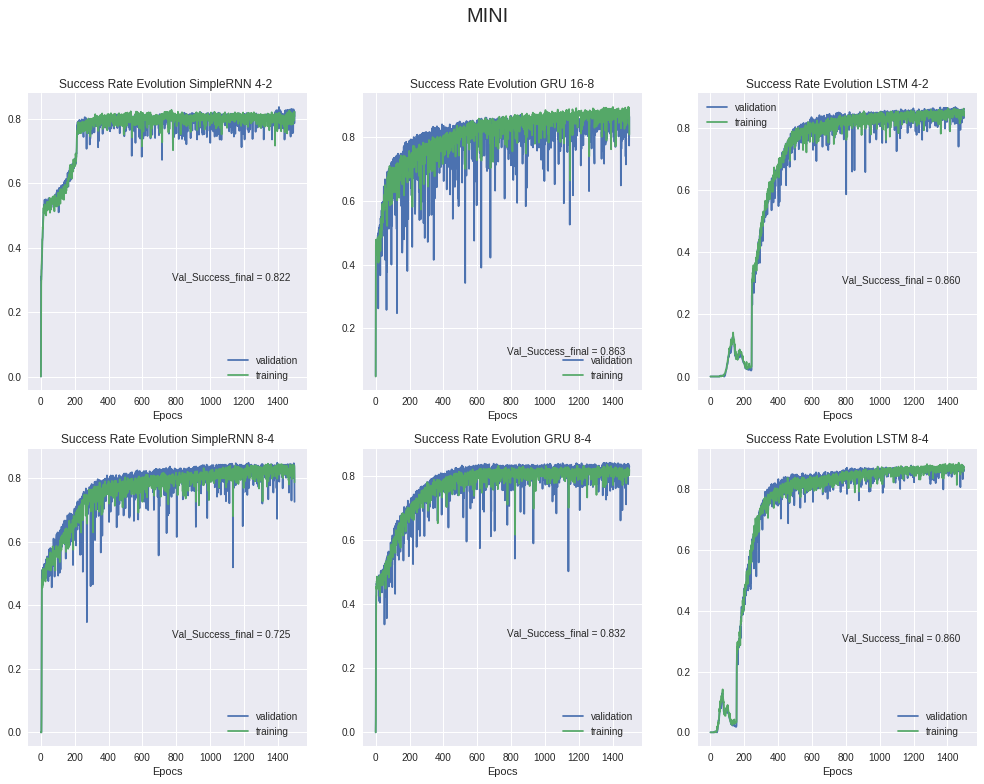

In [47]:
fig, axes = plt.subplots(2, 3,figsize=(17, 12))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la RNN 4-2
axes[0,0].plot(history_RNN42.epoch,history_RNN42.history['val_porcentaje_margen'],label='validation')
axes[0,0].plot(history_RNN42.epoch,history_RNN42.history['porcentaje_margen'],label="training")
axes[0,0].legend()
axes[0,0].set_title('Success Rate Evolution SimpleRNN 4-2 ')
axes[0,0].set_xlabel('Epocs')
axes[0,0].annotate('Val_Success_final = %.3f'% history_RNN42.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)


# Plot de la RNN 18-4
axes[1,0].plot(history_RNN84.epoch,history_RNN84.history['val_porcentaje_margen'],label='validation')
axes[1,0].plot(history_RNN84.epoch,history_RNN84.history['porcentaje_margen'],label="training")
axes[1,0].legend()
axes[1,0].set_title('Success Rate Evolution SimpleRNN 8-4')
axes[1,0].set_xlabel('Epocs')
axes[1,0].annotate('Val_Success_final = %.3f'% history_RNN84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la GRU 4-2
axes[0,1].plot(history_GRU42.epoch,history_GRU42.history['val_porcentaje_margen'],label='validation')
axes[0,1].plot(history_GRU42.epoch,history_GRU42.history['porcentaje_margen'],label="training")
axes[0,1].legend()
axes[0,1].set_title('Success Rate Evolution GRU 16-8')
axes[0,1].set_xlabel('Epocs')
axes[0,1].annotate('Val_Success_final = %.3f'% history_GRU42.history['val_porcentaje_margen'][-1], (1250, 0.12), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la GRU 8-4
axes[1,1].plot(history_GRU84.epoch,history_GRU84.history['val_porcentaje_margen'],label='validation')
axes[1,1].plot(history_GRU84.epoch,history_GRU84.history['porcentaje_margen'],label="training")
axes[1,1].legend()
axes[1,1].set_title('Success Rate Evolution GRU 8-4')
axes[1,1].set_xlabel('Epocs')
axes[1,1].annotate('Val_Success_final = %.3f'% history_GRU84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 4-2
axes[0,2].plot(history_LSTM42.epoch,history_LSTM42.history['val_porcentaje_margen'],label='validation')
axes[0,2].plot(history_LSTM42.epoch,history_LSTM42.history['porcentaje_margen'],label="training")
axes[0,2].legend()
axes[0,2].set_title('Success Rate Evolution LSTM 4-2')
axes[0,2].set_xlabel('Epocs')
axes[0,2].annotate('Val_Success_final = %.3f'% history_LSTM42.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 8-4
axes[1,2].plot(history_LSTM84.epoch,history_LSTM84.history['val_porcentaje_margen'],label='validation')
axes[1,2].plot(history_LSTM84.epoch,history_LSTM84.history['porcentaje_margen'],label="training")
axes[1,2].legend()
axes[1,2].set_title('Success Rate Evolution LSTM 8-4')
axes[1,2].set_xlabel('Epocs')
axes[1,2].annotate('Val_Success_final = %.3f'% history_LSTM84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

plt.show()

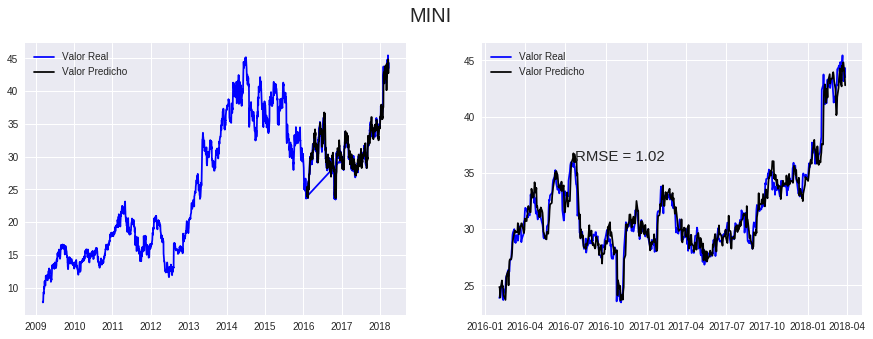

In [51]:
# Calculo la prediccion para mi conjunto test
predicted_stock_price = pd.DataFrame(modelGRU42.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmse = sqrt(mean_squared_error(ytt, predicted_stock_price))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
fig.suptitle(tickers.Symbol[index],fontsize = 20)
# Plot de todo el grafico
ax1.plot(indicedetiempo,stock_real_value,label="Valor Real",color = "blue")
ax1.plot(index_time_t,predicted_stock_price, label="Valor Predicho", color = "black")
ax1.legend()

# Plot de solo la parte que hemos hecho el predict
ax2.plot(index_time_t,ytt,label="Valor Real",color = "blue")
ax2.plot(index_time_t,predicted_stock_price, label="Valor Predicho", color = "black")
ax2.legend()
ax2.annotate('RMSE = %.2f'% rmse, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Mido el RMSE con 1500 epocas en diferentes modelos, buscamos valores bajos


| Ticket | 8-4    | 4-2   | 2-2  | 4    | 
|--------|--------|-------|----- |------|
| SNCR   | 2.67   | 2.15  | 2.15 | 2.15 | 
| EBIO   | 0.14   | 0.15  | 0.13 | 0.12 |
| MINI   | 1.34   | 1.01  | 1.01 | 1.05 |
| JBMA   | 0.67   | 0.36  | 0.35 | 0.43 |
| PTIE   | 0.83   | 0.74  | 0.83 | 0.72 |

Mido el Porcentaje_margen con 1500 epocas en diferentes modelos, buscamos valores altos


| Ticket | 8-4    | 4-2   | 2-2  | 4    | 
|--------|--------|-------|----- |------|
| SNCR   | 0.82   | 0.81  | 0.80 | 0.79 | 
| EBIO   | 0.60   | 0.50  | 0.45 | 0.48 |
| MINI   | 0.90   | 0.89  | 0.88 | 0.86 |
| JBMA   | 0.87   | 0.84  | 0.81 | 0.81 |
| PTIE   | 0.75   | 0.71  | 0.71 | 0.61 |


PTIE no hace una prediccion tan buena como las otras y es de extendido


Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [52]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos

# Es un margen movil, segun lo que busquemos
margen = 0.00
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({1.0: 297, -1.0: 243})


In [53]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26      146815        0      0  44.35  43.5258  -1
Valor Final = 146814.57
Ganancia con margen = 46814.57


In [44]:
print(movimientos_alza)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [54]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      226029        0          2619      0  44.35  43.5258  -1
Valor Final = 109876.03
Ganancia con margen = 9876.03


In [50]:
print(movimientos_ab)

            presupuesto     acciones acciones_debo estado    valor     pred  \
2016-12-30           37         2610             0      0     38.3  42.7767   
2017-01-03       203252            0          2610     -1    38.93  42.6769   
2017-01-04       203252            0          2568      0    39.66  42.2528   
2017-01-05        36.24         2648             0      1    38.96  41.5931   
2017-01-06        36.24         2648             0      0    38.62  42.4012   
2017-01-09       203667            0          2648     -1    38.45  42.4629   
2017-01-10       203667            0          2587      0    38.36  42.2726   
2017-01-11       203667            0          2587      0       39  42.0309   
2017-01-12       203667            0          2587      0    38.52  41.9139   
2017-01-13       203667            0          2587      0    38.81  41.8959   
2017-01-17       203667            0          2587      0     37.8  41.7773   
2017-01-18       203667            0          2587  

In [55]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      153131        0          1774      0  44.35  43.5258  -1
Valor Final = 74454.04
Ganancia con margen = -25545.96


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  